# Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами

<b>Цель.</b> В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>

<b>Часть 1. Парсинг.</b>
</br>По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).
</br>Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.
Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла).

<b>Часть 2. NLP.</b>
1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.
4. Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.
5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов).
6. Проинтерпретируйте результаты.

# Выполнение

Будем собирать отзывы и оценку по 5ти бальной шкале с сайта https://irecommend.ru/ по теме "Банки и банковские продукты".
</br>Первая страница банковских продуктов: https://irecommend.ru/catalog/rating/22
</br>Начиная со второй страницы ссылка выглядит так: https://irecommend.ru/catalog/rating/22?page=1
</br>Переберём все страницы с банковскими продуктами до тех пор пока не получим список всех ссылок на отзыв (пока не получим пустой массив или не наткнёмся на ответ 302 Found или блокировку сервера 521). </br>Ссылки будем получать из тега с классом class="read-all-reviews-link-bottom read-all-reviews-link".

Импортируем основные библиотеки.

In [ ]:
!pip install fake_useragent pandas pymystem3 tqdm matplotlib sklearn -q

In [11]:
import os
import re
import time
import json
import urllib3
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import pandas as pd
from pymystem3 import Mystem
from tqdm import tqdm
import nltk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [113]:
timeout = 1
global_headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9,ru;q=0.8',
    'cookie'         : 'ssu=1728468925574999807; ab_var=5; ss_uid=1728468925574999807; _ym_uid=1728468928279675531; _ym_d=1728468928; _ym_uid=1728468928279675531; v=3c; _ym_isad=2; captcha_check=1_1729672476_e64ec2d0_GFQsgTxgkPm2sctQcGOkb5W7gcU=; ss_hid=65668494; _ym_d=1729672766; statsactivity=4; statstimer=3',
    'Accept-Encoding': 'gzip, deflate, br, zstd'
}

In [77]:
# Отключиv предупреждения о непроверенных HTTPS-запросах
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def get_review_links(session, page_url):
    try:
        response = session.get(page_url, headers=global_headers, verify=False)
        if response.status_code == 302:  # Перенаправление указывает на конец страницы
            return []
        soup = BeautifulSoup(response.content, 'html.parser')
        review_links = []
        for link in soup.find_all('a', class_='read-all-reviews-link-bottom read-all-reviews-link'):
            review_links.append(urljoin(page_url, link.get('href')))
        return review_links
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return []

def scrape_all_review_links(base_url, start_page=0):
    ua = UserAgent()
    all_links = []
    page = start_page
    with requests.Session() as session:
        while True:
            if page == 0:
                page_url = base_url
            else:
                page_url = f"{base_url}?page={page}"
            links = get_review_links(session, page_url)
            if not links:  # Если ссылки не найдены, прерываем цикл
                break
            all_links.extend(links)
            page += 1
            print(f"page: {page}")
            time.sleep(timeout)  # Задержка между запросами
    return all_links

def save_links_to_file(links, filename):
    with open(filename, 'w') as f:
        json.dump(links, f)

def load_links_from_file(filename):
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return []

In [78]:
# Базовый URL-адрес для первоначального списка отзывов
base_url = "https://irecommend.ru/catalog/rating/22"

# Загрузим все ссылки на просмотр с начальных страниц
all_review_links = load_links_from_file('all_review_links.json')
if not all_review_links:
    all_review_links = scrape_all_review_links(base_url)
    save_links_to_file(all_review_links, 'all_review_links.json')

# Вывод длины массива
print("Количество ссылок:", len(all_review_links))

# Вывод первых 10 записей массива
print("Вывод первых 10 ссылок:")
for link in all_review_links[:10]:
    print(link)

['https://irecommend.ru/content/alfa-bank-premium', 'https://irecommend.ru/content/vsegda-da', 'https://irecommend.ru/content/nakopitelnyi-alfa-schet-1', 'https://irecommend.ru/content/bankovskaya-karta-ozon-1', 'https://irecommend.ru/content/investitsionnaya-kompaniya-trinfiko', 'https://irecommend.ru/content/programma-urozhai-ot-rosselkhozbanka', 'https://irecommend.ru/content/nakopitelnyi-schet-ozon-1', 'https://irecommend.ru/content/platezhnyi-stiker-alfa-bank', 'https://irecommend.ru/content/ipoteka-tinkoff-0', 'https://irecommend.ru/content/uber-park', 'https://irecommend.ru/content/kreditnaya-karta-svoya', 'https://irecommend.ru/content/kredit-nalichnymi-ot-tinkoff-bank-1', 'https://irecommend.ru/content/khais-bank', 'https://irecommend.ru/content/tinkoff-drive-debetovaya-karta-drive', 'https://irecommend.ru/content/debetovaya-karta-tinkoff-black-30', 'https://irecommend.ru/content/plastikovaya-karta-appetitnaya-ao-rosselkhozbank', 'https://irecommend.ru/content/ekom-bank', 'htt

Теперь перейдём в каждую полученную ссылку в массиве all_review_links (переходим в каждый банковский продукт) и получим список ссылок на отзывы для каждого банковского продукта.
</br>Ссылки берём из тега с классом "class="reviewTextSnippet"".

In [80]:
def get_review_snippet_links(session, product_url):
    try:
        response = session.get(product_url, headers=global_headers, verify=False)
        if response.status_code != 200:
            return []
        soup = BeautifulSoup(response.content, 'html.parser')
        snippet_links = []
        for link in soup.find_all('a', class_='reviewTextSnippet'):
            snippet_links.append(urljoin(product_url, link.get('href')))
        return snippet_links
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return []

def scrape_all_snippet_links(all_review_links):
    usag = UserAgent()
    all_snippet_links = []
    with requests.Session() as session:
        for product_link in all_review_links:
            snippet_links = get_review_snippet_links(session, product_link)
            all_snippet_links.extend(snippet_links)
            time.sleep(timeout)
    return all_snippet_links

In [81]:
all_snippet_links = load_links_from_file('all_snippet_links.json')
if not all_snippet_links:
    all_snippet_links = scrape_all_snippet_links(all_review_links)
    save_links_to_file(all_snippet_links, 'all_snippet_links.json')

print("Количество ссылок:", len(all_snippet_links))

print("Вывод первых 10 ссылок:")
for link in all_snippet_links[:10]:
    print(link)

Количество ссылок: 22175
Вывод первых 10 ссылок:
https://irecommend.ru/content/dengi-k-dengam-ili-pochemu-bogatye-vsegda-platyat-menshe-premialnoe-obsluzhivanie-alfa-banka
https://irecommend.ru/content/kak-ya-premialnym-klientom-stat-khotela
https://irecommend.ru/content/alfa-premium
https://irecommend.ru/content/velikolepnyi-servis-n10241640
https://irecommend.ru/content/na-otdykh-s-komfortom
https://irecommend.ru/content/luchshii-bank-dlya-premialnogo-obsluzhivaniya
https://irecommend.ru/content/dlya-ekonomii-vremeni-ochen-poleznyi-servis
https://irecommend.ru/content/alfa-premium-povyshaet-status
https://irecommend.ru/content/alfa-bank-premium-n10151299
https://irecommend.ru/content/premium-znachit-vysokoe-kachestvo-obsluzhivaniya


Теперь перейдём в каждый отзыв и соберём датасет из самого отзыва и рейтинга, указанного пользователем.

Отзыв содержится внутри div с классом class="description hasinlineimage" и состоит из массива тегов $<p>...</p>$, а также вложенных в них различных других тегов.

Рейтинг содержится в теге $<meta>$ в параметре content для параметра itemprop="ratingValue".

Теперь соберём датасет и сохраним в корне проекта.
В датасете будет два столбца:
Первый столбец: "text_review".
Второй столбец: "rating_review".

Для сбора датасета:
1. Перейдём по каждой ссылке массива all_snippet_links.
2. Для text_review соберём отзыв. Вытащим всё из тегов p и склеим между собой.
3. Для rating_review соберём рейтинг, который представлен числами: 1,2,3,4,5.
4. Сохраним файл локально.
5. Выведем первые 5 записей из датасета для проверки.

In [119]:
def scrape_review_data(all_snippet_links):
    reviews_data = []
    with requests.Session() as session:
        counter = 0
        for review_link in all_snippet_links:
            headers = global_headers
            global_headers['Referer'] = review_link
            
            response = session.get(review_link, headers=headers, verify=False)
            if response.status_code == 521:
                print(f"Server error on {review_link}, status code: 521. Retrying...")
                break
            if response.status_code == 403:
                print(f"Failed to load page: {review_link}, status code: {response.status_code}")
                continue
            if response.status_code != 200:
                print(f"Failed to load page: {review_link}, status code: {response.status_code}")
                break
            soup = BeautifulSoup(response.content, 'html.parser')

            # Получаем текст отзыва
            review_div = soup.find('div', class_='description hasinlineimage')
            if not review_div:
                print(f"No review text found on: {review_link}")
                break
            review_text = " ".join(p.get_text(separator=' ', strip=True) for p in review_div.find_all('p'))

            # Получаем рейтинг
            rating_meta = soup.find('meta', itemprop='ratingValue')
            if not rating_meta:
                print(f"No rating found on: {review_link}")
                break
            rating_value = rating_meta.get('content')

            print(f"{counter}. Scraped review: {review_text[:30]}..., Rating: {rating_value}")
            reviews_data.append({'text_review': review_text, 'rating_review': rating_value})
            counter += 1
            time.sleep(timeout)
    return reviews_data

In [123]:
filename = 'reviews_dataset.csv'

if os.path.exists(filename):
    df = pd.read_csv(filename)
    if df.empty:
        print("Файл 'reviews_dataset.csv' пуст.")
    else:
        print("Данные успешно загружены из файла 'reviews_dataset.csv'.")
else:
    print("В файле 'reviews_dataset.csv' не найдено никаких данных, пытаюсь восстановить данные отзывов...")
    reviews_data = scrape_review_data(all_snippet_links)
    df = pd.DataFrame(reviews_data)
    df.to_csv(filename, index=False)
    print("Данные успешно обработаны и сохранены в файле 'reviews_dataset.csv'.")

Данные успешно загружены из файла 'reviews_dataset.csv'.


К сожалению, данных собралось не очень много, т.к. сервер постоянно блокировал запросы с ответом 521. Посмотрим на получившийся датасет.

In [124]:
df.head()

,text_review,rating_review
0,"Помните сцену из фильма ""Квартета И"", где к ми...",4
1,Не так давно у Альфа-Банка появился довольно в...,1
2,"Выбирала, какую же карту взять, просто дебетов...",5
3,При моей должности консультанта-делопроизводит...,5
4,Мы с семьей запланировали поездку по нескольки...,5


In [125]:
df.shape

(1066, 2)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_review    1058 non-null   object
 1   rating_review  1066 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.8+ KB


In [127]:
# Удаление строк с пустыми значениями в колонке text_review
df = df.dropna(subset=['text_review'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1058 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_review    1058 non-null   object
 1   rating_review  1058 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.8+ KB


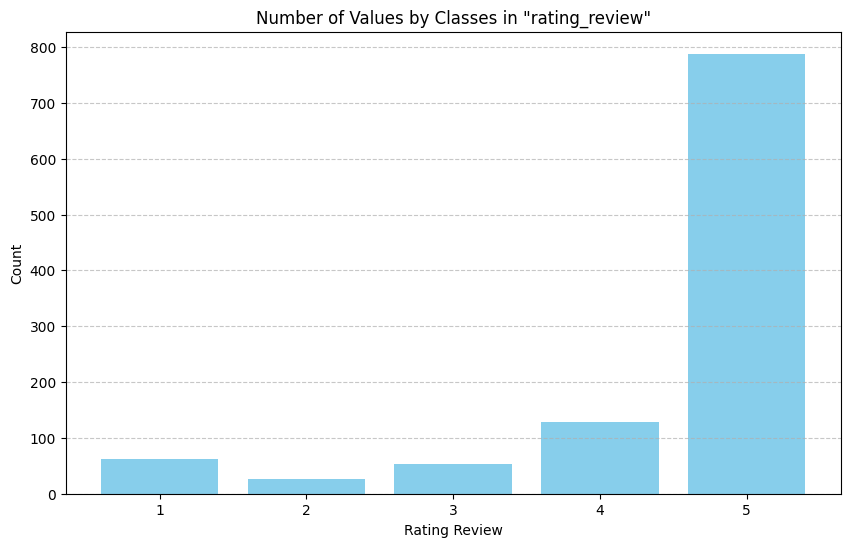

In [128]:
# Подсчет количества значений по классам в признаке "rating_review"
rating_counts = df['rating_review'].value_counts().sort_index()

# Построение графика
plt.figure(figsize=(10, 6))
plt.bar(rating_counts.index, rating_counts.values, color='skyblue')
plt.xlabel('Rating Review')
plt.ylabel('Count')
plt.title('Number of Values by Classes in "rating_review"')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()

Видим, что датасет получился с маленьким количеством записей и сильно несбалансированным по классам. Но мы всё равно с ним поработаем.

Применение tf-idf преобразования.

In [130]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('russian')

# примеры стоп-слов
print(len(stop_words))
print(stop_words[:10])

[nltk_data] Downloading package stopwords to /home/eugen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/eugen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


151
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']


In [131]:
word_tokenizer = nltk.WordPunctTokenizer() # знаки препинания (группами) идут в один токен

In [132]:
regex = re.compile(r'[А-Яа-яA-zёЁ-]+')

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).lower() # to lower case
    except:
        return ""

# расширим список стоп-слов, словами, которые являеются стоп-словами в данной задаче
add_stop_words = ['ао', 'оао', 'ооо', 'тот', 'кто', 'цб', 'ровд', 'кого', 'те', '178956970,38125', 'оповещения', 'ежемесячная', 'побыстрее', 'покупаешь', 'пал', 'возможностью', 'доходом', 'наслаждаться', 'трудности', 'процентах', 'довольны', 'обновить', 'подходящее', 'быстрым', 'помогли', 'подходящий', 'ситуаций', 'приобретение', 'вещей', 'становятся', 'бывали', 'скачал', 'результатом', 'выплачивать', 'ищет', 'поисках', 'наткнулся', 'планшета', 'руке', 'приятное', 'информирования', 'включает', 'мобильным', 'отношении', 'дел', 'шубу', 'предложении', 'соответствии', 'ноутбука', 'отдыха', 'выплатить', 'позвонить', 'выяснить', 'шоке', 'городу', 'подавать', 'разберется', 'оплатой', 'отличное', 'видел', 'уровне', 'клиника', 'огромными', 'нужного', 'главного', 'студентов', 'взрослых', 'выходила', 'многом', 'основных', 'блогеров', 'красивая', 'уход', 'шло', 'окна', 'свободно', 'главным', 'поиск', 'гарантии', 'дню', 'относятся', 'заинтересовало', 'выполнены', 'изделие', 'украшения', 'изделия', 'голова', 'корзину', 'обработки', 'стилистике', 'находился', 'вес', 'удачных', 'устроило', 'семью', 'этапе', 'объяснять', 'черный', 'возраста', 'идем', 'налички', 'детские', 'кешбеков', 'обслуживанию', 'тысяча', 'скинула', 'попросил', 'переводится', 'выпускается', 'отдельная', 'школе', 'голову', 'смысле', 'приехать', 'привезут', 'глазами', 'кармане', 'потерял', 'вероятность', 'полезная', 'обслуживании', 'праздники', 'классная', 'манипуляций', 'справилась', 'манипуляции', 'накопилось', 'приходил', 'сохраняется', 'выполнять', 'пополнений', 'бесконтактной', 'трёхзначный', 'сдачу', 'утери', 'чехол', 'маме', 'желаю', 'молодежная', 'банковском', 'занимается', 'смогут', 'забыли', 'понадобилось', 'открыты', 'дизайна', 'смартфоне', 'смотрю', 'встреч', 'добро', 'принято', 'продолжить', 'отобразится', 'хранится', 'определиться', 'привязывается', 'платежные', 'новому', 'случится', 'сберу', 'кассах', 'результаты', 'случаи', 'вашему', 'детьми', 'ближайшем', 'робот', 'последнем', 'дальнейшего', 'каждое', 'принимают', 'теряется', 'особенность', 'знаком', 'заполнения', 'становитесь', 'данными', 'постоянной', 'категорией', 'награду', 'детства', 'неудобна', 'популярные', 'набирает', 'красная', 'игру', 'изучили', 'говорил', 'скидок', 'знакомо', 'всём', 'кошельков', 'учесть', 'области', 'связаться', 'представлен', 'бака', 'связано', 'закупается', 'тратили', 'штрафы', 'ушли', 'случалось', 'жены', 'реальные', 'заправился', 'забывать', 'высоким', 'принцип', 'рассмотрим', 'сложная', 'характера', 'симку', 'повседневные', 'обязаны', 'экономлю', 'слежу', 'лайфхак', 'продуктовых', 'успел', 'повышенным', 'ездить', 'планируете', 'октябре', 'оставался', 'действовала', 'годов', 'причин', 'долгами', 'лишнее', 'удивили', 'поддержкой', 'лукойле', 'вернуться', 'требует', 'статуса', 'написания', 'спишут', 'отелей', 'отели', 'привыкли', 'изменится', 'сайтах', 'мае', 'июле', 'начисляли', 'возникнуть', 'билета', 'учет', 'определяется', 'льготном', 'общая', 'банкомата', 'медикаменты', 'опции', 'акциях', 'доме', 'ипотечный', 'конец', 'планировали', 'новостройки', 'взнос', 'результате', 'новостройке', 'помогали', 'писали', 'собирать', 'берешь', 'стикер', 'отказали', 'этапов', 'делали', 'электронная', 'снилс', 'интересную', 'предоставили', 'самих', 'отпуск', 'захочу', 'отделений', 'проверки', 'прозрачный', 'знали', 'согласовали', 'снимут', 'хотим', 'начну', 'проводит', 'рассмотрение', 'одобрена', 'поехали', 'вложений', 'нужных', 'обязательным', 'участников', 'письмо', 'текущий', 'выросли', 'нажала', 'показал', 'указала', 'надпись', 'пособия', 'малого', 'стандартная', 'сэкономила', 'снижения', 'платеже', 'сказано', 'порекомендовать', 'имейте', 'прикладывать', 'доставкой', 'собственной', 'списаний', 'фишка', 'ки', 'основе', 'отзывах', 'дала', 'ввел', 'остатку', 'пределах', 'умею', 'гарантия', 'приезжает', 'лучшем', 'непредвиденные', 'продавать', 'снизить', 'лучшее', 'отменить', 'потрачено', 'попадается', 'финансовая', 'держу', 'срабатывает', 'показала', 'актуальны', 'вперёд', 'описала', 'крупную', 'вспомнила', 'спишется', 'конкретный', 'минимального', 'подводя', 'описании', 'актуален', 'букв', 'решалась', 'каникулы', 'требование', 'правилам', 'раздела', 'задним', 'причинам', 'обратная', 'следующей', 'пишет', 'практике', 'пустыми', 'финансово', 'предлагать', 'запросы', 'упомянуть', 'партнерах', 'августа', 'общения', 'закрыты', 'смотрим', 'будущее', 'кредиток', 'удобные', 'штуки', 'кешбэком', 'подарили', 'определённые', 'базовый', 'сотрудничество', 'клиенты', 'начислил', 'заплатила', 'поинтереснее', 'любым', 'фирмы', 'близких', 'застраховать', 'обычным', 'кладете', 'долгах', 'вкусные', 'овердрафт', 'идеей', 'актуальные', 'вносила', 'привлекательными', 'совершаете', 'считаться', 'выполнила', 'обратите', 'отправляют', 'суммами', 'коротко', 'выплачиваются', 'копеечки', 'комиссиями', 'составили', 'зарабатывает', 'пополнением', 'подушку', 'инвестиций', 'применена', 'применяется', 'рынок', 'вуаля', 'фонды', 'перестать', 'растет', 'нахожу', 'виртуальный', 'россельхозбанке', 'лучшая', 'витрина', 'приятные', 'дарить', 'воздуха', 'подключала', 'жирный', 'следующем', 'кольцу', 'снимая', 'получим', 'россельхоз', 'начинают', 'почте', 'переписки', 'предупредили', 'материал', 'инструкции', 'постараюсь', 'фактор', 'устройства', 'размеров', 'состояние', 'любимые', 'небольших', 'сумм', 'блогера', 'конвертом', 'ненужных', 'ненавижу', 'числу', 'олег', 'ищу', 'маму', 'card', 'интересует', 'раздражает', 'зачисляется', 'ассистент', 'продолжаю', 'услугам', 'определенных', 'выделить', 'бесплатного', 'совершила', 'исправить', 'поговорим', 'лишняя', 'вознаграждения', 'установил', 'опцию', 'совет', 'дешевое', 'искала', 'переводите', 'лк', 'назначил', 'народ', 'обещанные', 'дополнительное', 'уважаемые', 'осуществляется', 'объясняю', 'преимуществом', 'некоторым', 'музыка', 'гигиены', 'партнеры', 'второго', 'банковское', 'заморочек', 'функционал', 'продолжать', 'управление', 'ощущается', 'освежает', 'годности', 'вскрытия', 'упаковки', 'флакон', 'свежесть', 'рассказывал', 'десен', 'рту', 'рот', 'названием', 'типу', 'мышеловке', 'главных', 'роли', 'удастся', 'владельца', 'текущего', 'cvv', 'дороге', 'рсхб', 'алгоритм', 'физическим', 'отправитель', 'левом', 'окошке', 'организациях', 'вк', 'сказанное', 'поймете', 'momentum', 'мера', 'пятерочки', 'пенсионеров', 'футляра', 'рос', 'звучит', 'никого', 'лукойл', 'заправщик', 'заправилась', 'самозанятый', 'пенсионный', 'произошла', 'платежами', 'бумажек', 'техники', 'доступные', 'предоставления', 'бюджета', 'обладательницей', 'переплаты', 'выбором', 'необходимостью', 'рассрочек', 'частей', 'откладывая', 'хлопот', 'штрафных', 'настоящим', 'спасением', 'положительным', 'знакомый', 'объяснить', 'рад', 'электронные', 'мобильные', 'объясняют', 'дорожают', 'рассрочке', 'мечты', 'займы', 'искал', 'выгодную', 'настоящее', 'процедуры', 'подобными', 'контроля', 'удивлен', 'отключения', 'специалистов', 'существенное', 'классный', 'облегчает', 'рассрочкой', 'узнав', 'экран', 'памяти', 'изменений', 'пообещали', 'качественные', 'подарить', 'особых', 'опыта', 'уверены', 'помогают', 'уведомлений', 'низкой', 'ноутбук', 'достаточное', 'компьютера', 'плохая', 'проверка', 'висит', 'согласия', 'копи', 'интернетом', 'оформляю', 'дорогой', 'поделится', 'клиники', 'посещении', 'этаже', 'предусмотрен', 'включить', 'оформлено', 'выдают', 'клинике', 'школа', 'останавливаться', 'предпринимателей', 'сделан', 'полученные', 'знания', 'проводить', 'ношу', 'девушки', 'приема', 'кошелёк', 'поле', 'дороги', 'ходит', 'дворе', 'обратились', 'современные', 'весной', 'территории', 'укропа', 'укроп', 'участке', 'своём', 'счастье', 'продажу', 'погасила', 'светится', 'месячный', 'отправляю', 'закрыт', 'большинстве', 'виден', 'поиска', 'материала', 'разнообразия', 'представлены', 'сторона', 'возможен', 'греет', 'поступил', 'форм', 'длительного', 'дизайны', 'исполнилось', 'сыграла', 'карман', 'сыном', 'деньгам', 'понимание', 'ограничить', 'положил', 'складывать', 'кэшбеки', 'даю', 'карманные', 'нормальную', 'подробный', 'увидел', 'зашли', 'понадобился', 'некоторыми', 'оговорками', 'выручила', 'отчет', 'выбирал', 'скинуть', 'вообщем', 'инструментом', 'выдается', 'пиши', 'пропало', 'полезного', 'контролем', 'след', 'наличка', 'днем', 'сестра', 'семейной', 'моментом', 'просит', 'переводами', 'семьей', 'вопроса', 'спокойнее', 'придумал', 'старалась', 'терминала', 'свидетельства', 'столе', 'яркое', 'оплатите', 'понимать', 'посуды', 'обманули', 'стандартный', 'обороте', 'взрослом', 'существенных', 'специальный', 'приложить', 'готовности', 'приходили', 'сходила', 'нужным', 'движения', 'уточнения', 'случая', 'ждали', 'службы', 'согласна', 'заводить', 'настроения', 'работал', 'мамы', 'поставлю', 'звезду', 'отказано', 'скриншоты', 'понравится', 'расплатилась', 'купюры', 'учится', 'документ', 'открывшемся', 'выдачу', 'распоряжаться', 'аналогии', 'истечении', 'просил', 'учета', 'просмотр', 'тарифу', 'деталей', 'предусматривает', 'пытался', 'пытаюсь', 'радуют', 'книгу', 'устраивали', 'прежнему', 'возьмите', 'app', 'белом', 'брата', 'лишнего', 'собственные', 'списку', 'борьбе', 'кэшбэков', 'сработало', 'проекты', 'меняла', 'необходимых', 'функционале', 'кредитах', 'любопытный', 'вечеру', 'привилегия', 'скромные', 'детском', 'назначить', 'специальную', 'устанавливаем', 'результата', 'комиксы', 'беспроцентной', 'менялась', 'желаемого', 'базовом', 'замечаю', 'ведёт', 'личной', 'кликов', 'рулем', 'сгорят', 'превысить', 'электронных', 'актуальных', 'совершенные', 'сотни', 'выходные', 'проценту', 'компенсацией', 'концерты', 'посоветовал', 'обычном', 'показатель', 'водитель', 'твои', 'действуют', 'тратил', 'бонусах', 'ежемесячной', 'связался', 'отслеживаю', 'зарплатная', 'мобильную', 'версию', 'стажем', 'копеечку', 'полном', 'оплатил', 'делал', 'попадать', 'выгодного', 'заливаю', 'прилетают', 'лишний', 'смущает', 'сложность', 'провожу', 'оставалось', 'небольшим', 'прав', 'крутое', 'простому', 'возвращает', 'цифрами', 'копите', 'изменилось', 'спецпредложения', 'ходу', 'оставлять', 'отвечали', 'познакомилась', 'свободное', 'заправкой', 'окупить', 'дебетовый', 'оправдала', 'перестали', 'расплачивались', 'советовать', 'ряду', 'обстоятельства', 'приятными', 'обувью', 'возместить', 'зубную', 'иллюзию', 'берегу', 'воздержаться', 'заставляет', 'торопиться', 'записи', 'вопросах', 'привлечения', 'пора', 'введения', 'wallet', 'согласитесь', 'являетесь', 'дополняю', 'раскладе', 'погашении', 'идеале', 'понравились', 'вернем', 'поясню', 'апреле', 'июне', 'известных', 'машинки', 'переход', 'багажом', 'накопит', 'переходе', 'указывается', 'задолженностью', 'предоставляется', 'путешественника', 'покрытие', 'оплатит', 'устроили', 'считать', 'район', 'сдадут', 'бумагами', 'вносишь', 'заставил', 'мелким', 'кусается', 'пройдет', 'уменьшается', 'присмотрели', 'льготная', 'понятные', 'господдержкой', 'встретились', 'наблюдать', 'капитал', 'переехать', 'отправили', 'накопили', 'растут', 'забыл', 'оставили', 'лежала', 'лишней', 'ожиданий', 'важным', 'виноваты', 'хорошем', 'надежный', 'понадобились', 'зарплатные', 'деньгах', 'добавили', 'пытались', 'проверку', 'понимала', 'велика', 'прописано', 'потеряли', 'дождаться', 'зарплатного', 'проекта', 'проблемами', 'принимает', 'единицы', 'дождалась', 'заключения', 'московской', 'сотрудником', 'теряю', 'решались', 'лекарства', 'выдал', 'выдаче', 'концу', 'историей', 'меньшую', 'прочитав', 'удобную', 'автоплатеж', 'эмоциях', 'отказываюсь', 'подала', 'забегая', 'прислал', 'принадлежит', 'отключила', 'отнести', 'уложиться', 'захотела', 'определяет', 'рекламную', 'влезла', 'шли', 'дадут', 'официальной', 'звонка', 'улице', 'неприятные', 'влияет', 'возникало', 'отдал', 'понадобятся', 'существу', 'писал', 'сыграло', 'половина', 'старых', 'чувствую', 'предложенных', 'звонил', 'напрягал', 'подавала', 'безопасно', 'поступает', 'принял', 'снимает', 'привозит', 'парень', 'висят', 'рефинансирования', 'финансовое', 'нормальный', 'отказываться', 'оцениваю', 'обращалась', 'изучила', 'запрашивала', 'перечислить', 'отсрочить', 'складывается', 'работали', 'знакома', 'рассказывала', 'продала', 'ругаться', 'просят', 'скринах', 'доступных', 'откроется', 'пени', 'выставят', 'посчитаем', 'альтернативу', 'задать', 'финансов', 'коммунальных', 'просрочку', 'законными', 'номеров', 'отправился', 'подумайте', 'совкомбанке', 'группе', 'случается', 'коды', 'выросла', 'нюансах', 'ужас', 'минимальном', 'минусом', 'нужд', 'замечать', 'даёт', 'сниму', 'подведу', 'попытаться', 'отрицательный', 'тело', 'просчитать', 'кредиткам', 'кредитках', 'запись', 'доказать', 'составляла', 'закрыли', 'прочим', 'обманул', 'думайте', 'середине', 'резюмируя', 'доверия', 'обратившись', 'имеем', 'читаем', 'договорились', 'кэша', 'перечисляют', 'платёжной', 'пополнении', 'чужие', 'языком', 'появляться', 'длится', 'закрытии', 'шикарная', 'сложные', 'лицу', 'видят', 'подача', 'денежный', 'заканчивается', 'возвращают', 'составлять', 'календарный', 'считаются', 'зачислились', 'повышения', 'инфляции', 'возвращаемся', 'определённый', 'придут', 'расчёта', 'параметры', 'личных', 'личным', 'отказались', 'процентам', 'меняться', 'интересный', 'галочку', 'приносят', 'сестрой', 'сходить', 'изучала', 'капают', 'подальше', 'начислится', 'потеряете', 'изменилась', 'небольшое', 'сбережения', 'подняли', 'открывали', 'открываете', 'минимальных', 'открывал', 'используется', 'щедрости', 'налогообложения', 'ключевая', 'брокер', 'голубых', 'помните', 'дивидендов', 'присутствует', 'остаться', 'инвестирования', 'айреке', 'читаю', 'заемными', 'бирже', 'каталог', 'совершении', 'участвуют', 'коллегам', 'боится', 'доплатить', 'мелкая', 'цен', 'маски', 'неплохая', 'способе', 'заинтересован', 'ежедневному', 'обращаю', 'позволяют', 'войти', 'положив', 'размеры', 'попытки', 'путешествия', 'важнее', 'одноименном', 'серьезные', 'тройка', 'заполняется', 'поздравляю', 'сетей', 'бесплатную', 'чеки', 'специальной', 'платную', 'ежедневных', 'ссылкой', 'пригласил', 'ценные', 'приглашение', 'противном', 'подзаработать', 'оформляйте', 'режим', 'олега', 'ближайшую', 'выплату', 'куче', 'прозрачная', 'форму', 'стикеры', 'платным', 'перейти', 'рукой', 'подойдёт', 'старой', 'копейка', 'отписки', 'сайтов', 'используя', 'налоговую', 'выйти', 'выпал', 'рассказывать', 'тарифе', 'случился', 'зависят', 'радость', 'перенести', 'оборотной', 'описание', 'техподдержки', 'подключается', 'расчетного', 'пользы', 'уйти', 'понятия', 'получают', 'проводят', 'минусах', 'подвох', 'партнерский', 'возможных', 'большого', 'успеть', 'рулём', 'комментарии', 'менеджеров', 'трудностей', 'приглашению', 'прилагаю', 'кодом', 'заходите', 'переводам', 'подобного', 'офисы', 'определенного', 'российского', 'выгоден', 'увидев', 'снижает', 'календулы', 'тысячелистника', 'препятствует', 'кубиков', 'гп', 'персонажей', 'марки', 'эмаль', 'способствует', 'укрепление', 'упоминала', 'формула', 'колпачок', 'sodium', 'легкий', 'поверхность', 'втором', 'дораме', 'отношений', 'парня', 'участием', 'героев', 'вкладами', 'операциями', 'посмотрела', 'начислить', 'указав', 'красном', 'напомнить', 'табачную', 'подсолнечное', 'закупаетесь', 'поближе', 'актуальна', 'акцией', 'советы', 'рабочий', 'узнаю', 'подешевле', 'копиться', 'качества', 'торговой', 'использованию', 'выйдет', 'заморозить', 'поступлении', 'подтверждаем', 'мгновенное', 'подключаю', 'нажимать', 'отправителя', 'уточните', 'телефонной', 'нспк', 'оборота', 'вводите', 'пары', 'правом', 'прокручиваем', 'проблематично', 'обратила', 'снизил', 'списаны', 'высвечивается', 'появлением', 'необходимая', 'осуществления', 'находила', 'заходила', 'отрицательные', 'подпишитесь', 'болейте', 'сбои', 'установлено', 'призы', 'покупайте', 'ускорить', 'продукту', 'сайты', 'сложный', 'посмотрите', 'пропустите', 'бесплатны', 'общие', 'храните', 'заправками', 'матушке', 'отвезла', 'пригодятся', 'сомнения', 'вкрапления', 'маркировка', 'идентификации', 'операторов', 'кошельку', 'попробовала', 'налоговая', 'буквами', 'суммам', 'ждал', 'портал', 'капитализация', 'доску', 'упаковку', 'уменьшить', 'клюква', 'клюквы', 'плитки', 'произошёл', 'колонке', 'рассч', 'справкой', 'режима', 'числом', 'барабане', 'почитала', 'навязывают', 'сократить', 'стараться', 'ближайшие', 'телевизора', 'риска', 'машин', 'ущерба', 'столкнулся', 'телевизор', 'единовременной', 'сложных', 'предложениями', 'стресса', 'доступным', 'накоплением', 'доступной', 'подписал', 'смартфоном', 'доступными', 'навязывали', 'возникающие', 'сервису', 'годом', 'захочет', 'организаций', 'классное', 'займом', 'реже', 'вежливые', 'оставлял', 'лучшего', 'бытовую', 'холодильника', 'справляется', 'планшет', 'преимуществах', 'приложениями', 'фильмы', 'современный', 'необходимым', 'предупредил', 'сообщили', 'настал', 'подарка', 'беспокоиться', 'дожидаясь', 'безопасный', 'процесса', 'простые', 'заполнение', 'занимают', 'платежах', 'ежемесячным', 'беспроцентная', 'решиться', 'отказать', 'идеальным', 'частями', 'качественный', 'количеством', 'ярким', 'восторге', 'приходило', 'ходе', 'взят', 'могло', 'контору', 'заказываю', 'пораньше', 'сдавать', 'часы', 'маркетплейс', 'репутация', 'переживаю', 'посещение', 'клинику', 'молодых', 'космические', 'девочки', 'показатели', 'подойти', 'вспомнить', 'удаленно', 'ситуацией', 'продаж', 'сбережений', 'направления', 'примеры', 'мероприятие', 'улыбка', 'рассчитывала', 'улыбкой', 'проводила', 'приобрели', 'площадок', 'выходят', 'адекватные', 'обстановка', 'скрывать', 'отделку', 'решается', 'ошиблась', 'вкусом', 'растёт', 'меняли', 'помещении', 'компанию', 'требованием', 'плакали', 'установлены', 'установили', 'дизайнеров', 'цветами', 'весом', 'реакции', 'вызвали', 'знакомства', 'определила', 'позиций', 'понятная', 'неожиданные', 'распродажи', 'красоты', 'остановил', 'котлована', 'ребенком', 'остановки', 'транспорта', 'застройщик', 'подозреваю', 'научит', 'набегает', 'мнением', 'девочке', 'явное', 'поверьте', 'отношению', 'возраст', 'периоды', 'беспокоит', 'предупредила', 'третью', 'читает', 'понятен', 'отображались', 'даем', 'определенное', 'уговорить', 'побоялась', 'взрослые', 'всяком', 'старший', 'оформит', 'присылает', 'устанавливать', 'приучает', 'способен', 'подсказать', 'закидываю', 'сторон', 'устройство', 'малых', 'приоритете', 'уехал', 'телефоны', 'вечер', 'опций', 'заданий', 'посуду', 'спрашивает', 'считает', 'денежными', 'крутая', 'запустил', 'аналогичными', 'отчёт', 'знаешь', 'друзьями', 'идею', 'школьной', 'столовой', 'безналичные', 'продавцу', 'тинькова', 'поисковике', 'изготовление', 'малышу', 'придумывает', 'сбермегамаркете', 'детское', 'безопасность', 'равен', 'актуальный', 'закончить', 'итд', 'отклонить', 'телеграмм', 'спорить', 'решит', 'сделана', 'симпатичная', 'яркая', 'безопаснее', 'бесконтактную', 'попытка', 'родительского', 'просматривать', 'насчёт', 'совпадает', 'руками', 'соединили', 'специалистом', 'взяв', 'ребёнком', 'нервничать', 'помещается', 'молодежи', 'праздник', 'вернемся', 'продукте', 'выполнили', 'расплатился', 'непредвиденных', 'ситуациях', 'очевиден', 'подходила', 'зло', 'убедилась', 'бабушки', 'советуют', 'гражданина', 'висеть', 'планировать', 'отследить', 'яркий', 'получении', 'пользователю', 'прочтение', 'именную', 'пластике', 'провели', 'сделает', 'долгих', 'выпуска', 'mirpay', 'привилегии', 'пойду', 'ежемесячную', 'снимают', 'полагается', 'настоящие', 'возникновении', 'добиться', 'объяснив', 'необходима', 'рассмотреть', 'гордостью', 'странная', 'желанию', 'решаете', 'готовым', 'вести', 'масса', 'наличкой', 'отсутствия', 'пойдёт', 'сидя', 'выдаёт', 'store', 'кратчайшие', 'папы', 'хотелки', 'картинка', 'последней', 'кидал', 'платный', 'выигрывает', 'потребителя', 'зазывают', 'многообразии', 'неплохими', 'одними', 'фишку', 'возросла', 'сарафанное', '-------', 'новенькую', 'задорным', 'огурцом', 'скачиваете', 'appstore', 'нехитрые', 'открытых', 'ухудшились', 'ленивого', 'избранном', 'развлечениях', 'путешествиях', 'любопытными', 'публикациями', 'благ', 'накопленная', 'доходит', 'опцией', 'любопытные', 'оплачиваемое', 'описываем', 'недоверчивых', 'тесты', 'научат', 'найдешь', 'достает', 'потраченная', 'подобную', 'пакете', 'мнению', 'заправить', 'запчасти', 'разберемся', 'парковки', 'оформлю', 'подобные', 'лимитов', 'сгорают', 'начислению', 'выписка', 'превышать', 'рублям', 'нажатия', 'поступят', 'промо', 'промокоды', 'заказывал', 'жене', 'прочем', 'меньшее', 'расходах', 'счастья', 'владения', 'блек', 'накопление', 'вернет', 'присмотреться', 'темпами', 'особой', 'основное', 'тратам', 'залил', 'заработал', 'сэкономил', 'моментальное', 'зашло', 'приличная', 'качеству', 'активировал', 'посчитал', 'заработаешь', 'полиса', 'сплошная', 'реальный', 'службе', 'снизили', 'уходят', 'подсчитать', 'называют', 'сложной', 'расходуется', 'попадает', 'мелкий', 'поднял', 'страховке', 'делам', 'масел', 'предназначена', 'представляет', 'подсказки', 'пугает', 'обращался', 'планировал', 'глючило', 'водителей', 'рассчитывал', 'тп', 'разобрался', 'допку', 'удивило', 'инвестициям', 'автолюбителей', 'связанных', 'связанной', 'продлилось', 'семейным', 'обстоятельствам', 'связанным', 'таксовки', 'выручала', 'оказывалось', 'впасть', 'зависимость', 'росгосстраха', 'тратят', 'прочитали', 'laaguunaa', 'инвесторов', 'соответствовать', 'постоянным', 'посчитала', 'обходится', 'каждых', 'футболку', 'подкопить', 'разбил', 'создают', 'старта', 'понимаешь', 'принимаешь', 'обошелся', 'курьерская', 'превращаются', 'живут', 'мелочам', 'конвертации', 'потребует', 'кредитному', 'лимиту', 'связалась', 'торопилась', 'заправлялась', 'узнавать', 'оплачивая', 'зарплатной', 'поднести', 'держателей', 'устройств', 'сообщил', 'сообщить', 'магнитах', 'посвящен', 'окончании', 'грамотном', 'удачу', 'ознакомилась', 'известен', 'авиабилетов', 'агентстве', 'доплачивать', 'шагу', 'супермаркете', 'работаем', 'туры', 'ряда', 'действовало', 'ограничениями', 'большинству', 'привязала', 'наличия', 'разумного', 'вариации', 'вношу', 'входящих', 'расходую', 'мажоров', 'доступа', 'тестирую', 'кнопочку', 'кешбеками', 'мск', 'налогового', 'снимала', 'прошли', 'адекватную', 'нервничала', 'похожа', 'женой', 'проходил', 'чужим', 'накоплено', 'рассчитывали', 'близко', 'скидывать', 'выплачиваем', 'подавали', 'нотариальное', 'дальнейшие', 'простоту', 'сварить', 'согласованным', 'приобретаемой', 'консультировали', 'хвалят', 'глупыми', 'повторяющимися', 'вздыхают', 'справимся', 'вырастет', 'максимуму', 'ипотекой', 'первоначальный', 'переносили', 'звезд', 'фонд', 'факторов', 'честными', 'спокойной', 'обстановке', 'внесла', 'семейную', 'менеджера', 'заехали', 'региона', 'первоначального', 'назначенное', 'погашением', 'сидит', 'общался', 'помогала', 'жили', 'стаж', 'чувство', 'сделка', 'задумываться', 'подсказали', 'теме', 'одобрят', 'скором', 'недвижимость', 'бешеные', 'льготной', 'напрашивается', 'живем', 'множества', 'сделку', 'мечту', 'нынешними', 'ценами', 'залоге', 'обременение', 'быстрые', 'официального', 'скинул', 'навязать', 'документах', 'попробовав', 'изменение', 'узнали', 'отказа', 'супруги', 'устраивала', 'подвески', 'мен', 'усвоить', 'остановлюсь', 'комментариях', 'сложилось', 'собственности', 'условием', 'выдать', 'одобренной', 'наступил', 'этап', 'отчеты', 'отчетов', 'поделать', 'будь', 'этапа', 'забрал', 'зарегистрирован', 'c', 'избегала', 'кредитками', 'средствам', 'ждут', 'морге', 'вперед', 'оформлению', 'средний', 'фамилию', 'одобрением', 'кнопка', 'уменьшать', 'лета', 'исправили', 'крайнем', 'оставляю', 'подтвердил', 'звонков', 'платежам', 'обещаниями', 'повышается', 'конский', 'порекомендую', 'ежемесячного', 'участвует', 'подписание', 'сидеть', 'отложить', 'перечислили', 'ездила', 'выбирается', 'возможностями', 'связывайтесь', 'спросили', 'договором', 'заплатил', 'воздух', 'имея', 'расчётный', 'годовую', 'рекомендовала', 'подана', 'обещания', 'силы', 'услышала', 'списывают', 'высокой', 'особенного', 'сделают', 'требований', 'подтвердите', 'начитавшись', 'кн', 'фиксированная', 'рейтинга', 'штраф', 'просрочен', 'залогом', 'дебетовки', 'прочитала', 'предоставлять', 'снимается', 'первому', 'отобразился', 'бубном', 'сфоткал', 'салоне', 'рисков', 'кладешь', 'стоял', 'собирается', 'забрали', 'эмоции', 'шаг', 'дошло', 'поставили', 'очередного', 'ставят', 'кучи', 'карточкой', 'семья', 'думают', 'выиграл', 'хороша', 'принимать', 'коммерческие', 'выручал', 'насчет', 'скажут', 'планах', 'подъехал', 'кнопке', 'стараются', 'действовать', 'сложилась', 'минута', 'поездку', 'пятёрочке', 'кодов', 'важна', 'списалась', 'ведома', 'отвечал', 'хотят', 'продолжала', 'состояния', 'собираюсь', 'негативный', 'некий', 'одолжить', 'комиссиях', 'придёт', 'оплачена', 'конкретном', 'удобной', 'недостающую', 'работников', 'судебные', 'судебного', 'выиграть', 'перестала', 'закон', 'трудом', 'задача', 'голосом', 'использует', 'принадлежат', 'бугаек', 'закону', 'путь', 'возникли', 'честный', 'договориться', 'выхода', 'лицом', 'сотрудничать', 'читатель', 'сломалось', 'привёз', 'первоначальная', 'эксплуатации', 'крыши', 'десятки', 'подтверждает', 'странное', 'канал', 'ведет', 'подработки', 'голубыми', 'волосами', 'свете', 'фея', 'бариста', 'девочка', 'сотку', 'турции', 'соседнем', 'кредитами', 'заглядывайте', 'вашим', 'попросите', 'симка', 'участник', 'обзор', 'заманчиво', 'вспомнив', 'https', 'ru', 'content', 'делюсь', 'стояла', 'экрана', 'прочли', 'снимали', 'словах', 'потребовали', 'днём', 'проследить', 'варианте', 'соглашаться', 'бумажный', 'прочую', 'читали', 'ваше', 'ограничил', 'зачислений', 'позвонит', 'разочаровал', 'одобрит', 'достала', 'гарантированная', 'дорогую', 'красного', 'моменте', 'отделениях', 'подключен', 'уплату', 'сотрудничества', 'обманом', 'пользуетесь', 'возьмете', 'пойдут', 'вернете', 'копейку', 'поступлений', 'рекомендует', 'влезть', 'мошенниками', 'теряете', 'январе', 'проста', 'большими', 'уловки', 'заманчивое', 'окажется', 'плитка', 'скриншотах', 'использовала', 'выявила', 'перечисленными', 'потеря', 'казались', 'включается', 'вырасти', 'выгодном', 'выплата', 'строка', 'задумываешься', 'увеличилась', 'годовой', 'достать', 'привязанной', 'учитываются', 'потеряю', 'подытожу', 'важен', 'потеряешь', 'процентные', 'альфабанке', 'востребования', 'обманывает', 'уменьшает', 'надеялась', 'переведу', 'доверяю', 'застрахован', 'внес', 'остатком', 'зависеть', 'недавних', 'обращаюсь', 'изучив', 'большому', 'рассматриваю', 'разрешает', 'потребности', 'проценте', 'финансы', 'встал', 'чувствовать', 'похож', 'определённую', 'закончила', 'графу', 'лишнюю', 'копеечка', 'пополняли', 'пополните', 'превышения', 'обычному', 'некую', 'маркетологи', 'рекламный', 'ход', 'состоянию', 'рассчитываем', 'вычет', 'повышена', 'увеличится', 'снизится', 'возвращаться', 'стратегии', 'заходишь', 'фишек', 'биржи', 'инвестирование', 'проверяем', 'портфель', 'актуальную', 'рекламой', 'депозитарии', 'именем', 'следит', 'осуществляет', 'российские', 'облигации', 'долей', 'акционеров', 'выплачивает', 'долю', 'вашем', 'риск', 'перекинула', 'добавлять', 'форумы', 'высвечиваются', 'отсечки', 'пенсии', 'обеспечивает', 'отображалась', 'техподдержку', 'некорректно', 'привлекает', 'меняю', 'сертификат', 'приоритетную', 'продукции', 'участником', 'достался', 'задержек', 'возвращаем', 'простыми', 'временами', 'интересного', 'кухни', 'кухне', 'широкий', 'косметики', 'страховые', 'регионе', 'поеду', 'кольце', 'ногу', 'кольцом', 'бассейне', 'россельхозе', 'сбоев', 'увеличения', 'разместить', 'предоставлена', 'пополнила', 'перевели', 'нахождения', 'снятий', 'потерь', 'настроила', 'отпечатку', 'пальца', 'управления', 'финансами', 'огромную', 'конторкой', 'всякой', 'лиц', 'отдых', 'сыграть', 'вынужден', 'руководству', 'делая', 'магнитная', 'жидкости', 'пакета', 'снятием', 'забывают', 'ботов', 'идеален', 'новшества', 'представляю', 'терминалы', 'поменяла', 'пропускала', 'смотрится', 'расположена', 'полезным', 'героини', 'решаются', 'рандомно', 'куплен', 'шоколад', 'придачу', 'подводный', 'берите', 'возврате', 'высокие', 'операциях', 'специальных', 'обладателя', 'переписку', 'заставлял', 'написали', 'пробовала', 'аптеках', 'обработан', 'кэшбэку', 'расч', 'существенные', 'спрашивая', 'чётко', 'подключиться', 'будешь', 'оценки', 'тарифа', 'заблокируют', 'доставке', 'классический', 'предоставил', 'несколькими', 'ерунду', 'аптек', 'запрашивать', 'партнёра', 'партнёрской', 'попали', 'навязывает', 'отдельным', 'относилась', 'приз', 'крутить', 'выплачивается', 'осуществляю', 'твой', 'скорости', 'заявленный', 'обстоятельств', 'привел', 'капитала', 'общаться', 'позвонив', 'определенные', 'выбрана', 'вносит', 'галочки', 'повысить', 'принесет', 'скриншоте', 'ассортимент', 'подробную', 'повезет', 'консультанты', 'красивое', 'круглосуточный', 'попалась', 'отключите', 'заняться', 'тыщ', 'потребительские', 'виноват', 'периоду', 'июля', 'месяцем', 'рекомендации', 'достигает', 'жителей', 'отключил', 'трёх', 'полицию', 'открываешь', 'выполнения', 'определённых', 'души', 'воспользуюсь', 'совершала', 'главные', 'развлечений', 'увеличенный', 'стоить', 'опыту', 'дорогостоящие', 'реального', 'бронировании', 'аптека', 'театра', 'любимого', 'пунктов', 'комментарий', 'перенесла', 'ждите', 'указывала', 'серый', 'наклейки', 'биржа', 'плюшками', 'особенностях', 'паспорту', 'степени', 'отдельного', 'хорошими', 'ума', 'коллеги', 'платы', 'надобности', 'необходимого', 'постоянный', 'мошеннические', 'продажи', 'специалисты', 'телефонов', 'обещают', 'упаковке', 'любитель', 'людьми', 'зачислили', 'разговоры', 'принятии', 'отключили', 'надежность', 'достижения', 'доверительное', 'приумножить', 'сроках', 'меняют', 'салонах', 'дорогу', 'сегодняшнем', 'ополаскивателе', 'россия', 'средством', 'бренда', 'флакона', 'рекомендуется', 'маслом', 'обещаниях', 'коробки', 'набора', 'подробная', 'книжка', 'restore', 'перешел', 'хорош', 'плох', 'ополаскивателей', 'налёт', 'попадались', 'обещание', 'защищает', 'укрепляет', 'буквы', 'хорошим', 'чувствуется', 'ощущения', 'объем', 'применение', 'ci', 'устраняет', 'ежедневного', 'стол', 'сюрпризы', 'этикетке', 'содержит', 'оказывает', 'эхинацеи', 'экстрактов', 'трав', 'действием', 'предназначены', 'вернусь', 'нажимаешь', 'выплатила', 'интересующие', 'университете', 'характер', 'заманивает', 'хо', 'парочку', 'негативным', 'гён', 'тяжелой', 'атлетики', 'огромное', 'street', 'beat', 'скидке', 'продавцов', 'область', 'замечено', 'подтверждается', 'соглашение', 'предоставлении', 'обрадовалась', 'групп', 'позволяющая', 'получайте', 'заинтересовался', 'совместить', 'промоакции', 'свойственном', 'желтом', 'отсылкой', 'неумелого', 'расходуются', 'вспомним', 'заемных', 'создана', 'ознакомившись', 'заточена', 'набирал', 'закупил', 'зачислять', 'работник', 'отсканирует', 'засчитается', 'розничной', 'достижении', 'пенсионная', 'заблокирована', 'активирована', 'имеющих', 'напишите', 'освещении', 'неименная', 'обуви', 'пригодиться', 'последняя', 'датой', 'дарит', 'смутило', 'довелось', 'минусам', 'оборот', 'человеческий', 'отменял', 'выходной', 'возвращаю', 'пункты', 'зайдя', 'отбила', 'стабильные', 'закупить', 'магнита', 'считай', 'годовое', 'гашу', 'двойная', 'отличные', 'нравилось', 'отобразилась', 'прочтения', 'компенсацию', 'появления', 'мгновенных', 'производить', 'способа', 'приоритетная', 'пошаговая', 'контакт', 'происходят', 'секунду', 'вводят', 'межбанковские', 'буква', 'строке', 'цифра', 'меняет', 'сбербанку', 'мгновенный', 'приятной', 'появление', 'осуществляются', 'граждан', 'выдает', 'дополнен', 'деятельности', 'позвоните', 'поездкой', 'следуя', 'главную', 'подключении', 'предусмотрена', 'зависает', 'листаем', 'следующая', 'пролистываю', 'полным', 'способов', 'webmoney', 'краже', 'id', 'собраны', 'актуальное', 'участие', 'отображены', 'равна', 'обошлась', 'депозиты', 'предусмотрено', 'открытием', 'подписывайтесь', 'мирного', 'неба', 'вынужденная', 'понадобится', 'талон', 'ненужные', 'сервисов', 'сотрудниками', 'мошенники', 'шанс', 'оцените', 'сердечком', 'обещанный', 'платежных', 'ограничена', 'считаете', 'закрыв', 'дойти', 'кассир', 'листать', 'телефонное', 'держала', 'намерена', 'окошко', 'обработку', 'персональных', 'пароль', 'шок', 'пластиковых', 'футляре', 'переплатить', 'сравнении', 'маркировки', 'виды', 'коробку', 'акаунте', 'идентификацию', 'сбербанком', 'оплачиваем', 'белорусам', 'vk', 'странах', 'изменился', 'открыв', 'пролонгации', 'низкая', 'предыдущие', 'совершаем', 'нуля', 'открываем', 'мани', 'подвоха', 'знакомое', 'капча', 'внутреннего', 'сгорания', 'вложение', 'отражены', 'обойтись', 'повторюсь', 'длинный', 'облигаций', 'сижу', 'местами', 'сыграл', 'шоколадки', 'шоколада', 'шоколадной', 'вкусовые', 'лучшим', 'прописаны', 'залить', 'дачу', 'заправила', 'колонки', 'лукойла', 'накопительными', 'прочла', 'матрасом', 'выполнении', 'имела', 'конкуренции', 'размером', 'заплатят', 'висели', 'ноги', 'изменили', 'крематорий', 'покойного', 'ночью', 'приехали', 'остановка', 'умершего', 'кремации', 'крематории', 'госуслуг', 'налога', 'чеков', 'отчислений', 'осн', 'пряником', 'входом', 'увеличили', 'стабильный', 'рассчитывает', 'раздавать', 'минимальные', 'разному', 'credit', 'загасить', 'беспроцентно', 'роллы', 'пкр', 'запросов', 'минимумом', 'вариантом', 'стиральных', 'подходящую', 'уходить', 'интересовала', 'значительную', 'ощутила', 'спасение', 'оценил', 'расходами', 'ежемесячные', 'комфортным', 'позволяя', 'подходящие', 'сложными', 'гибкая', 'разбить', 'рекомендуем', 'преодолеть', 'рассрочками', 'плюсе', 'пожалел', 'заполнил', 'методы', 'неприятных', 'вещах', 'стоящее', 'счастливой', 'заветной', 'долгие', 'уверенной', 'женщиной', 'обнаружил', 'технической', 'дозвониться', 'перекидывать', 'классную', 'впечатляет', 'надёжный', 'желать', 'дружелюбными', 'выбору', 'соответствующих', 'адекватными', 'доставлен', 'функциями', 'внешним', 'высоком', 'стильный', 'решился', 'обеспечить', 'новенького', 'понятным', 'ежемесячных', 'комфортной', 'сюрпризом', 'обязательств', 'столкнулись', 'нашим', 'требованиям', 'упростить', 'простотой', 'скоростью', 'анкеты', 'оставалась', 'нюансов', 'выбирали', 'принципу', 'остановились', 'официальное', 'разобрались', 'продумано', 'инструментами', 'рассматривала', 'привлёк', 'личности', 'предела', 'просрочка', 'организацию', 'паспортных', 'жалобы', 'сестры', 'оформлена', 'куртку', 'корзине', 'ждет', 'выберу', 'ценам', 'сталкивался', 'вырастает', 'заморочки', 'партнер', 'зеркалом', 'водой', 'присутствуют', 'оснащена', 'современной', 'экспертное', 'сопутствующие', 'кратким', 'врачи', 'опытные', 'выслушать', 'типовые', 'высоте', 'парковка', 'вмешательства', 'разовой', 'клиниках', 'центрах', 'нова', 'клиник', 'полезными', 'курса', 'улучшить', 'замечу', 'бизнесе', 'автоматизацию', 'маленького', 'конкретному', 'рассматривали', 'коде', 'рассказывают', 'вынесла', 'теорию', 'практика', 'ниш', 'рассказывали', 'продолжаем', 'удаленном', 'формате', 'закончили', 'консультация', 'дальнейших', 'милая', 'исправлять', 'элайнерами', 'кабинеты', 'приветливые', 'решалось', 'спрашивала', 'жильё', 'однокомнатную', 'жилья', 'разный', 'чистом', 'автобус', 'подкупило', 'квартир', 'зимой', 'соседями', 'общественным', 'порядком', 'сбора', 'мешке', 'теплое', 'зеленью', 'площадка', 'строится', 'результатами', 'ароматом', 'приготовления', 'блюд', 'высокими', 'зонтики', 'семенами', 'крупными', 'зелёные', 'формируются', 'салаты', 'вторые', 'сохраняет', 'свойства', 'вкусный', 'нормальные', 'материалы', 'выдержали', 'подвержены', 'объему', 'слышал', 'перестало', 'нужное', 'чистым', 'рейтингом', 'передают', 'просрочкой', 'действующий', 'пришлю', 'испорченная', 'скажите', 'инстанциям', 'витрины', 'подписана', 'покупают', 'подарочной', 'сплава', 'представлено', 'дизайнера', 'избранные', 'новинки', 'страниц', 'мобильной', 'покрытия', 'пола', 'мужского', 'определились', 'переходите', 'дорогая', 'отслеживания', 'to', 'дизайнер', 'остановила', 'военной', 'кухня', 'развивающемся', 'высотки', 'регион', 'пережить', 'работ', 'рациональным', 'выбранной', 'сдача', 'произведена', 'сложным', 'отражается', 'особый', 'класса', 'покупал', 'гулял', 'водится', 'обоих', 'выбранный', 'прижилась', 'наличности', 'сладости', 'наблюдаю', 'спустила', 'учиться', 'вторую', 'обслуживается', 'понятие', 'показывать', 'подождет', 'текущей', 'скринами', 'функционалом', 'выполняет', 'игрушку', 'аккуратнее', 'заявляет', 'доходили', 'скачали', 'взрослую', 'мотивирует', 'фигню', 'университет', 'переживала', 'останутся', 'ответственности', 'потеряет', 'перекинуть', 'специальная', 'ругалась', 'закончилась', 'уехать', 'сил', 'трату', 'расплачивается', 'денежку', 'интересны', 'поощрений', 'взрослым', 'барышни', 'детскими', 'чувствовал', 'несказанно', 'обманут', 'малыш', 'грязная', 'решено', 'открылся', 'выдаётся', 'уведомив', 'отправят', 'иконка', 'рабочем', 'разноцветная', 'хотелку', 'подкинуть', 'репы', 'взрослое', 'реквизитами', 'небольшими', 'сущие', 'выбранные', 'аптеке', 'сторонке', 'подростков', 'партнёр', 'выбирая', 'выставляя', 'проверьте', 'картинки', 'прикладывая', 'сохранив', 'пальцем', 'аккаунта', 'свидетельством', 'привязали', 'возражения', 'разводили', 'иду', 'специалисту', 'выясняется', 'удобного', 'освободится', 'консультанта', 'возврату', 'восстановить', 'немаленькие', 'забуду', 'поделаешь', 'расстроилась', 'получали', 'зарегистрировались', 'ошибаюсь', 'младшей', 'описано', 'лимитах', 'увеличила', 'пошёл', 'дизайне', 'подросла', 'картинку', 'излишеств', 'заключение', 'порекомендовала', 'спасла', 'выпускают', 'возрасте', 'отдаём', 'относиться', 'горами', 'балансом', 'устанавливают', 'иностранного', 'оформлен', 'поступит', 'годового', 'процессы', 'идём', 'взрослого', 'параметрам', 'изображением', 'перевыпускать', 'cvc', 'удачная', 'поры', 'виртуальные', 'получаса', 'запомнить', 'мобильному', 'обещанных', 'платежную', 'зарегистрировать', 'аккаунте', 'молодежный', 'занять', 'заблокировала', 'выпускать', 'заполнив', 'классической', 'классическая', 'социальной', 'социальных', 'скупая', 'кэшбеков', 'кари', 'особое', 'уделить', 'ножками', 'советовала', 'проверяет', 'вводила', 'проходить', 'автобуса', 'наличной', 'родителю', 'направляет', 'выпасть', 'молодёжная', 'взрослый', 'конверта', 'уступает', 'установкой', 'справится', 'переходя', 'добавится', 'создаю', 'иную', 'отправляет', 'сообщений', 'незначительные', 'функционалу', 'эффективнее', 'научился', 'остановили', 'потратит', 'прилетело', 'уверяет', 'автовладельцев', 'заинтересовала', 'премиальной', 'стиль', 'автозаправки', 'перечень', 'планку', 'накопленных', 'автомобильных', 'накопленными', 'проживает', 'тарифов', 'любителем', 'идеальная', 'бензине', 'подарил', 'повышенными', 'тратилось', 'выпустите', 'выпустил', 'бонусу', 'утекает', 'зависимо', 'понятными', 'объясню', 'выгод', 'дебетовка', 'заправляю', 'зачислят', 'оплат', 'приобрел', 'расклад', 'показался', 'бонусам', 'считают', 'надеялся', 'внутренняя', 'загорелся', 'легкие', 'рассчитывался', 'семей', 'сравнения', 'деталь', 'копию', 'списываю', 'пользуешься', 'изучил', 'предварительные', 'перепроверить', 'происходило', 'расчетов', 'начинаю', 'падает', 'попалось', 'парковку', 'покупаете', 'экономию', 'мелочевку', 'необходимы', 'прилетать', 'расстаться', 'оплаченным', 'схему', 'общаются', 'полученных', 'расходовать', 'верхний', 'предел', 'утро', 'поездках', 'максимальные', 'сел', 'выплатил', 'крупного', 'полезла', 'элементарные', 'ремонты', 'крупное', 'мсс', 'левый', 'простить', 'продуктовые', 'приятного', 'солидного', 'надежде', 'сэкономили', 'махом', 'заехать', 'заменить', 'поехал', 'спасает', 'экономит', 'сохранения', 'компенсирую', 'заканчивая', 'набрал', 'автомобилистов', 'капали', 'лайфхаком', 'думает', 'возвращаешь', 'халяву', 'обмениваю', 'зарплатой', 'коммуналку', 'концерт', 'подумал', 'супругу', 'держите', 'уточнял', 'автомобильные', 'рубежа', 'перекрыли', 'неограниченным', 'пасту', 'корейскую', 'блузку', 'огромная', 'инициативе', 'являясь', 'уникальная', 'газпромнефти', 'совершая', 'произведут', 'чеке', 'косметику', 'опоздал', 'создала', 'подходе', 'обзавестись', 'вечное', 'открытая', 'невыгодное', 'отчетный', 'откопала', 'действительны', 'сборы', 'минимальное', 'мобайла', 'шагом', 'близка', 'следующему', 'обеды', 'бронирование', 'партнерстве', 'уровни', 'сохранятся', 'авиакомпаний', 'уральские', 'авиалинии', 'utair', 'миля', 'оговорка', 'милю', 'норму', 'изначальной', 'современных', 'реалиях', 'мировую', 'мirpay', 'партнерских', 'партнёрские', 'авиакомпанией', 'мильного', 'компенсирован', 'перелёт', 'веса', 'милях', 'округлением', 'бесконтрольного', 'шопоголизма', 'числится', 'обновляются', 'будущая', 'начавшийся', 'внесение', 'фактического', 'потраченное', 'плюшка', 'нажму', 'транспортировку', 'ассистансу', 'покрывает', 'утрате', 'задержке', 'катайтесь', 'аквабайках', 'горных', 'лыжах', 'сноуборде', 'покрытием', 'covid', 'болезни', 'диагностику', 'амбулаторное', 'стационарное', 'закупаюсь', 'партнерским', 'третьим', 'куплю', 'давал', 'маткапитала', 'вычета', 'моментами', 'вырос', 'действующей', 'сюрпризов', 'насекомых', 'чистовую', 'составляются', 'долевого', 'заверенное', 'координировала', 'сдачи', 'волокиты', 'бумажки', 'деталях', 'посчитали', 'чужое', 'новостройку', 'сможем', 'беспроблемно', 'встрече', 'переноса', 'сделках', 'третьего', 'участвовать', 'новостройках', 'отделкой', 'гарантий', 'показались', 'подписанием', 'четвертых', 'ключевое', 'вела', 'отвечала', 'справедливости', 'моментам', 'росреестре', 'подается', 'ходили', 'занимались', 'недостаткам', 'сбор', 'увидели', 'оценила', 'переписке', 'госпрограмме', 'недостатке', 'родилась', 'взгляды', 'приоритетный', 'доплатой', 'срослось', 'напрягло', 'бюрократии', 'перспективе', 'сходили', 'перезвонил', 'планируем', 'льготы', 'общались', 'сравнил', 'известном', 'адекватный', 'смотрели', 'сниженная', 'присмотрела', 'собственном', 'предварительное', 'занятой', 'приемлемыми', 'чувствовала', 'защищены', 'жалоб', 'выплатим', 'съемной', 'доки', 'оформляются', 'включены', 'собираемся', 'выделяют', 'исключительным', 'надежное', 'эффективное', 'размещена', 'менеджеру', 'бойтесь', 'плохие', 'формальности', 'платил', 'врал', 'белая', 'причину', 'назвали', 'простейшая', 'покупатель', 'чистая', 'прописан', 'свежий', 'поменял', 'прилетает', 'бездонная', 'расчетная', 'тратишься', 'оплаченные', 'заберут', 'посчитают', 'описывать', 'отвечу', 'рефинансировании', 'красовались', 'бумажка', 'зла', 'оценке', 'схемой', 'застрахована', 'отчета', 'последующей', 'составления', 'открытый', 'перечислена', 'реквизитам', 'сканах', 'моментов', 'возникнут', 'надежды', 'упадут', 'сей', 'овердрафтом', 'болеть', 'отложив', 'прикинула', 'прикидывать', 'мамой', 'поход', 'марку', 'волшебное', 'погребения', 'стахановскими', 'выдача', 'среднего', 'зеленый', 'понимания', 'погашала', 'конечная', 'уплате', 'огромной', 'невозможностью', 'написан', 'завтраками', 'дополню', 'сделаны', 'твоя', 'сформировать', 'техническую', 'возрастает', 'словам', 'удобством', 'разговаривал', 'зарплате', 'красивого', 'одобрено', 'увеличение', 'одобрен', 'красивые', 'чистые', 'распечатать', 'отключается', 'оценили', 'путешествие', 'отдохнуть', 'предпочла', 'отеля', 'зарегистрировали', 'долгом', 'рассчиталась', 'взятия', 'потребительского', 'потребовалась', 'финансовыми', 'подписывается', 'изложено', 'высокую', 'цифру', 'рекламной', 'останетесь', 'сроке', 'отдаешь', 'рекламного', 'сборкой', 'добром', 'пустом', 'верну', 'существовал', 'подошёл', 'следующих', 'согласился', 'пересчитают', 'перенесли', 'обработке', 'родственники', 'кем', 'сдать', 'планируется', 'достиг', 'твоему', 'запросу', 'интересной', 'поддержать', 'электронике', 'подписываешь', 'срокам', 'ответом', 'шлют', 'присылают', 'странный', 'собрал', 'ровном', 'попал', 'живой', 'активировала', 'оформлены', 'рассчитаюсь', 'владельцем', 'выставлять', 'выплатишь', 'страшного', 'погасил', 'ограничилось', 'подписывать', 'датам', 'графику', 'танцев', 'забудешь', 'смотрят', 'дебетовке', 'предупреждали', 'больший', 'примерную', 'пошлину', 'интересна', 'птс', 'оригиналы', 'продажа', 'обязательства', 'лояльные', 'смешанные', 'решал', 'визита', 'капитально', 'названивают', 'надеясь', 'техподдержке', 'вписываюсь', 'плюсам', 'бывшего', 'свободной', 'участок', 'душу', 'черным', 'объединили', 'переплате', 'предлагаемые', 'снимаются', 'адекватной', 'благодарен', 'поручителей', 'отказы', 'зашел', 'обеспечения', 'машиной', 'сухом', 'перезвонили', 'обед', 'приезжал', 'встретиться', 'негативных', 'прикладываешь', 'неоплаченные', 'подключился', 'давала', 'общественном', 'жёсткие', 'хамит', 'заняла', 'сработал', 'коснётся', 'оказать', 'пишется', 'ограничен', 'погашению', 'быстрому', 'психики', 'бесконечные', 'страны', 'отсутствием', 'следую', 'отдыхали', 'сыграли', 'комфортное', 'заработке', 'пытаясь', 'ежедневная', 'занимать', 'потребность', 'одобренного', 'доступный', 'информацией', 'решаю', 'годовая', 'прошествии', 'интересен', 'игра', 'ковидные', 'накапливались', 'отмены', 'приказа', 'порядка', 'ручкой', 'каникулах', 'новыми', 'центробанка', 'каникулами', 'подтвердили', 'возьму', 'порядочными', 'трубку', 'сделаю', 'пачками', 'пытается', 'продолжал', 'гости', 'прописке', 'ломится', 'судебный', 'приказ', 'отменила', 'исковое', 'гпк', 'продолжает', 'исключения', 'пройден', 'совести', 'выгодны', 'государства', 'пандемии', 'человеческим', 'местом', 'очередное', 'маминой', 'полетела', 'верила', 'настало', 'флагманская', 'разместились', 'стёрла', 'десятое', 'курьеры', 'допетривала', 'разделить', 'замысловатые', 'писмена', 'внушительные', 'набрали', 'пролонгированная', 'указанной', 'формирования', 'неустойку', 'известна', 'согда', 'деёт', 'достигла', 'совершеннолетия', 'личную', 'недёшевые', 'задонатили', 'ютуб', 'стипендию', 'ярмарках', 'официальные', 'ютуба', 'уведомил', 'мамку', 'счёл', 'дитятком', 'вычитала', 'сотню', 'розово', 'книжкой', 'страничками', 'скумекала', 'наделала', 'разумных', 'девочек', 'кофейная', 'кофейных', 'фей', 'совершеннолетним', 'захотят', 'подконтрольно', 'вчерашних', 'бегает', 'вручнными', 'стотысячными', 'помыслить', 'отпрыскам', 'ум', 'сформироваться', 'мутных', 'захотеть', 'вручить', 'сотке', 'восемнадцатилетке', 'краткие', 'пугают', 'тои', 'болоше', 'двадцати', 'провальная', 'плохого', 'учреждение', 'учреждения', 'отметили', 'знаем', 'уточняю', 'полное', 'предложат', 'выплачены', 'предупредить', 'открыта', 'обнаружили', 'запросил', 'сотрудницей', 'безналу', 'лирическое', 'подписью', 'подписываются', 'снимал', 'распечатанный', 'халвой', 'влететь', 'сотруднику', 'корки', 'страхового', 'залезла', 'обалдела', 'умнее', 'совкомбанку', 'поверив', 'сотрудникам', 'считаем', 'уменьшались', 'уменьшения', 'выиграли', 'сфере', 'донести', 'ведитесь', 'возвраты', 'ждёт', 'приложен', 'поинтересовался', 'ушёл', 'передала', 'пользуйтесь', 'спрашиваю', 'выбраны', 'сообщила', 'газпрома', 'заинтересовали', 'навязывать', 'навязчивые', 'красное', 'сравни', 'выдавали', 'выплачу', 'заработную', 'откажет', 'поднять', 'заёмщика', 'перечислил', 'привязанные', 'ложки', 'почтовых', 'возникнет', 'доступного', 'овердрафта', 'роде', 'удобных', 'подобная', 'желтого', 'смотрит', 'посильные', 'особым', 'отключать', 'недостатка', 'вляпаться', 'столкнуться', 'прекрасна', 'населения', 'подведем', 'кровные', 'поменялось', 'впихнуть', 'прилавках', 'истечению', 'потребителей', 'денежную', 'даются', 'выгодой', 'обращать', 'установлен', 'коридоре', 'адекватная', 'ограничено', 'шестого', 'тонкости', 'выплачивают', 'накопленного', 'сотовую', 'привлекательны', 'досрочном', 'щедрым', 'предлагаются', 'худшую', 'накпоительному', 'ставками', 'потрачена', 'невыполнимым', 'изменена', 'уведомит', 'отличился', 'календарного', 'перебросить', 'поступлению', 'мотивационная', 'уберечь', 'финансовый', 'повыгоднее', 'переложила', 'старшего', 'помнят', 'времён', 'государственным', 'дебетовым', 'online', 'откроете', 'пункте', 'последующих', 'открытого', 'имелось', 'скромнее', 'подбирать', 'прежний', 'разложено', 'расчёт', 'невыгодные', 'техподдержка', 'чёрный', 'молодцы', 'стандартным', 'полными', 'пролежали', 'рассчитан', 'забудете', 'предупреждения', 'моментальную', 'пускают', 'оставшуюся', 'громкие', 'продолжают', 'надбавкой', 'неприятности', 'глазах', 'репутацию', 'результатам', 'положу', 'замечательный', 'хорошему', 'привычку', 'привычка', 'округляю', 'яйца', 'спокоен', 'ходил', 'крипты', 'думая', 'зарплатном', 'понадобиться', 'двоих', 'чувством', 'автоматизировано', 'перестает', 'удивлять', 'откладываю', 'имели', 'идеальный', 'желаете', 'преумножить', 'используйте', 'занятия', 'задачи', 'убрать', 'студентке', 'полученный', 'рассчитываются', 'популярными', 'перепутала', 'повышен', 'ожидаю', 'финансах', 'ключевую', 'бывшую', 'проанализировав', 'заманиловку', 'привлечению', 'едят', 'заманиловкой', 'заинтересованы', 'увеличении', 'новеньких', 'маркетинге', 'завидной', 'периодичностью', 'холодные', 'оставшиеся', 'повышенную', 'гарантированной', 'асв', 'агентством', 'страхованию', 'дотягиваем', 'равная', 'середину', 'облагается', 'предложенном', 'государству', 'освобождены', 'необлагаемая', 'гарантирована', 'необлагаемого', 'превратится', 'тыкву', 'такова', 'инвестируй', 'позволят', 'определенной', 'портфеля', 'дивидендные', 'надежных', 'предпочитают', 'инвесторы', 'индекса', 'копила', 'землю', 'мосбиржи', 'значения', 'подтверждаю', 'дивидендами', 'денутся', 'выбирайте', 'деятельностью', 'крупной', 'интересуют', 'иностранные', 'стран', 'бумага', 'держателя', 'общества', 'держится', 'доля', 'распределяет', 'выплат', 'скажет', 'встретить', 'непредсказуемых', 'компанией', 'приумножу', 'пройдя', 'перестану', 'торговли', 'продал', 'дне', 'смешными', 'будущие', 'ожидается', 'выплате', 'планы', 'расписывать', 'рискую', 'существенной', 'правил', 'существуют', 'приветственная', 'действующих', 'держал', 'дождался', 'получше', 'приличные', 'данному', 'каково', 'приравниваются', 'попробуйте', 'огромен', 'относился', 'родное', 'существовании', 'сестре', 'новичкам', 'урожая', 'зарплатную', 'витрине', 'обмениваются', 'программах', 'выбери', 'лето', 'дешевую', 'смартфоны', 'гаджеты', 'животных', 'вкусное', 'мечтаю', 'браслета', 'вычислить', 'начислялось', 'поведать', 'платежном', 'колец', 'привычные', 'дизайну', 'отнесу', 'nfс', 'временное', 'продаются', 'называются', 'российском', 'хранением', 'хранение', 'закончится', 'распространяются', 'инфляцию', 'повышали', 'сменой', 'логина', 'пароля', 'коммуналки', 'чистый', 'аксессуаром', 'безопасным', 'ring', 'проехал', 'продаже', 'обозначены', 'переписка', 'продолжалась', 'месяцами', 'ответов', 'предоставляют', 'коем', 'базе', 'свадьбу', 'удерживать', 'нравиться', 'разработчики', 'близким', 'метрополитена', 'черные', 'надела', 'довольная', 'прилагается', 'медленнее', 'ногами', 'нижней', 'хороших', 'гаджетов', 'необычных', 'воспользовались', 'подобным', 'молчу', 'бонусными', 'обновлять', 'физлица', 'юморе', 'хайса', 'бухгалтерии', 'уведомлениями', 'достают', 'молодой', 'обожает', 'старинке', 'разочарована', 'пальце', 'пополняется', 'поговорить', 'спросите', 'сегодняшнего', 'тройку', 'зоне', 'необходим', 'неудобства', 'стойке', 'предметы', 'турникету', 'приноровиться', 'nfs', 'корабля', 'запоминает', 'фантастики', 'аппараты', 'вручает', 'ios', 'счастливый', 'третьи', 'отдельных', 'шоколадку', 'спорной', 'пишите', 'низкие', 'долларах', 'действиях', 'театр', 'очевидна', 'соцсетях', 'приклеить', 'подумали', 'везти', 'привезёт', 'договоров', 'брокерским', 'общее', 'подсунули', 'подробности', 'засчитать', 'целевое', 'любая', 'устанавливается', 'вставлять', 'подключаются', 'стке', 'успеваю', 'добавила', 'назначила', 'понимают', 'прекрасного', 'людях', 'претензии', 'воду', 'открытой', 'эмоций', 'получением', 'чёрном', 'пригласила', 'ошибаться', 'оценивать', 'повторяются', 'чёрная', 'смене', 'fix', 'price', 'любимой', 'допишу', 'защитное', 'фотографии', 'создания', 'заблокировали', 'выхожу', 'предоставьте', 'выводом', 'бережёт', 'неплохим', 'элементы', 'тонкая', 'даётся', 'приобретать', 'семи', 'приходила', 'привела', 'шаблону', 'доставляют', 'глупые', 'особого', 'зарегистрировался', 'зарубежных', 'продаю', 'канала', 'набежало', 'зарегистрируетесь', 'коллег', 'боком', 'предложениям', 'vr', 'супермаркет', 'zaga', 'game', 'ресторан', 'крутишь', 'призов', 'подъезда', 'удобном', 'составляют', 'накапало', 'сторублевые', 'моментальная', 'конкуренты', 'предоставляемых', 'стабилен', 'собирался', 'незнанию', 'золотое', 'походом', 'телодвижений', 'нажимаете', 'запутаться', 'рекомендацию', 'попадаться', 'минусе', 'решилось', 'отдельное', 'прозрачные', 'my', 'напрягало', 'выглядеть', 'вручил', 'симки', 'сотовой', 'впечатлениях', 'ездил', 'находитесь', 'крупном', 'займет', 'копии', 'анкета', 'описанием', 'закрытым', 'возникшие', 'подключив', 'позволит', 'привязывать', 'серьезная', 'неделями', 'сроков', 'телефонную', 'заполняла', 'фиг', 'потратишь', 'описаны', 'узнаешь', 'дождешься', 'подключает', 'инвестициями', 'брокерских', 'консультантов', 'кнопкой', 'целым', 'округления', 'закатать', 'губы', 'смириться', 'ничто', 'убрал', 'владельцы', 'уменьшили', 'срабатывают', 'сделанные', 'реальной', 'скромная', 'начинала', 'бесплатному', 'четырех', 'приезда', 'удобен', 'начислилось', 'предложено', 'щетки', 'радости', 'нижний', 'слушаю', 'примерки', 'москвы', 'заполняем', 'решении', 'остаются', 'залы', 'иные', 'привезет', 'массу', 'трате', 'кешбэке', 'самыми', 'попадали', 'походы', 'накопленный', 'путешественников', 'приличный', 'неделя', 'партнерам', 'перспективу', 'пришелся', 'продают', 'прямой', 'театров', 'классные', 'повышение', 'возможного', 'живет', 'категориями', 'признал', 'прикладываю', 'повышенном', 'тinkoff', 'оформите', 'интервале', 'позвонят', 'переносится', 'помним', 'удивлюсь', 'услугах', 'оплачу', 'пожизненное', 'достоинств', 'физического', 'общении', 'потеряются', 'серьезный', 'набралось', 'заполняются', 'крутой', 'чёрного', 'способах', 'кэшбеке', 'списком', 'входе', 'круглосуточная', 'тобой', 'предложениях', 'призами', 'играю', 'заключении', 'сообщения', 'пожизненным', 'обойти', 'мобильная', 'интересовалась', 'прочими', 'скидками', 'итогам', 'плюсах', 'кэшбеку', 'нормальным', 'пятерочку', 'сохраняются', 'общаюсь', 'фирменных', 'выбранных', 'строительных', 'ответят', 'известными', 'подключенных', 'великие', 'маркетплейсы', 'супермаркетов', 'разном', 'подошли', 'вводе', 'шаге', 'окошком', 'красный', 'проблеме', 'обращении', 'объединить', 'гарантировать', 'белорусские', 'перезвонить', 'произойдет', 'успокоила', 'контакта', 'сработали', 'белорусу', 'аренду', 'приняли', 'надеяться', 'личку', 'мероприятия', 'купленный', 'путёвку', 'внесенной', 'началом', 'условные', 'update', 'удалили', 'мысли', 'сторонняя', 'бесполезная', 'подождала', 'удержали', 'управляющие', 'ду', 'управляющим', 'объяснял', 'позицию', 'управляющего', 'уверенностью', 'профессионалов', 'критериям', 'заключен', 'передал', 'ютубе', 'слушать', 'реальностью', 'потерянные', 'предложенного', 'основой', 'сдали', 'внешнем', 'лазерной', 'эпиляции', 'лицензию', 'рискуешь', 'часу', 'd', 'остановилась', 'объём', 'использовалась', 'наклейка', 'крышку', 'зелёного', 'пенится', 'назвала', 'стандартной', 'шалфея', 'мускатного', 'применяю', 'рекомендаций', 'дыхания', 'отталкивает', 'дискомфорта', 'образованию', 'зубного', 'налёта', 'чистыми', 'расход', 'колпачка', 'ополаскивателем', 'волос', 'наборы', 'ярославской', 'коробка', 'продавцы', 'фигурки', 'серии', 'фильма', 'узнают', 'айфона', 'находились', 'care', 'память', 'беспроцентном', 'пролонгировал', 'закрыл', 'процедурой', 'отвратительный', 'выполнен', 'липкая', 'винтовая', 'мерным', 'поласкаю', 'вкусу', 'жвачку', 'верю', 'паста', 'посещать', 'согласиться', 'очищает', 'бюджетном', 'эффективного', 'деснами', 'создает', 'компонентов', 'верхней', 'производителе', 'aqua', 'сi', 'глотая', 'зеленая', 'жжет', 'эффект', 'налет', 'профилактическое', 'фигурок', 'ассортименте', 'букета', 'подарю', 'десна', 'вкусов', 'чистками', 'масла', 'натрий', 'развитию', 'вредных', 'бактерий', 'эфирных', 'целебных', 'противовоспалительным', 'антисептическим', 'укреплению', 'ингредиенты', 'поставил', 'пропадает', 'надежную', 'закончу', 'старому', 'часами', 'каталога', 'платёжное', 'паровую', 'швабру', 'ловит', 'прекрасное', 'складывалось', 'студенты', 'токсичных', 'популярного', 'причины', 'поведения', 'напрягает', 'объяснений', 'девушкой', 'герой', 'ын', 'дорамы', 'игре', 'дорамах', 'целеустремленности', 'университета', 'джун', 'персонаж', 'воспитывались', 'рука', 'музыке', 'спишь', 'обиду', 'адекватных', 'странных', 'устроить', 'разбирается', 'брендовые', 'ехала', 'отпуска', 'многочисленных', 'вещами', 'темпе', 'быстрой', 'аппетитную', 'питания', 'аппетитная', 'посетила', 'выплачивала', 'горячая', 'линия', 'уверял', 'чаты', 'выяснилась', 'определилась', 'порадовалась', 'готовых', 'пятёрочка', 'физическое', 'глупой', 'доброму', 'понимании', 'сетевые', 'покупателей', 'прекратить', 'одноразовая', 'отличий', 'родственников', 'проверяйте', 'слетит', 'включила', 'бижутерии', 'упакован', 'фирменной', 'изготовлен', 'дневном', 'искусственном', 'уши', 'бабочки', 'валяются', 'накапливается', 'конкретной', 'поленилась', 'литра', 'удалила', 'продуктовый', 'поступать', 'предлагались', 'тр', 'неправильным', 'потраченную', 'расчетной', 'рассчитает', 'делиться', 'качественную', 'живым', 'роботом', 'паролю', 'бояться', 'простит', 'просите', 'удачного', 'навязчивых', 'приобретала', 'ста', 'сельскую', 'глядя', 'закрываются', 'некоторый', 'оставались', 'закрытием', 'очередей', 'интересовало', 'хвалили', 'соблазнилась', 'хозяйстве', 'срезали', 'косметика', 'похода', 'задержали', 'обошлись', 'очевидный', 'возмещать', 'оплачивается', 'расчете', 'фермеров', 'твердые', 'идеальна', 'идите', 'слезы', 'зачесть', 'выбросила', 'кружки', 'увеличат', 'получая', 'долгу', 'совету', 'взятием', 'полезный', 'белое', 'сетью', 'заглянули', 'взвесив', 'грустном', 'легкостью', 'какова', 'накопилась', 'маркетплейсов', 'рассчитывалась', 'деятельность', 'платёжная', 'идентификатору', 'банковскому', 'райффайзенбанка', 'переводу', 'прекрасная', '___________________________________________________________________________________________', 'обзоров', 'позволяющий', 'розничных', 'специального', 'подключённых', 'устанавливает', 'сторонних', 'участника', 'требуют', 'подключён', 'круглосуточном', 'активна', 'авторов', 'отвалился', 'корректной', 'появившемся', 'следующее', 'отдаю', 'крупнейших', 'повторяться', 'гарантированно', 'вернётся', 'единственные', 'вводишь', 'откажется', 'книге', 'денежек', 'банкомату', 'сторонний', 'привилегированными', 'подтверждением', 'высветится', 'держателем', 'объемом', 'низу', 'настроек', 'включения', 'спрятал', 'встречал', 'межбанковских', 'производится', 'сильнее', 'встречались', 'единая', 'наборе', 'разрешить', 'собираетесь', 'сверить', 'внимательны', 'установлена', 'попадала', 'текущих', 'уточнять', 'берет', 'уйдет', 'указываем', 'единственным', 'запрятал', 'разговоров', 'звоню', 'суточные', 'станут', 'проводил', 'извлечь', 'приведен', 'реализована', 'услышав', 'перекидываю', 'приезжают', 'выяснения', 'привели', 'указанных', 'домашнего', 'схеме', 'набираю', 'выставляю', '_______________________________________________________________________________________', 'популярна', 'делаешь', 'отсутствуют', 'iphone', 'удачное', 'нажмите', 'выберите', 'середина', 'представьте', 'торговые', 'полезную', 'кидаю', 'подключают', 'пункта', 'вносим', 'цифрой', 'обходиться', 'задержкой', 'решён', 'замечательной', 'произойдёт', 'определить', 'переводятся', 'ряде', 'защите', 'заслуживает', 'польза', 'контактов', 'переводиться', 'мгновенной', 'компаниями', 'технических', 'плюсами', 'получался', 'пополнен', 'выводит', 'думаешь', 'смартфонов', 'face', 'действующие', 'привязанный', 'указанному', 'переходом', 'покупкам', 'учёт', 'проведения', 'кошельками', 'открылась', 'подтвердив', 'подтверждать', 'максимального', 'зашёл', 'нажал', 'дикие', 'современном', 'квитанции', 'системами', 'скачивала', 'android', 'скачивания', 'перехожу', 'действиям', 'внесении', 'подвести', 'подробным', 'разговоре', 'талона', 'напомню', 'именной', 'границей', 'определенным', 'худшие', 'выдавать', 'рекламные', 'надежности', 'выводе', 'различным', 'увеличен', 'улучшает', 'ресурсах', 'точка', 'национальная', 'совершены', 'одинаковых', 'отель', 'указывают', 'восьмидесяти', 'летней', 'считала', 'назойливой', 'всевозможных', 'завершился', 'хранящуюся', 'наступило', 'дождались', 'восьмидесятилетней', 'женщины', 'пояснила', 'пожилой', 'слыша', 'изготовить', 'сберкнижку', 'сберегательная', 'наглядности', 'улавливаете', 'пожилая', 'бабушка', 'равном', 'точную', 'довольной', 'вежливое', 'отпускала', 'будите', 'государством', 'убедить', 'страховых', 'убережет', 'трелям', 'заканчивался', 'вероятности', 'намеревалась', 'матушку', 'прозрачными', 'разводить', 'уважала', 'заявлено', 'реальную', 'почты', 'соседка', 'соседке', 'составило', 'бесполезной', 'ножа', 'показываю', 'обедает', 'надписи', 'вызвал', 'коричневые', 'оттенка', 'света', 'бугорки', 'берёшь', 'горячим', 'приборах', 'продукция', 'электронного', 'возможным', 'возможностям', 'акаунт', 'кошельках', 'провайдеров', 'белорусов', 'начинаются', 'перечне', 'забрала', 'имеете', 'выпадал', 'нравился', 'предвещало', 'беды', 'совершаются', 'факта', 'сменила', 'ру', 'фамилией', 'прозрачны', 'обнаглел', 'обозначает', 'показателей', 'соответствующим', 'продляется', 'колоссальная', 'сожалени', 'скринов', 'закрытию', 'следствия', 'критериев', 'заявленной', 'аудиокниги', 'плюса', 'дополнительными', 'велик', 'нарваться', 'забросила', 'версия', 'скачиваем', 'привычное', 'опешила', 'закрывала', 'капчи', 'счастью', 'портала', 'начислении', 'страницах', 'запросе', 'выяснили', 'рассмотрения', 'удобству', 'смотрел', 'подавал', 'производства', 'станков', 'фирму', 'подошел', 'сэкономило', 'успехов', 'станки', 'расти', 'погасили', 'приставкой', 'полдня', 'оборотных', 'собрать', 'уровнем', 'сайтом', 'ниши', 'ярких', 'зарегистрировалась', 'портале', 'забывает', 'познакомиться', 'бросилось', 'покажут', 'доска', 'x', 'доски', 'нарезки', 'доске', 'kapous', 'бамбуком', 'пилинга', 'рук', 'ног', 'крышкой', 'мегамаркете', 'маску', 'обещала', 'соотношении', 'наших', 'московскому', 'вложения', 'дешевые', 'взымают', 'видишь', 'выплатили', 'уровню', 'благополучия', 'снят', 'достоевского', 'актёры', 'аринина', 'манипулятора', 'сильны', 'манипуляторы', 'глазам', 'ужасов', 'свидания', 'кусочки', 'сухое', 'ванили', 'молочного', 'орехов', 'новинка', 'закрывается', 'убрала', 'жёлтые', 'экранов', 'вращается', 'ездит', 'трассе', 'заплатив', 'гражданин', 'принесли', 'операцией', '____________', 'геолокацию', 'добавлю', 'пустой', 'вставила', 'встала', 'баком', 'колонка', 'водителя', 'шансов', 'геолокации', 'подсказывает', 'доехать', 'правой', 'залила', 'уехала', 'сканируют', 'увеличивает', 'вставить', 'подорожал', 'аналогичная', 'уплаченные', 'выделю', 'частности', 'инфу', 'блэке', 'заправщику', 'ребятам', 'веке', 'утра', 'рекламных', 'соблазнов', 'спишет', 'учитываться', 'отличной', 'выполняются', 'сработает', 'кончилась', 'воспользовался', 'показывал', 'пистолета', 'жуткие', 'милые', 'опаской', 'необходимый', 'волнует', 'продлили', 'открытию', 'таковы', 'зуб', 'подушка', 'собственная', 'всякого', 'повседневных', 'приносили', 'поменяли', 'хранит', 'закроется', 'получиться', 'инфляция', 'россиянина', 'решайте', 'сделав', 'неудобен', 'заманухи', 'шансы', 'принесла', 'специфических', 'привлекло', 'предыдущего', 'отказывает', 'непонятной', 'перечисляю', 'полугода', 'основа', 'предположим', 'калькулятором', 'посчитает', 'пролонгацию', 'пролонгацией', 'вынуждены', 'перехода', 'захочется', 'формулу', 'привлекать', 'потрачу', 'высветилось', 'подобный', 'получат', 'замануху', 'носила', 'ногам', 'балетках', 't', 'taccardi', 'нравилась', 'искусственная', 'кожа', 'натуральной', 'балеток', 'тоненькая', 'смотрятся', 'имелся', 'откладывала', 'копишь', 'снизились', 'автоплатёж', 'стабильным', 'зеленым', 'начислились', 'начислениями', 'копилке', 'умер', 'близкий', 'выпала', 'севере', 'надлежало', 'талоном', 'мечникова', 'прейскуранту', 'гербовое', 'насчитали', 'крематория', 'вписать', 'подготовку', 'вызвало', 'постановке', 'сниматься', 'постараться', 'умудриться', 'списанию', 'ёжик', 'самозанятая', 'хранят', 'налоговых', 'хранители', 'прянику', 'кулича', 'перейдем', 'мягким', 'простите', 'представила', 'попытались', 'остальная', 'тным', 'выплатят', 'рассчётом', 'сейфа', 'проблемах', 'крайняя', 'снимаем', 'кладем', 'начался', 'вежливой', 'обрабатывает', 'удостовериться', 'планов', 'импульсивные', 'обзоре', 'отличным', 'английскими', 'полагалось', 'обстоятельствах', 'пятницу', 'ссылкам', 'статусы', 'ежемесячное', 'накрутить', 'прощаюсь', 'учтите', 'портят', 'условный', 'неизвестная', 'возместили', 'поймёте', 'отвечаю', 'точкой', 'трата', 'красным', 'дай', 'кеши', 'дайте', 'кешам', 'заслуживают', 'открой', 'дикой', 'микрозаймов', 'башню', 'подключали', 'спама', 'утешить', 'сжатые', 'референтной', 'пятницам', 'теле', 'горят', 'национальное', 'кредитора', 'оспаривала', 'кредитном', 'рейтинге', 'неограниченное', 'перехватить', 'разумное', 'посильными', 'поподробнее', 'взвесила', 'анкет', 'интересовались', 'взимаются', 'старая', 'стиральная', 'вторичном', 'просмотрев', 'объявлений', 'оптимальным', 'привлекали', 'отправиться', 'ждало', 'раздумий', 'стиральную', 'позволяло', 'обременительным', 'значительных', 'гостиной', 'обладал', 'достаточной', 'скептичен', 'предпочитал', 'тщательного', 'изучения', 'партнере', 'обратил', 'конкурентоспособной', 'разбивать', 'неравномерным', 'непредвиденными', 'создавали', 'телевизором', 'беспокоясь', 'технологий', 'давления', 'желаемое', 'испытывали', 'сталкиваться', 'длительными', 'процедурами', 'жалел', 'уходил', 'верится', 'удобными', 'обращались', 'используем', 'внимательное', 'оптимальные', 'современная', 'качественных', 'переплачивая', 'становлюсь', 'приемлемые', 'разумной', 'непосильными', 'жизнью', 'модной', 'стильной', 'микрофинансовых', 'оценкам', 'толкового', 'переживаний', 'профессиональные', 'эффективностью', 'оперативностью', 'справляться', 'задачами', 'подходящего', 'вызывало', 'профессиональными', 'помогло', 'выслушали', 'предпочтения', 'запросам', 'приобрёл', 'качественной', 'функциональной', 'файлов', 'фотографий', 'планшете', 'комфортного', 'отдела', 'заявлением', 'особенное', 'идеального', 'советом', 'особенным', 'осторожен', 'предпочитая', 'избегать', 'дополнительным', 'расходам', 'соответствовал', 'успешного', 'холодильником', 'желаемых', 'очередную', 'разъясняют', 'просмотра', 'предстоящих', 'натуральную', 'заоблачные', 'соглашался', 'снежной', 'королеве', 'шубы', 'консультантом', 'ознакомились', 'подходящим', 'продумал', 'необычного', 'надежными', 'желаемую', 'компьютер', 'оперативной', 'жёсткий', 'запускать', 'высоких', 'стильным', 'проводили', 'играми', 'учёбой', 'учёбы', 'конторы', 'удивлению', 'микрофинансовой', 'сном', 'духом', 'подозревала', 'испортилась', 'поспешила', 'принадлежащий', 'отправлена', 'досудебная', 'претензия', 'конторой', 'обернуться', 'загруженной', 'отказывать', 'компьютером', 'пересчитывает', 'минусует', 'возвращенного', 'кожаную', 'погасим', 'дорогостоящее', 'зарплат', 'наберешь', 'опасений', 'понятном', 'заполнению', 'заказан', 'яздорова', 'судьбаностным', 'убедил', 'диагностической', 'показаний', 'коломенской', 'приемная', 'светлая', 'раздетаются', 'самообслуживанием', 'кулеры', 'репродуктивная', 'частная', 'университетская', 'ординаторов', 'приеме', 'пациентов', 'техникой', 'телевизорами', 'экранами', 'врачам', 'кабинетам', 'этажах', 'монитора', 'пациента', 'операцинные', 'палаты', 'спартански', 'кормят', 'отпускают', 'наблюдения', 'осмотра', 'плановых', 'предоперационных', 'анализов', 'запугивания', 'прием', 'врач', 'внушает', 'вдумчивым', 'подходом', 'хирургами', 'консультировалась', 'придерживается', 'постулата', 'врача', 'навреди', 'чертовой', 'матери', 'хирурги', 'врачем', 'логику', 'спросить', 'аргументы', 'взвесить', 'диагностические', 'женские', 'доплером', 'медиков', 'лабораторией', 'дежени', 'laboratoires', 'de', 'genie', 'гграмотного', 'анализа', 'биопсии', 'имуногистохимии', 'хирургии', 'консультаций', 'оперативного', 'здоровы', 'репродуктивных', 'альтравита', 'витроклиник', 'клиническая', 'курсами', 'like', 'центра', 'музыкальная', 'учеников', 'достигнутом', 'заточен', 'начинающих', 'основы', 'пересмотреть', 'процессов', 'психологию', 'сложившейся', 'применить', 'возвращаясь', 'трансляцию', 'стартовал', 'лекцию', 'блоге', 'рассматривал', 'обсуждали', 'финансирования', 'привлечь', 'основополагающие', 'лекции', 'учебнику', 'кейсы', 'разборы', 'задавали', 'строили', 'выступали', 'спикера', 'наработки', 'подчерпнула', 'точечно', 'узкие', 'горлышки', 'пересмотрела', 'метрики', 'уязвимые', 'прорабатывала', 'запускала', 'подходящих', 'аудитории', 'удачный', 'попадался', 'содержательно', 'мечтала', 'наитию', 'ортодонтом', 'осмотрели', 'расписали', 'уделят', 'перспективах', 'приветливая', 'шикарнейшей', 'уютные', 'ресепшене', 'внимательная', 'вовлеченная', 'осмотры', 'самочувствии', 'доброжелательное', 'замотались', 'съёмном', 'подкопив', 'прикубанском', 'округе', 'детсады', 'заезжай', 'живи', 'отнеслась', 'записались', 'экскурсию', 'однушке', 'живём', 'теневую', 'подъезде', 'спокойная', 'парковочные', 'раздельного', 'мусора', 'стремится', 'экологичному', 'образу', 'недостатками', 'улицы', 'росинского', 'критерием', 'положительная', 'уютное', 'лифты', 'окружающие', 'пространства', 'детсадами', 'достраивалась', 'расцвел', 'улучшены', 'правительства', 'улучшения', 'разбита', 'выгула', 'собак', 'многоуровневая', 'заметные', 'старается', 'выращивания', 'сорта', 'агрофирмы', 'насыщенным', 'употребления', 'свежем', 'приправ', 'кустики', 'получаются', 'пышными', 'сочными', 'оправдывает', 'мощное', 'крепкими', 'стеблями', 'листья', 'тёмно', 'сильным', 'добавляю', 'супы', 'блюда', 'приправы', 'замораживаю', 'сушу', 'зиму', 'заморозки', 'сушки', 'сортом', 'агрофирмой', 'вырастить', 'натуральный', 'офисном', 'реконструкции', 'подрядчиком', 'окон', 'фурнитуру', 'надежная', 'открывают', 'закрывают', 'казенному', 'имуществу', 'собственному', 'варварское', 'погодным', 'катаклизмам', 'промерзали', 'желтел', 'оговорены', 'высшее', 'подогнано', 'отрегулировано', 'несанкционированных', 'отверстий', 'просрочила', 'просрочке', 'дописаться', 'жует', 'афигели', 'затаскаю', 'передадите', 'комании', 'poison', 'drop', 'инстаграмм', 'подписалась', 'платформе', 'прогуливаясь', 'оформленные', 'поразило', 'изделий', 'тренды', 'растерялась', 'нафоткала', 'понравившиеся', 'розовым', 'пакетиком', 'ориентирован', 'пакетика', 'коробочки', 'ленточкой', 'мерила', 'запомнил', 'преподнёс', 'тяжеловаты', 'носит', 'пусеты', 'очаровательны', 'оригинальны', 'вычурны', 'перекрыло', 'ювелирного', 'аллергической', 'бижутерией', 'звучными', 'именами', 'известны', 'узкому', 'кругу', 'примерила', 'эмалью', 'грузинского', 'liya', 'потрясающие', 'акцентам', 'сезонные', 'близкого', 'ассортиментом', 'удостоверившись', 'poisondrop', 'заглавной', 'новинках', 'корзина', 'обозначено', 'пике', 'трендов', 'знаменитостей', 'топовых', 'блоггеров', 'новинок', 'сузить', 'фильтром', 'сортировки', 'разбежались', 'shop', 'the', 'look', 'покупатели', 'стилизуют', 'носят', 'применяют', 'сочетания', 'насмотренности', 'женского', 'тинейджеров', 'приобретается', 'пакетиков', 'коробочку', 'позаботятся', 'принимающая', 'завершающей', 'предпочтет', 'услуге', 'завершения', 'sale', 'занимал', 'изз', 'наплыва', 'заказов', 'pickpoint', 'размещения', 'розовый', 'say', 'hello', 'your', 'new', 'jewellery', 'come', 'mommy', 'baby', 'подлежит', 'переработке', 'посылкой', 'мягкой', 'подложке', 'серьгами', 'украшение', 'lisa', 'smith', 'дерзкие', 'ультрамодные', 'отошел', 'классических', 'отдав', 'полету', 'фантазии', 'классики', 'вписывается', 'образы', 'натурального', 'аллергических', 'реакций', 'трехкомнатной', 'площадью', 'корпуса', 'изолированные', 'спальни', 'просторные', 'санузла', 'немаловажным', 'снеговая', 'выезда', 'магистрали', 'общественного', 'вселяет', 'репутацией', 'заселения', 'довершения', 'облагораживанию', 'районах', 'раннем', 'строительства', 'удобному', 'расположению', 'комплекса', 'продуманной', 'планировке', 'ничему', 'сотня', 'чудищами', 'интересуются', 'нетипично', 'пирожные', 'вольчеке', 'взрослеет', 'чупа', 'жвачки', 'банкиром', 'намекнуть', 'математику', 'дз', 'усердней', 'мамам', 'ый', 'началке', 'съесть', 'газировки', 'чипсами', 'склонялись', 'замороченные', 'милейшими', 'историями', 'приятных', 'мелочей', 'передачей', 'присутствии', 'наклеечки', 'карманных', 'ответственному', 'расспросить', 'криминальных', 'умные', 'предупреждала', 'переводил', 'растянула', 'восприняла', 'осваиваем', 'уроки', 'складывал', 'копилочку', 'оправили', 'накопил', 'складывает', 'заявленная', 'повседневными', 'делами', 'детстве', 'зайцем', 'ревела', 'обиды', 'десткой', 'распределить', 'честному', 'скидываем', 'подросткам', 'стукнет', 'прилетит', 'разбирались', 'сториз', 'придумали', 'убедился', 'пожелала', 'составляю', 'лету', 'контролирую', 'оранжевая', 'родительской', 'моментах', 'присматривать', 'пороге', 'подрасткового', 'взбредет', 'пульсе', 'курьерами', 'исключили', 'позвал', 'именинника', 'откладывает', 'месячные', 'перечислила', 'растянуть', 'разошелся', 'спорю', 'непонятна', 'воспринимает', 'увидит', 'смелее', 'наигрался', 'финансовым', 'рассудила', 'часам', 'поддерживать', 'увлечет', 'элементами', 'самостоятельности', 'приучить', 'постарше', 'поймет', 'всякая', 'хлебом', 'новудю', 'потеряем', 'жаренный', 'толчком', 'художку', 'плачет', 'операционная', 'операционной', 'выйдешь', 'кардинально', 'космосом', 'взрослому', 'высветилась', 'думаем', 'рожденья', 'положит', 'подаренную', 'ленцой', 'бежит', 'азартом', 'заправлять', 'девочкам', 'собственный', 'повыше', 'поздравлять', 'игрушками', 'основам', 'оч', 'терял', 'афиширую', 'утихает', 'сдачей', 'затеряет', 'полнейший', 'созданием', 'маленьких', 'магазинчиках', 'вбила', 'сообщении', 'авторизацию', 'цветовое', 'ставит', 'пареной', 'дошколёнок', 'научившийся', 'позорная', 'пекарне', 'рулетке', 'курит', 'жалкие', 'едем', 'создавая', 'скидывая', 'отправлялись', 'чилдрен', 'выполнено', 'настраивает', 'картинкой', 'выставляется', 'сопровождаются', 'картинками', 'забавными', 'подписями', 'спорная', 'обязанности', 'уборке', 'наградить', 'труд', 'чипом', 'рандомную', 'досталась', 'зелёная', 'монстриками', 'развивает', 'чище', 'обманет', 'недодаст', 'кражи', 'надёжно', 'вложена', 'вынуть', 'усилия', 'поддеть', 'потеряется', 'сберкарту', 'являемся', 'поддерживал', 'ok', 'геморой', 'коленку', 'осязаемой', 'ооооххххх', 'наступаешь', 'веселье', 'геморроя', 'посещала', 'подаёшь', 'приходишь', 'родительскому', 'недоступны', 'спросив', 'исчезли', 'зависли', 'графики', 'улицу', 'разворачиваюсь', 'повторяю', 'созвоны', 'принести', 'посетить', 'услышали', 'опеки', 'отдаст', 'удержат', 'попав', 'отдайте', 'отработана', 'повиснуть', 'дарят', 'решая', 'носишь', 'чехле', 'поискав', 'олодежная', 'молодежных', 'напечатали', 'изображена', 'велосипеде', 'выносит', 'симпатизировал', 'морозами', 'паролей', 'пинкодов', 'боюсь', 'подростки', 'впринцепе', 'остаюсь', 'касанием', 'злопамятная', 'необычен', 'областями', 'интересоваться', 'попробую', 'дочурке', 'убежишь', 'забываешь', 'рисует', 'художественной', 'художки', 'голодная', 'настраиваю', 'заходил', 'красками', 'правде', 'всякое', 'подружками', 'школьников', 'одинаковыми', 'характеристиками', 'нравились', 'единороги', 'строгую', 'банковского', 'дополнении', 'добавлено', 'недавняя', 'samsung', 'решало', 'обновиться', 'дочкина', 'изучайте', 'доверяйте', 'пластиковые', 'монеты', 'вкусненькое', 'психологи', 'отслеживают', 'взрослая', 'предъявлении', 'удостоверяющий', 'серию', 'уведомлениях', 'изготавливается', 'присутствия', 'выставляются', 'вск', 'научиться', 'первыми', 'инопланетян', 'продлевает', 'wi', 'fi', 'счастливая', 'собственную', 'мамину', 'папину', 'отмахивалась', 'выпущены', 'рисунка', 'отлажен', 'привязкой', 'личному', 'кабинету', 'переходили', 'вбивается', 'привязке', 'мучений', 'баланса', 'пояснениями', 'бесконтактно', 'недоработано', 'privetmir', 'велики', 'значимо', 'старше', '----------', 'сломали', 'вносят', 'посылают', 'потерянного', 'длительности', '-----------', 'переходит', 'соответствующую', 'снижена', 'ежегодное', 'последующий', 'достигших', 'студенту', 'получателей', 'стипендии', 'пенсий', 'стипендий', 'появлении', 'спрашивается', 'слоганом', 'среднестатистической', 'накапливалось', 'кинге', 'избранных', 'удается', 'предлагая', 'встретит', 'глупый', 'саппортам', 'мокй', 'привить', 'пятую', 'ручку', 'распечатывает', 'подписывает', 'маршрутке', 'обговорить', 'скачивается', 'добавления', 'подключая', 'контролируете', 'классе', 'недодать', 'замороченный', 'старшая', 'обеими', 'малышей', 'красочное', 'строже', 'доказывал', 'доверив', 'выбранном', 'визите', 'вынесли', 'кармашка', 'наклеек', 'тинькову', 'критичного', 'напечатаны', 'пропал', 'маркета', 'вынимала', 'включала', 'впн', 'запуске', 'попросят', 'оптимизировано', 'показывают', 'книжки', 'паршивая', 'копеечке', 'листнув', 'отвлекающего', 'сравню', 'создаёт', 'отправляются', 'выставляет', 'задачу', 'мытьё', 'отрисовал', 'арты', 'мессенджеры', 'забавная', 'дубли', 'утраты', 'универсальности', 'карманными', 'сберкарте', 'опасались', 'подаренные', 'уважения', 'привлекательным', 'автосервисах', 'добавок', 'автовладельца', 'обнуляются', 'превысив', 'увеличенным', 'переносятся', 'установленную', 'расчетном', 'приравнено', 'исключений', 'активны', 'документацией', 'карбоновом', 'плашку', 'лобовое', 'созвонимся', 'помешали', 'преданным', 'автозапчастях', 'приветственным', 'сказывается', 'премиального', 'кэшбэками', 'московский', 'топливу', 'дизтопливом', 'острова', 'рыбалку', 'дизелем', 'залиться', 'писем', 'обмену', 'расходников', 'компенсировал', 'химчистку', 'салона', 'обыкновенной', 'копились', 'балов', 'мудреным', 'автомобилей', 'приравнивается', 'фактом', 'разговрился', 'подсказал', 'достижением', 'наедаем', 'удовлетворена', 'кусает', 'химчистки', 'заезжаю', 'автомастерские', 'зайдет', 'вкладывает', 'оптимизирует', 'проанализировал', 'отобью', 'простых', 'водят', 'приобщить', 'зарабатыванию', 'вышли', 'конвертировал', 'стараемся', 'новостями', 'связанными', 'разбирался', 'берется', 'падало', 'планки', 'брпть', 'потолки', 'пробивал', 'китайскую', 'отвалить', 'падают', 'отбивать', 'снимай', 'поправкой', 'продуктовом', 'оптимизации', 'плате', 'резины', 'техподдержкой', 'убогую', 'снес', 'пересели', 'нелагучее', 'современно', 'дельное', 'слила', 'заезжала', 'мойку', 'ездите', 'автокарты', 'автопокупки', 'сталкивается', 'набегать', 'дельная', 'приличным', 'влетает', 'расходных', 'материалах', 'выгадать', 'райффайзена', 'закинул', 'автотоварах', 'специальными', 'подсказками', 'автомойке', 'конвертируются', 'незначительной', 'объеме', 'выяснил', 'драйве', 'набегают', 'сроднился', 'подсел', 'иглу', 'читал', 'форуме', 'штрафам', 'умудрятся', 'случиться', 'презентабельно', 'вникнуть', 'покорило', 'драйву', 'потраченного', 'компенсируешь', 'превращая', 'привилегированных', 'привлекла', 'вспомните', 'выходным', 'дальних', 'страхую', 'плюсуем', 'понизили', 'расходники', 'запчастей', 'емекса', 'расходная', 'вникаю', 'набираются', 'авторасходы', 'рабочую', 'пятикратных', 'прикольная', 'выбитым', 'прикидкой', 'разъездного', 'ремонте', 'удивительным', 'убей', 'уяснила', 'автоуслугах', 'бонусного', 'списалось', 'велосипеды', 'постоянные', 'дешевым', 'заявленные', 'автозапчастей', 'соблюдается', 'улетает', 'поговорила', 'миллионы', 'повседневной', 'спецпредложениями', 'наушников', 'пауэрбанка', 'спецпредложение', 'любителю', 'лошадке', 'пандемию', 'парней', 'потеряло', 'нефтяные', 'олигархи', 'повышают', 'косаря', 'расходом', 'стошки', 'оформился', 'пятихатки', 'детальку', 'недорогая', 'использовал', 'стоянок', 'дорог', 'станциях', 'компаниях', 'зачисляет', 'известный', 'масложор', 'информативное', 'вычитал', 'старались', 'автокредиту', 'заблуждаетесь', 'автомобильную', 'приготовьтесь', 'сложностям', 'сниженный', 'одеждных', 'накоплю', 'задуматься', 'потребностями', 'заводил', 'карточках', 'доставать', 'заезжал', 'подлатать', 'must', 'have', 'окупается', 'немаленькое', 'отслеживает', 'висло', 'бронируешь', 'расплачиваешься', 'разрекламировал', 'испольщования', 'выписке', 'зачислилось', 'подобии', 'визитки', 'телеграм', 'подобном', 'настройкой', 'шагам', 'торопила', 'подсказывала', 'объясняла', 'программистов', 'собствеенной', 'работодателя', 'подобной', 'ощущал', 'держатель', 'замечательным', 'world', 'обкрадывают', 'заношу', 'applе', 'активацию', 'произвели', 'скидочная', 'называю', 'connect', 'имевшиеся', 'перейдут', 'держателями', 'участвуете', 'пускаете', 'золотой', 'золотого', 'бонусных', 'дорогах', 'химию', 'километров', 'препятствий', 'стеснялась', 'обошла', 'отложены', 'нз', 'зарабатываю', 'прихдит', 'юзаю', 'строящемся', 'рассмотрела', 'участвовал', 'закончися', 'ключи', 'итоговый', 'почувствуйте', 'затянулось', 'обманулась', 'оформляешь', 'рынка', 'носилась', 'лису', 'мемов', 'совершено', 'подходим', 'россияне', 'дцатом', 'поколении', 'вторичке', 'лутше', 'невыписанными', 'бабуль', 'приведений', 'незатратно', 'желею', 'малым', 'логичнее', 'сравнивали', 'застопорилось', 'подобрали', 'стоили', 'проживания', 'транспортная', 'формальностей', 'обязателен', 'проработал', 'носятся', 'включен', 'бюрократию', 'справках', 'переведено', 'проработали', 'подкопили', 'автономным', 'отоплением', 'прокнсультировались', 'бюрократических', 'льготную', 'состыковаться', 'отделки', 'избаловал', 'заказываешь', 'застопорился', 'сорветься', 'накрутила', 'серьезных', 'оплошностей', 'декрета', 'процессом', 'програме', 'внушительная', 'поразмыслив', 'лучшему', 'долговых', 'обязательствах', 'ужасала', 'угол', 'перевесило', 'единственных', 'запрашивает', 'оценок', 'собирая', 'безопасными', 'торопили', 'бегу', 'задавала', 'белых', 'пятен', 'опасения', 'посмотрю', 'вживую', 'льготные', 'головняков', 'ошибалась', 'автоматизирует', 'беспроблемным', 'зарегистрировано', 'ключе', 'бываем', 'неприличия', 'досрочным', 'причисляю', 'решаться', 'сидения', 'точностью', 'подобрать', 'заболели', 'ветрянкой', 'созвоне', 'принципиальной', 'таскался', 'бумажкой', 'подписывались', 'инфы', 'счатстью', 'наследная', 'напрягать', 'парковкой', 'неадекватная', 'убогая', 'подавались', 'дочкино', 'спрашивали', 'негатива', 'онлайне', 'тревожило', 'делаются', 'однокомнатной', 'кроватке', 'спит', 'посовещавшись', 'вторичное', 'исчерпывающую', 'новостройка', 'подобрал', 'порекомендовал', 'почитали', 'выбранная', 'важной', 'буем', 'спорила', 'видней', 'застройщиком', 'бумагу', 'нормальном', 'отпрашивалась', 'собирала', 'нотариуса', 'устала', 'родителями', 'трусах', 'гостях', 'уговорил', 'жену', 'соглашалась', 'домом', 'многоэтажку', 'возводят', 'застройщику', 'переду', 'вторичку', 'ипотечные', 'подходили', 'заполнили', 'выписали', 'роддома', 'адаптировались', 'семейная', 'роддоме', 'бумажной', 'мечтает', 'приятна', 'походов', 'упрощен', 'оптимизирован', 'ключевых', 'прохождением', 'процедур', 'конкурентоспособными', 'заключая', 'интересы', 'слышали', 'симпатичную', 'двушку', 'включили', 'достроили', 'родился', 'съемное', 'сдан', 'уютная', 'знакомы', 'конкурентоспособные', 'предоставив', 'снился', 'безопасную', 'подобрала', 'завертелось', 'имеющиеся', 'подгрузила', 'знающих', 'домклике', 'юридическая', 'направлены', 'назначать', 'слушайте', 'покупателя', 'перечисления', 'утрясает', 'пересылает', 'лгут', 'сидели', 'официальная', 'имеющаяся', 'скажете', 'цепочек', 'обременений', 'маткапиталов', 'куплена', 'собственника', 'обремененный', 'попытался', 'моментальный', 'потеряно', 'потерян', 'подробностей', 'точного', 'рассказе', 'соображений', 'предыдущей', 'отработать', 'права', 'падала', 'осени', 'соблазнительно', 'исходные', 'закладную', 'собрала', 'укажу', 'возражает', 'требуемые', 'понесла', 'жаловалась', 'ускорило', 'бессовестные', 'оценочных', 'фирм', 'аккредитованы', 'неаккредитованных', 'рвала', 'метала', 'прокрастинацией', 'оформивший', 'дружат', 'теории', 'аккредитованной', 'перезаключить', 'страховую', 'титула', 'дешевая', 'некой', 'группы', 'записали', 'подачу', 'заверенная', 'доверенности', 'подписавшее', 'вспомнил', 'расписку', 'нахожусь', 'браке', 'договорилась', 'списана', 'обременением', 'выходе', 'уплаты', 'адаптированный', 'глобальными', 'баловалась', 'умудрялась', 'умерла', 'реанимации', 'немалые', 'растратила', 'инвалидную', 'коляску', 'слушая', 'агента', 'прикидывала', 'рисовали', 'шести', 'пятизначная', 'пустая', 'патовая', 'привито', 'отходя', 'свидетелем', 'накрутки', 'шагнула', 'трудовому', 'семейное', 'девичью', 'отцу', 'велосипеда', 'покрутилось', 'поздравительная', 'жизненной', 'разумный', 'подъемная', 'матпомощи', 'обеспечил', 'отталкивают', 'долговая', 'напоминаю', 'отдала', 'возможная', 'аутсайдером', 'любимому', 'разделен', 'тысячам', 'организовано', 'уменьшаю', 'уплачиваю', 'сводите', 'концы', 'концами', 'колоссальной', 'нагрузку', 'подстрахует', 'выскакивала', 'перезагрузки', 'наличиными', 'прямом', 'продолжалось', 'надоедливых', 'ставится', 'просрочить', 'пятерку', 'одобренный', 'кормил', 'устранены', 'двоим', 'выгодней', 'названивал', 'упрашивал', 'конскую', 'загрузились', 'пределе', 'ошибками', 'отменяем', 'поджимают', 'переоформить', 'пробует', 'чудным', 'берутся', 'потолка', 'дозреет', 'рассмотрели', 'развлекаются', 'тянули', 'карму', 'вежливы', 'отзывчивы', 'отвергнуть', 'рассмотрении', 'давит', 'максимальным', 'оформлялся', 'выдачей', 'порешали', 'мучает', 'бюрократией', 'бетонная', 'залитая', 'битумом', 'соседских', 'лапки', 'хозблока', 'террасой', 'грустила', 'кнопочки', 'понажимала', 'сделке', 'назначили', 'фотографирования', 'регистрируется', 'прекрасных', 'заказным', 'письмом', 'отведенный', 'тяжелый', 'участвовала', 'госпошлину', 'обременения', 'сняты', 'ощущала', 'переплатила', 'внезапных', 'процедуре', 'спокойном', 'ознакомится', 'отсрочки', 'отношу', 'драконовские', 'штанов', 'жизненная', 'чудес', 'сокращения', 'рассылал', 'отослал', 'продиктовал', 'проверяли', 'среду', 'построенный', 'булдозером', 'разломали', 'обязательных', 'выручили', 'внёс', 'добавив', 'овердоафту', 'пониженной', 'активен', 'успевал', 'рекоиндую', 'отзывалась', 'отвратительным', 'отношением', 'пожелавшему', 'разрекламирован', 'чатах', 'боты', 'свяжутся', 'обманываете', 'походу', 'сдувается', 'крутили', 'виска', 'останусь', 'безграмотностью', 'страдаю', 'оценивала', 'оправдана', 'эстетической', 'практической', 'влияло', 'самооценку', 'отобрал', 'исправлялись', 'предубеждения', 'дальней', 'родственницы', 'накипело', 'точном', 'графиком', 'заемные', 'прошу', 'лайками', 'комментариями', 'обеспечены', 'имуществом', 'подчерпнута', 'финдозоре', 'форумах', 'слита', 'пл', 'говориться', 'втеченьи', 'смотрите', 'отзовике', 'раздает', 'беззалоговые', 'встречено', 'принес', 'тип', 'подпортило', 'быстроте', 'лосем', 'жив', 'убежал', 'пассажира', 'замену', 'лося', 'поганое', 'продлить', 'влетел', 'отморозилась', 'отказал', 'современному', 'указанно', 'интересовался', 'напоминалки', 'тинькоффе', 'непосильной', 'ношей', 'перечисляет', 'оформляет', 'месту', 'справкам', 'новенькой', 'старыми', 'подсчитала', 'эпопопею', 'электронку', 'совпадали', 'запросом', 'отличалась', 'половины', 'регистрировал', 'даришь', 'продаешь', 'остаешься', 'этапах', 'согласовал', 'назначат', 'прочитал', 'списывались', 'убеждался', 'спишем', 'цивилизованно', 'имелись', 'проблемки', 'вводными', 'беззалоги', 'поадекватнее', 'человеческое', 'тачку', 'подбесил', 'дотошностью', 'капотом', 'залез', 'нафоткал', 'вводили', 'пообщалась', 'порекомендовали', 'отбирают', 'подтверждала', 'выплачиваю', 'предстоит', 'лежало', 'сорян', 'средствах', 'нуждался', 'подвело', 'недешевое', 'озвучили', 'варики', 'глянулся', 'исполню', 'испытываю', 'благополучные', 'правильным', 'пожалели', 'стройматериалы', 'помогать', 'приемлемая', 'назначенному', 'уставший', 'натянутой', 'расположении', 'духа', 'грубого', 'добродушнее', 'бодрого', 'строила', 'зарабатывала', 'сократились', 'аннуитетные', 'задержаться', 'рефинансированию', 'рассматривают', 'подтверждений', 'созаемщиков', 'предоставляла', 'запасом', 'опишу', 'волею', 'супруга', 'toyota', 'rav', 'дилерском', 'предполагалась', 'взятых', 'потребительским', 'оформленная', 'развода', 'досталось', 'тянула', 'задачей', 'ежегодных', 'старым', 'сократился', 'вменяемой', 'малейших', 'движений', 'займам', 'обманывал', 'белому', 'написана', 'рефинанса', 'озвучивать', 'мутную', 'сносочки', 'считая', 'душой', 'спешки', 'остановился', 'юлят', 'уладили', 'переоформили', 'вникал', 'снялась', 'головная', 'датами', 'озвученных', 'посчитанных', 'выводя', 'ловле', 'блох', 'внимательным', 'ставкам', 'проверок', 'предоставлял', 'допусловий', 'гашения', 'желаешь', 'робота', 'автоответчика', 'частичное', 'автоматическом', 'залитой', 'нехорошую', 'уточняли', 'конечном', 'дорога', 'обеду', 'обременяло', 'строительстве', 'дачного', 'домика', 'канализцацией', 'мастерам', 'погашу', 'беготни', 'отделениям', 'индивидуальном', 'радовало', 'изменит', 'сложились', 'перебрал', 'определился', 'предыдущий', 'кидать', 'дилерской', 'встретился', 'уточнил', 'получился', 'сроку', 'являлся', 'своевременное', 'сл', 'мин', 'прошлым', 'подбить', 'плательщику', 'заявления', 'доводилось', 'отмахиваются', 'пониже', 'отнял', 'отфоткал', 'готовили', 'указывал', 'консультировался', 'распространяться', 'верным', 'указывали', 'пришлют', 'поставят', 'переписывали', 'собственниках', 'входила', 'ударили', 'сильные', 'морозы', 'серьезное', 'автобусе', 'забывала', 'приложишь', 'стоп', 'листе', 'выходи', 'погашай', 'морозе', 'весил', 'едешь', 'поездка', 'короткая', 'подключилась', 'нынешних', 'недовольна', 'полетело', 'коллекторы', 'напрягся', 'анекдоте', 'канале', 'подсаживает', 'накопали', 'скрывают', 'навязанная', 'выклянчивают', 'наглым', 'медвежью', 'расчитывали', 'мошенникам', 'вредит', 'слетать', 'уменьшаться', 'увеличиваться', 'спокойна', 'тяжёлую', 'благодарна', 'одалживали', 'уголках', 'стабильности', 'выработала', 'отложенных', 'отдыхать', 'непривычки', 'факторы', 'собираться', 'улетели', 'угоду', 'психического', 'замораживала', 'холодильнике', 'недельку', 'взимает', 'доступная', 'включенная', 'автосписания', 'недостающая', 'графе', 'примерах', 'разъясняет', 'уложились', 'акцентирует', 'овердрафтных', 'сомнительное', 'колокольни', 'решите', 'приставы', 'арестуют', 'уложилась', 'накопленную', 'уменьшится', 'овердрафтные', 'обязательного', 'выручать', 'овердрафтным', 'точные', 'формулировки', 'неопытных', 'правильного', 'выиграла', 'посадили', 'самоизоляцию', 'предприятия', 'государство', 'отказало', 'росли', 'аки', 'посыпались', 'приказы', 'ресурсоснабжаек', 'отменяли', 'ресурсоснабжайки', 'малая', 'аннуитетных', 'помахали', 'нечем', 'поправить', 'стажеры', 'сменяются', 'стажерами', 'принят', 'сливались', 'поступившее', 'полученным', 'наступают', 'мотивировав', 'предоставила', 'ухудшилось', 'запрашивал', 'непрерывная', 'официальных', 'первости', 'поднимала', 'провода', 'замогильным', 'металлическим', 'вещала', 'пеняй', 'ip', 'телефонию', 'генерируются', 'никакому', 'обходить', 'наказания', 'предусмотренные', 'чередом', 'незваные', 'соседи', 'трется', 'двери', 'синдромом', 'широкой', 'спины', 'соседей', 'сжалился', 'известному', 'русскому', 'надоел', 'ближайшим', 'соседям', 'судебным', 'приказом', 'вытрясти', 'взыскателя', 'иском', 'приложил', 'нарушениями', 'иску', 'удосужился', 'судьи', 'прекращается', 'получен', 'бесчисленными', 'блокируются', 'установленным', 'взыскать', 'придуманный', 'бесчисленные', 'административные', 'иски', 'пристава', 'парализующие', 'взысканию', 'действовал', 'отобрать', 'защитила', 'имущества', 'раздала', 'раздарила', 'спишу', 'вогнали', 'испорчена', 'нужнее', 'голоду', 'умрет', 'открутив', 'лишилась', 'устроиться', 'повел', 'летним', 'умываю', 'пробил', 'внаглую', 'халву', 'испортил', 'инвалидности', 'тетенькой', 'совкоме', 'добра', 'задавайте', 'собралась', 'ведут', 'рекламными', 'допускал', 'собран', 'грамотной', 'допущены', 'премиальные', 'руководителям', 'найден', 'работникам', 'убедится', 'статье', 'выплачена', 'конференцию', 'рабочего', 'визитке', 'поговорив', 'обрисую', 'na', 'svoem', 'opyte', 'vyyas', 'выплатив', 'навязаны', 'вникла', 'старого', 'идентифицировав', 'сообщаю', 'десятых', 'прилежная', 'успокаивается', 'меньшая', 'повторяем', 'обговариваем', 'закредитован', 'соберут', 'познается', 'радостью', 'обладания', 'крутого', 'televizor', 'haier', 'прочтёт', 'лоханулись', 'чутка', 'отпуске', 'потратились', 'логичным', 'зайдёт', 'обнаружения', 'письменном', 'голубом', 'глазу', 'включилось', 'обязан', 'экземплярах', 'заботе', 'природе', 'ввёл', 'цифровую', 'ставилась', 'исчезали', 'диване', 'бумажке', 'проставлении', 'ошибкам', 'мобильника', 'договорчика', 'полученному', 'статьи', 'уверенный', 'обговаривали', 'считали', 'разводилово', 'подкупили', 'возросло', 'поверили', 'несущественной', 'внушающий', 'внушил', 'общим', 'озвучены', 'заходили', 'насторожило', 'платится', 'нихрена', 'идиотами', 'идиоты', 'лошком', 'науку', 'воскресенье', 'партнерской', 'потребовал', 'печатном', 'сберечь', 'природу', 'проела', 'проев', 'допустила', 'дебильном', 'энтузиазме', 'расслабили', 'булки', 'влетели', 'развела', 'приложу', 'почитайте', 'приложили', 'материализовался', 'совкомбанком', 'загасили', 'возьмём', 'графике', 'посчитаю', 'пересчитывался', 'потребительском', 'платили', 'решив', 'самоуважения', 'поругались', 'контор', 'непуганных', 'пуганные', 'ит', 'ведемся', 'телефонных', 'лохи', 'подписывал', 'затребовал', 'бумажном', 'смешное', 'требуйте', 'найдетесь', 'порочная', 'положительного', 'уговорили', 'месячных', 'кэше', 'смущало', 'загрузила', 'поддерживаю', 'закрались', 'подозрения', 'отражаться', 'бомбануло', 'кодовое', 'ребят', 'покакала', 'лёгкое', 'начислите', 'передавал', 'бескомпромиссно', 'решен', 'прекращаю', 'магазинами', 'кафешках', 'рестики', 'пятёрке', 'кэшем', 'сомневаюсь', 'низкую', 'клиенткой', 'старое', 'отечественное', 'гайками', 'надёжное', 'японское', 'устроилась', 'находилось', 'минутах', 'ходьбы', 'окончательного', 'явится', 'вторым', 'документом', 'удостоверяющим', 'руководящего', 'располагалось', 'многоэтажного', 'недостающей', 'грабительской', 'предусматривающая', 'уменьшенной', 'накопится', 'оформленного', 'переведя', 'добровольное', 'недешёвое', 'страхует', 'электронику', 'хозяйкой', 'разработчиком', 'берёт', 'дёгтя', 'расположены', 'нерабочее', 'случались', 'невыгодная', 'кредитное', 'увеличивается', 'рассчитаны', 'зазорного', 'сомнительных', 'конторах', 'стеснятся', 'настоящими', 'спорных', 'подводными', 'камнями', 'держатели', 'стандартных', 'росла', 'негативное', 'долгам', 'годам', 'маленьким', 'отказывали', 'правильный', 'вылезала', 'настали', 'навалилось', 'славится', 'кончились', 'среднее', 'зеленого', 'неактивном', 'одобрить', 'соблазны', 'обнуляется', 'обновится', 'прибавляется', 'накапает', 'пересекаете', 'черты', 'беспроцетного', 'считайте', 'копеечная', 'интересах', 'негативные', 'грабит', 'берете', 'налететь', 'доступную', 'виджете', 'прозрачнее', 'остатках', 'автосписанием', 'пополняя', 'позволила', 'насчитала', 'проявлениях', 'неумелом', 'прозрачен', 'небезопасна', 'энная', 'доверяете', 'оказываетесь', 'микрозайм', 'допускала', 'упал', 'прозрачна', 'статистике', 'шага', 'заполнены', 'сокращаю', 'заплатите', 'переплатите', 'противницей', 'новенький', 'загорелась', 'официальным', 'походила', 'навязали', 'аксессуаров', 'космическим', 'ценником', 'попытку', 'ненужного', 'хлама', 'вышедший', 'моды', 'последовала', 'заявок', 'заверила', 'поданы', 'двенадцати', 'небольшом', 'городке', 'одноименное', 'переплачу', 'норковую', 'погашаю', 'промежутков', 'круглая', 'дружеское', 'уловкой', 'весьтесь', 'космическая', 'погашается', 'навязчиво', 'подняться', 'испачкалась', 'разберитесь', 'обещанного', 'эсэмэска', 'ерунды', 'испортите', 'фиксирует', 'выставляют', 'отчётный', 'расчётном', 'зачислится', 'накопился', 'неопределённостей', 'хищения', 'блокировки', 'активов', 'облагаются', 'снижать', 'привлекательной', 'опустилась', 'переменную', 'придёте', 'воспользуетесь', 'поколения', 'молодости', 'надёжным', 'бабушкам', 'дедушкам', 'везите', 'старшее', 'внукам', 'преимуществам', 'обязывает', 'практикуется', 'любыми', 'зачислив', 'доложите', 'описанной', 'отчётного', 'целесообразнее', 'месячного', 'предлагаемая', 'рублёвого', 'направлен', 'премиальная', 'клубная', 'подхожу', 'четырёх', 'подсчётам', 'кэжбека', 'старуху', 'закидывая', 'подзабыла', 'традиционно', 'свободными', 'житье', 'бытье', 'переехало', 'стукнули', 'сумасшедшие', 'морозяки', 'тёплый', 'теплая', 'конвертам', 'полагаю', 'финансовом', 'некомпетентная', 'подписаться', 'рисковые', 'криптовалюты', 'прогорела', 'дано', 'колеблются', 'иному', 'фиксируется', 'подумаете', 'кладёте', 'заинтересована', 'задала', 'страхуются', 'распечатывать', 'доказательств', 'заманчивая', 'удалённо', 'палки', 'колеса', 'затормаживают', 'популярны', 'случаются', 'произошел', 'трогал', 'иллюстрирует', 'составить', 'переадресовали', 'признала', 'подмочил', 'причитающиеся', 'обновлю', 'циферки', 'кладутся', 'нынешнему', 'дешевенькие', 'квартирки', 'обнаруживаем', 'стяну', 'прочитаю', 'расспросила', 'обрисовала', 'путевку', 'идтипроценты', 'спокойней', 'функцией', 'счётам', 'отметил', 'персоналу', 'подросткового', 'привили', 'уделяла', 'неровную', 'накоплениями', 'гибкое', 'спящем', 'объяснением', 'метался', 'раздумья', 'грамотная', 'навязывала', 'поговорили', 'накапливая', 'крутятся', 'шарю', 'отслеживается', 'переводя', 'наличке', 'переезжать', 'снимешь', 'несущественную', 'перевезти', 'уходили', 'нулевым', 'объяснено', 'важных', 'инструментов', 'повседневную', 'продали', 'записана', 'обеспечивают', 'шестнадцати', 'спонтанных', 'живое', 'консультацией', 'открытым', 'удовлетворенности', 'ежемесячном', 'щелчков', 'экрану', 'слажено', 'грамотны', 'жестких', 'выражаю', 'подсчитал', 'тратится', 'привлек', 'откладывались', 'активировали', 'дс', 'останавливало', 'обоснована', 'незапланированные', 'доложить', 'ужу', 'тысячами', 'колеблется', 'мебель', 'ждём', 'процентики', 'важная', 'снимете', 'переношу', 'брошены', 'заметную', 'усилий', 'прилагала', 'звёзд', 'кормит', 'удачным', 'зацепила', 'зарабатываешь', 'трать', 'приумножаются', 'включающий', 'фондовом', 'этапы', 'книга', 'достойна', 'важны', 'расширяются', 'отчетности', 'фишками', 'высоколиквидных', 'консервативные', 'стремящиеся', 'точный', 'корректируем', 'добавилось', 'внештатные', 'выкладывают', 'спамят', 'аббревиатур', 'гуглятся', 'лота', 'переставляю', 'рыночную', 'дивидендам', 'исполнена', 'прошлыми', 'настраиваемый', 'брокером', 'исключить', 'зарегистрированного', 'владеет', 'цифровых', 'депозитария', 'поручению', 'депозитарной', 'творится', 'меняя', 'ценная', 'документарной', 'фиксирующая', 'акционера', 'уставном', 'капитале', 'акционерного', 'владельцами', 'плаву', 'владеете', 'портфеле', 'прописывается', 'дивидендной', 'политике', 'утверждается', 'собрании', 'реинвестируем', 'примерные', 'реинвестированием', 'неверно', 'переменных', 'начинаем', 'инвестируем', 'инвестируйте', 'доведу', 'рынками', 'профильные', 'непредсказуема', 'разного', 'опрокинет', 'доли', 'поднимет', 'западе', 'скандалов', 'подделкой', 'градации', 'трогая', 'прибавкой', 'вложенных', 'маржинальной', 'плеч', 'плечами', 'поддавайтесь', 'искушению', 'гепе', 'разрыве', 'котировках', 'фондовой', 'приостановлены', 'спекулирования', 'хае', 'определите', 'реинвестируя', 'редкой', 'нашими', 'объемами', 'голосую', 'приходящих', 'удерживается', 'привилегированные', 'приоритетны', 'суммах', 'рисково', 'распродают', 'диверсификацию', 'пустую', 'окраине', 'прицелом', 'развивается', 'заначки', 'дошла', 'надежнее', 'приемлемы', 'ограничиваю', 'вкладываю', 'призываю', 'закупаться', 'строгих', 'выработанных', 'отзывную', 'haval', 'оф', 'дилера', 'недочеты', 'обновлен', 'лидеров', 'доходности', 'текущим', 'применяются', 'указанный', 'сработала', 'вывел', 'вышеуказанные', 'надбавок', 'техническим', 'отображаться', 'поборол', 'виртуального', 'помощника', 'приветственную', 'надбавку', 'починить', 'противоречат', 'держат', 'надеются', 'выявились', 'доверять', 'поеупала', 'авиабилет', 'отпуску', 'пользуйся', 'планируются', 'пользуясь', 'сельской', 'участниках', 'урожаю', 'живых', 'подругам', 'сада', 'поездок', 'железнодорожные', 'ударов', 'подзарядки', 'удивлённые', 'окружающих', 'приметила', 'плюшках', 'тыкая', 'вышеуказанную', 'бонусный', 'выставил', 'плюнула', 'поступала', 'урожае', 'электрическая', 'делится', 'подраздела', 'популярный', 'сушилку', 'овощей', 'радуется', 'парфюмерии', 'маникюра', 'золотые', 'кошек', 'реалистичные', 'дорогова', 'малознакомые', 'фермерские', 'продажей', 'согласились', 'попробуем', 'передумала', 'оборотам', 'набежит', 'обороты', 'накопятся', 'оборотами', 'скрипя', 'сердцем', 'проверяя', 'удивляло', 'заявленным', 'детализацией', 'детализации', 'неуемное', 'побудило', 'стиля', 'роскошного', 'вечернего', 'платья', 'стандарты', 'покупалось', 'цвету', 'внешнего', 'вида', 'понятного', 'размерного', 'считывателю', 'бесконтактный', 'избавить', 'обновляют', 'защищено', 'влаги', 'предполагается', 'душ', 'плавала', 'прочное', 'падения', 'сломается', 'погуглите', 'привяжут', 'отстаю', 'оставляла', 'активности', 'потерей', 'привлекательные', 'ушедших', 'пустые', 'проводится', 'нажатий', 'отсчитывается', 'расписанные', 'предварительным', 'расчетам', 'трехмесячного', 'размещении', 'имальная', 'бытьне', 'соблюдении', 'светит', 'выполняем', 'опустошаю', 'пересчитывается', 'положете', 'выплачено', 'принесут', 'получено', 'несет', 'условную', 'пролежат', 'зачислены', 'имевшихся', 'привлекателен', 'market', 'волшебный', 'gallery', 'бесконечное', 'всевозможными', 'пинкоду', 'фирменная', 'зелено', 'желто', 'тоне', 'существенны', 'топала', 'прогуляться', 'дифирамбы', 'заслуженные', 'кубанская', 'подружки', 'адаптированы', 'занял', 'исполнения', 'молодежном', 'яркими', 'сделало', 'любимым', 'технологией', 'посоветую', 'подружкам', 'студенткам', 'выразить', 'коллективу', 'процветания', 'развития', 'беду', 'технологичное', 'разрекламированное', 'блогерами', 'взаимодействовал', 'тяжелом', 'лишены', 'нарушают', 'специфику', 'гаджета', 'центральном', 'увеличены', 'отправляющий', 'полез', 'заказом', 'ломаются', 'вылезли', 'ватсапу', 'дозвонился', 'услышал', 'граждане', 'бандой', 'невесте', 'очаровательная', 'имеющим', 'счастливую', 'горнолыжном', 'курорте', 'скрою', 'привлекательная', 'некомпетентных', 'неспособных', 'разъяснениями', 'обслуживают', 'окошки', 'боте', 'совершенствуют', 'сувенирном', 'маяковской', 'синие', 'появятся', 'померила', 'прилавке', 'образце', 'инструкцией', 'пыхтения', 'озадаченной', 'кассиршей', 'широкое', 'маломерит', 'перестраховаться', 'свободнее', 'мизинце', 'турникетом', 'турникет', 'реагирует', 'сжав', 'автобусами', 'третьей', 'приспособилась', 'толстых', 'замшевых', 'перчатках', 'тоненьких', 'надето', 'впаяна', 'атм', 'спортивных', 'агрессивные', 'косметические', 'осторожничаю', 'обручалку', 'вернувшись', 'разбирая', 'любителям', 'стильных', 'штучек', 'отличного', 'оформленной', 'объективной', 'обновили', 'сокращается', 'безналом', 'взиматься', 'несомненным', 'визу', 'кард', 'jcb', 'волен', 'проведенной', 'витрину', 'вникала', 'регулярной', 'потобрла', 'новинками', 'чипа', 'увлечь', 'светлую', 'недавний', 'основному', 'подарку', 'payring', 'стильное', 'жемчужного', 'украдут', 'водостойкое', 'спортом', 'носи', 'современного', 'изменениях', 'информирует', 'указывает', 'интересном', 'гаджете', 'московского', 'темой', 'клала', 'силиконку', 'турникета', 'роются', 'сумке', 'проездного', 'пору', 'комсомольскую', 'информационной', 'диковинкой', 'черной', 'керамики', 'металлические', 'кулаком', 'наземном', 'толпу', 'валидатору', 'уборку', 'прежним', 'передавать', 'притормаживает', 'турникетах', 'мцк', 'гаджет', 'своеобразная', 'известной', 'сказки', 'криминальная', 'фантастическом', 'антураже', 'альтернативном', 'порту', 'построил', 'искусственный', 'транслирует', 'голограмм', 'воспоминания', 'сны', 'сыграет', 'сюжете', 'двадцатых', 'тридцатых', 'графика', 'качественная', 'живая', 'сумбурная', 'последовательная', 'смотришь', 'куски', 'удалены', 'интриги', 'раскрыта', 'чувства', 'секретов', 'первичное', 'указываются', 'кардхолдера', 'коронавируса', 'обладатель', 'иностранной', 'упустила', 'суммируются', 'любителей', 'колы', 'напитков', 'подкрепляйте', 'платежного', 'стикера', 'отслеживала', 'tbank', 'красивой', 'диаграмме', 'столики', 'информационными', 'валют', 'количеству', 'раскрою', 'секреты', 'блогерской', 'блогерским', 'промокодом', 'пригласит', 'чё', 'поделим', 'свалилась', 'отговариваю', 'фотографируют', 'подпишите', 'тяготила', 'чужой', 'стартанула', 'заключили', 'пригласившему', 'откажетесь', 'цитирую', 'ценными', 'валютой', 'валюту', 'выгодному', 'биржевые', 'ценных', 'федерального', 'привественных', 'инвестированием', 'возмутилась', 'поверю', 'скинет', 'нечестных', 'заключаю', 'удал', 'ражна', 'текста', 'обучения', 'процитировала', 'послали', 'спору', 'лоханулась', 'заключено', 'прямого', 'затевалось', 'уберу', 'цитату', 'оформится', 'приглашения', 'приглаш', 'нным', 'вылезло', 'отображалось', 'минуя', 'подутихли', 'напрягала', 'отпустила', 'проверю', 'поскидывала', 'поддержали', 'отправилась', 'огорошила', 'задействовано', 'пополняют', 'валюта', 'положении', 'выключено', 'включён', 'пролистать', 'пят', 'рочке', 'нехилые', 'кручу', 'аптеку', 'полазив', 'затарилась', 'заработанного', 'расчётному', 'выкупить', 'позиции', 'одеждой', 'являлись', 'следующую', 'расчётного', 'потерялись', 'ровную', 'выношу', 'олегом', 'спрошу', 'сливали', 'отваливалась', 'проясняли', 'чарджбеком', 'водомате', 'затупил', 'соберётся', 'привлекательнее', 'поменялись', 'противоположные', 'обучила', 'делятся', 'фазы', 'некрасивой', 'перевыпуском', 'занимало', 'предполагала', 'блогеры', 'ссылок', 'сфоткали', 'потрёпанным', 'лс', 'ссылочкой', 'заманило', 'пользовалось', 'соответствующий', 'равным', 'просьбу', 'дебетовыми', 'затрагивая', 'взаимосвязанные', 'обоев', 'хорошенькую', 'везёт', 'нутеллу', 'золотым', 'яблоком', 'приглашении', 'характеризует', 'красивыми', 'дизайнами', 'сосновом', 'бору', 'персиками', 'поменяю', 'странной', 'терминалов', 'нуждаюсь', 'жилах', 'стынет', 'скроет', 'посторонних', 'прямых', 'коротких', 'волосах', 'жирного', 'исполнила', 'альбоме', 'шедевра', 'полученная', 'хапнул', 'горя', 'разблокировкой', 'заморозили', 'разблокировал', 'разблокируют', 'перешёл', 'походит', 'объясните', 'заблокируем', 'полторы', 'борюсь', 'пенсионер', 'унижением', 'плевком', 'мусорном', 'ведре', 'предоставите', 'разбиралась', 'отчётности', 'серой', 'визитницей', 'серебряным', 'цветах', 'серебристом', 'рыцарских', 'доспехов', 'меча', 'терминалами', 'знаменитых', 'картин', 'космоса', 'слипается', 'тормозит', 'master', 'глотком', 'свежего', 'лекарств', 'маневрирую', 'посещаем', 'граде', 'вкусвилле', 'градом', 'животные', 'скатился', 'партнёры', 'соком', 'неладна', 'высчитывают', 'купит', 'явных', 'школьные', 'накапают', 'привозили', 'пятисот', 'внятного', 'нудного', 'семьёй', 'познакомился', 'микростоков', 'ограничивали', 'записал', 'видеоинструкцию', 'youtube', 'фрилансерам', 'поделился', 'связку', 'payoneer', 'партнёрскую', 'зрители', 'уплачивают', 'партнёрская', 'подтверждённого', 'фрилансеры', 'искали', 'санкции', 'иностранных', 'надумали', 'пригласить', 'окажутся', 'полезны', 'партнёрки', 'партнёрский', 'привлечённых', 'кандидатов', 'советует', 'впарить', 'невыгодна', 'поездили', 'ушам', 'поймёт', 'рискуете', 'фанатом', 'подсвечивается', 'жёлтым', 'выловить', 'товарам', 'шопоголиком', 'отмечать', 'арену', 'происходить', 'ареной', 'скрину', 'ии', 'сыпятся', 'обзавелись', 'новенькое', 'фортуны', 'указанное', 'гласит', 'норовил', 'фотографию', 'окончилась', 'прилетел', 'прилетели', 'бургеров', 'целую', 'тыщу', 'июльские', 'выдавить', 'каталоги', 'стопроцентно', 'посмешными', 'принимали', 'пачки', 'купюр', 'забирал', 'номиналом', 'отдавал', 'нудных', 'накапала', 'далеком', 'выделялся', 'современным', 'множеством', 'помине', 'сдирающий', 'вдохе', 'унылая', 'твоего', 'держался', 'ремонтов', 'куплено', 'лидировал', 'подтянулись', 'разрыва', 'шокирующий', 'доходе', 'потреб', 'действительности', 'силу', 'зависящих', 'соединился', 'новичком', 'утомил', 'суперской', 'поощряет', 'общедоступна', 'неинтересны', 'попозже', 'бытовая', 'сказав', 'непонятных', 'выпадет', 'десятков', 'сумочки', 'имеющийся', 'близкому', 'супруге', 'попало', 'открывайте', 'инвестируются', 'обзвоны', 'урезал', 'upd', 'ухудшения', 'найду', 'любить', 'меркантильная', 'пятидесятилетняя', 'примерным', 'подсчетам', 'умножающихся', 'life', 'перейдя', 'уточнив', 'серого', 'впаривал', 'настаивал', 'баночек', 'активии', 'живыми', 'используемая', 'лицевом', 'имеющуюся', 'тинькоффом', 'приступил', 'подарят', 'знакомому', 'приглашать', 'совершались', 'ноутбуке', 'контактные', 'логотипом', 'местоположения', 'областном', 'приездом', 'уточнит', 'читая', 'торопит', 'странички', 'проставить', 'сфотографировали', 'сверил', 'анкете', 'прочел', 'особые', 'реальными', 'найдется', 'учреждений', 'большом', 'йогурта', 'соки', 'rich', 'нурофен', 'акционные', 'мониторьте', 'разделы', 'накупить', 'обыденные', 'шоппинга', 'здравая', 'месяцу', 'пополняйте', 'хваленого', 'попадется', 'думающий', 'сократит', 'конкретное', 'подъедет', 'поддержи', 'отмахнуться', 'сели', 'скорбным', 'интернету', 'рефеальная', 'перепадет', 'зажал', 'ценный', 'шрифтом', 'начнешь', 'настоящих', 'движении', 'заставите', 'отказываетесь', 'уговаривают', 'приобретением', 'решу', 'прикупить', 'бумажного', 'волнуйтесь', 'осторожны', 'делайте', 'сидите', 'букву', 'платного', 'натаскивают', 'отчитается', 'брокерские', 'премию', 'всучить', 'одобренную', 'пакетом', 'пореже', 'отвыкла', 'плевалась', 'фыркала', 'скобки', 'медицинских', 'автозаправках', 'понизил', 'молчат', 'найдет', 'хают', 'догадаетесь', 'группируются', 'месяцам', 'расчетному', 'причитается', 'началу', 'дезориентировало', 'календарным', 'аттракциона', 'премиума', 'жаловался', 'намутил', 'торгуют', 'электроникой', 'косметикой', 'кодам', 'спецификации', 'кивает', 'магазину', 'пообещал', 'обещанными', 'золотыми', 'реальная', 'опоздали', 'прибавить', 'убавить', 'сгенерирует', 'получи', 'fixprice', 'дожидаюсь', 'сетях', 'уменьшил', 'перевешивают', 'продвинутым', 'домохозяйкам', 'кэшбэках', 'таковых', 'блогер', 'оформивших', 'вежливый', 'подъезду', 'предлагалось', 'просьбе', 'пробную', 'ресторане', 'фастфуде', 'направляю', 'доначисляя', 'создавать', 'электрические', 'зубные', 'любимую', 'стильная', 'минималистичная', 'отца', 'подключишь', 'сотен', 'балансе', 'выполняю', 'боишься', 'переживаешь', 'нижнего', 'новгорода', 'премиальных', 'перешли', 'доставляет', 'глючит', 'проходы', 'аэропорта', 'чувствуешь', 'предстояло', 'готовлюсь', 'поездке', 'перемены', 'порекомендует', 'расширялся', 'опциям', 'пользователи', 'подключаете', 'стандартном', 'аквапарки', 'препараты', 'округляется', 'перечислят', 'разная', 'нули', 'ostrovok', 'booking', 'бронирования', 'заезда', 'бронировал', 'вебинаров', 'сегмента', 'марок', 'партнерского', 'ralf', 'ringer', 'витамины', 'частям', 'иное', 'нраву', 'спектакли', 'спектакля', 'порталов', 'сотрудничает', 'фактическая', 'театрах', 'посетил', 'постановки', 'путешествую', 'окупаются', 'ассистентами', 'стремился', 'насыщенной', 'яркой', 'советовал', 'зарегистрировавшись', 'успеете', 'розыгрыша', 'техническая', 'настала', 'самолёт', 'летала', 'путевкам', 'делов', 'кидали', 'встаю', 'носа', 'боку', 'уведомлении', 'плану', 'прихода', 'гостя', 'примечании', 'вежливая', 'опрятная', 'коммуникабельная', 'городах', 'подъездам', 'проводами', 'договорами', 'несерьезно', 'избалованы', 'вниманием', 'торте', 'стремилась', 'перейду', 'черном', 'продолжила', 'котой', 'запомнила', 'разглядывал', 'фотке', 'упакована', 'комплектации', 'сливают', 'картины', 'третьяковской', 'галереи', 'мишки', 'лесу', 'возьмут', 'представленного', 'кладут', 'горюют', 'прибавился', 'переносим', 'инвесткопилку', 'фразы', 'недостатках', 'секретах', 'определённое', 'получившая', 'жёлтого', 'фирменный', 'активное', 'коронавирусное', 'оригинальное', 'прилагаются', 'заказана', 'найдите', 'призрачные', 'милли', 'жёлтый', 'подтверждаются', 'выпустила', 'роботы', 'подытожить', 'обзавёлся', 'дам', 'успевать', 'различную', 'тематику', 'stepasha', 'платиновая', 'доверила', 'симкарту', 'bank', 'просветили', 'заводилась', 'владелицей', 'возможными', 'конвертацией', 'местными', 'щедр', 'иной', 'стороннем', 'экономится', 'бесплатном', 'наличию', 'долгого', 'настоящему', 'избранную', 'подключал', 'высок', 'свести', 'дотягивающая', 'сгорает', 'зарекомендовал', 'мелькают', 'смешную', 'минимума', 'собираю', 'картсчетах', 'произойдут', 'базовым', 'удержана', 'настойчивые', 'строительные', 'спортивные', 'наметился', 'конкретные', 'популярном', 'специалистам', 'выпущена', 'сторонним', 'исчерпан', 'qivi', 'yandex', 'акционное', 'пролете', 'сминусую', 'звездочку', 'забудет', 'старичков', 'блековскую', 'ныла', 'кончается', 'перевыпуска', 'рефералке', 'дебетовкой', 'отстали', 'белорусский', 'попыткой', 'состоять', 'решится', 'чата', 'письме', 'ответивших', 'переключает', 'дождавшись', 'указывался', 'создадут', 'передана', 'перезвонят', 'обработать', 'постарается', 'понедельнику', 'задаю', 'отправкой', 'доказывающие', 'обратное', 'описываю', 'поверила', 'дав', 'пытаются', 'воздухе', 'замучаетесь', 'договариваться', 'вводом', 'работало', 'кодируются', 'аптекой', 'улучшились', 'непонятным', 'отдам', 'повышаю', 'десятка', 'карточек', 'оставляешь', 'адресе', 'прославился', 'кешбэками', 'оправданна', 'кешбэки', 'турагенством', 'вылета', 'собирались', 'депозите', 'турфирмы', 'оспаривания', 'приложила', 'доказательства', 'анекстуром', 'аннулировал', 'увеличилось', 'десятикратном', 'способны', 'перетянуть', 'банкоматом', 'пересчитала', 'завис', 'перезагружали', 'предположили', 'купюра', 'лотке', 'воспринимал', 'функциональная', 'внятное', 'звоночком', 'порезали', 'многочасовые', 'операторами', 'понимающими', 'откровенное', 'вишенкой', 'замечательную', 'режет', 'заявили', 'выкладывалось', 'изменять', 'добавились', 'умники', 'лупой', 'решат', 'уведомить', 'пуша', 'нехило', 'заначку', 'налом', 'яндексмаркету', 'продуктовым', 'утренники', 'запихнули', 'уведомлять', 'некритичности', 'коллекторское', 'судебное', 'взыскании', 'удержанна', 'исполлисту', 'давным', 'доказывать', 'сожаления', 'зарекомендовали', 'добросовестные', 'переходу', 'передавая', 'обозначал', 'портфелю', 'расходился', 'мнении', 'спорил', 'докупленных', 'соответствовали', 'сформированной', 'управляющий', 'выслушивал', 'анализирую', 'конфронтацию', 'управляющему', 'инвестиционной', 'инструменты', 'высоко', 'кабинетом', 'инвестиционная', 'долгосрочного', 'поступал', 'заключал', 'фактам', 'активы', 'волатильности', 'курсов', 'язык', 'развернуто', 'проконсультировал', 'поверхностное', 'основ', 'следил', 'изучал', 'достигнута', 'рисковать', 'наслушавшись', 'совпало', 'низких', 'рисках', 'постепенное', 'фиксирую', 'роста', 'приоритетного', 'сектора', 'горизонте', 'отбиваю', 'ремонтом', 'подбирают', 'напольное', 'выездом', 'укладывают', 'произвел', 'благоприятное', 'adelar', 'spc', 'замковым', 'типом', 'укладки', 'минеральной', 'уложили', 'скрипа', 'углах', 'порогов', 'люфта', 'справился', 'качественнее', 'включаешь', 'камеру', 'идеальном', 'бумагах', 'следами', 'дефектов', 'произнёс', 'зафиксировал', 'приезжаем', 'сколы', 'разбираются', 'поцарапал', 'осведомляет', 'забирай', 'иди', 'предполагаю', 'сиди', 'ужасное', 'компетентные', 'отметала', 'мастеров', 'медицинского', 'образования', 'аппаратуре', 'салон', 'мастера', 'медики', 'здоровьем', 'пафосных', 'лезут', 'смертным', 'отшибе', 'сарафане', 'здоровую', 'микрофлору', 'радуги', 'внушительных', 'пластиковый', 'средстве', 'грани', 'выгравировано', 'соединяющая', 'стаканчика', 'полоскания', 'встряхивании', 'нейтральная', 'питьевая', 'цо', 'ароматическая', 'зверобоя', 'крапивы', 'лимонная', 'эфирное', 'ореха', 'зелёное', 'r', 'можжевельника', 'экстрактом', 'лесных', 'ягод', 'компонентами', 'прополаскиваю', 'ротовую', 'результатах', 'вкуса', 'преобладает', 'ощущаю', 'успокаивающее', 'поранила', 'десну', 'сухариком', 'ощущая', 'следа', 'гладкая', 'негативной', 'спровоцировало', 'чувствительностью', 'объёмом', '_бюджетный', 'устранил', 'выпадения', 'укрепил', 'улучшил', 'вид_', '_целый', 'мероприятий', 'целлюлитом_', '_уход', 'домашних', 'условиях_', '_спасение', 'холодное', '_', '_одно', 'уходе', 'атопичной', 'кожей_', 'подсели', 'старшей', 'поттера', 'любим', 'конструкторов', 'затащим', 'ауре', 'обнаружилась', 'воющей', 'хижиной', 'понеслось', 'наборов', 'дамблдора', 'полки', 'готового', 'обучает', 'любители', 'выходили', 'гоночная', 'двойне', 'упаковано', 'пронумерованные', 'пакетики', 'сборке', 'деталям', 'похвалю', 'прорисованы', 'похожи', 'стерто', 'смазано', 'детальки', 'сборки', 'нереальное', 'наборами', 'приятнее', 'тянул', 'поважнее', 'сдох', 'осмотрел', 'выслушал', 'вынес', 'батарею', 'назвал', 'настраивался', 'max', 'помолодевший', 'диагностики', 'поводов', 'заманили', 'беспроцентным', 'праздниками', 'шаблоне', 'закрепилась', 'поднатужился', 'рассчитывайте', 'избавиться', 'волосков', 'психологическую', 'салфеткой', 'родинки', 'расслаблялась', 'сеансы', 'доставляли', 'ощущалось', 'лесными', 'ягодам', 'эффекты', 'эффектов', 'плохое', 'мёда', 'полостью', 'очистить', 'межзубное', 'смыть', 'зубах', 'освежить', 'определённого', 'любимчика', 'снизят', 'крупногабаритной', 'прочного', 'прозрачного', 'верху', 'спирта', 'составы', 'комплексная', 'очищению', 'слукавил', 'употребляем', 'ml', 'зрением', 'напряжения', 'имелась', 'служила', 'пломбой', 'пломбу', 'отлепить', 'белого', 'стаканчиком', 'флакону', 'органолептика', 'выплёвываю', 'глотаю', 'выкрашена', 'мятную', 'орбит', 'слизистую', 'жжёт', 'печёт', 'вызовет', 'слизистой', 'реальность', 'лозунги', 'зубная', 'стоматологии', 'опровергнуть', 'дёсен', 'ополаскивая', 'гладкими', 'прополоснуть', 'попаду', '^-^', 'заглянувших', 'свежее', 'придает', 'уверенности', 'придумано', 'нити', 'ирригаторы', 'гели', 'пасты', 'сдают', 'kazan', 'express', 'маркетплесах', 'сетевых', 'гипермаркетах', 'нормализует', 'кислотно', 'фтора', 'обеспечивающего', 'передачу', 'кальция', 'фосфора', 'слюны', 'образует', 'стойкую', 'пленку', 'длительному', 'удержанию', 'активных', 'противокариесных', 'ежедневное', 'предупреждает', 'кариес', 'уплощенная', 'прямоугольная', 'выполненная', 'стенки', 'информационная', 'сильными', 'сторонами', 'эффектом', 'воздействия', 'налета', 'propylene', 'glycol', 'xylitol', 'peg', 'hydrogenated', 'castor', 'oil', 'vp', 'va', 'copolymer', 'aroma', 'fluoride', 'lauryl', 'sulfate', 'disodium', 'edta', 'methylparaben', 'dmdm', 'hydantoin', 'saccharin', 'консерванты', 'пленкообразователи', 'применять', 'налейте', 'неразбавленного', 'прополощите', 'примеси', 'осадка', 'текстуре', 'вязкая', 'пузырьков', 'набирается', 'полощу', 'применении', 'пломб', 'метталокерамическая', 'природы', 'очищал', 'освежал', 'противокариозное', 'остатки', 'чистоты', 'поддержания', 'воспалениями', 'повреждения', 'воспаления', 'завершающий', 'красивых', 'здоровых', 'улыбок', 'biomed', 'конструкторы', 'loz', 'тематики', 'девочковые', 'мимимишные', 'зверушек', 'сказочных', 'коробке', 'нарисованы', 'сестренке', 'традиционного', 'угадал', 'совпали', 'собранном', 'милый', 'украшает', 'подарков', 'ядерные', 'используемое', 'щетке', 'пасте', 'широкая', 'активными', 'природными', 'ингредиентами', 'прозрачном', 'пластиковом', 'флаконе', 'объемном', 'описывает', 'предмета', 'колпачком', 'откручивающаяся', 'целебные', 'травы', 'резким', 'ментоловым', 'вкусам', 'лечебные', 'леденцы', 'пожестче', 'сорбитол', 'касторового', 'глицериновые', 'экстракты', 'пурпурной', 'эфирные', 'мяты', 'аниса', 'эдта', 'дмдм', 'заживляющим', 'заживлению', 'ранок', 'микроссадин', 'подкачали', 'единицу', 'огорчило', 'поставило', 'средству', 'нефторированными', 'пастами', 'неразбавленным', 'прополоскать', 'отмеряю', 'наливаю', 'недостаточным', 'вышеупомянутыми', 'листерином', 'левраной', 'фтородента', 'незаметен', 'входящему', 'триклозану', 'эффективный', 'лечебное', 'проверенному', 'листерину', 'watch', 'se', 'цокающей', 'цокающих', 'возможное', 'герметичности', 'попадёт', 'слетает', 'описал', 'находящемся', 'тверская', 'гарантийная', 'попользуюсь', 'правильное', 'будетели', 'микрокредитные', 'попавшим', 'сложную', 'лояльным', 'длительном', 'больничном', 'перелома', 'повлекло', 'описали', 'каникул', 'махнула', 'потребкредиты', 'спутникового', 'уголке', 'полуподвальном', 'интеренетом', 'приспичит', 'поймает', 'подключению', 'встретили', 'беспокоились', 'приёмки', 'окончательной', 'дорам', 'сериалы', 'откладываешь', 'пролежать', 'закладках', 'дорамой', 'противоречивых', 'просмотром', 'закончив', 'облегчением', 'жанры', 'обозначения', 'токсичные', 'странными', 'студента', 'заполнена', 'лекциями', 'семинарами', 'встречами', 'девушек', 'непонятны', 'страхи', 'дерганного', 'смутные', 'академку', 'нелепее', 'встречаться', 'вел', 'встречах', 'сталкивал', 'студентами', 'осложняя', 'логичны', 'поступки', 'наказывает', 'обижается', 'бесил', 'совершали', 'гадости', 'открытые', 'скрытен', 'молчалив', 'настраивал', 'одних', 'скажешь', 'отомстить', 'невинную', 'фразу', 'брошенную', 'сего', 'повлияла', 'смягчила', 'исполнителях', 'ролей', 'известные', 'актрисы', 'хэ', 'парни', 'востоку', 'мышеловкой', 'оказываются', 'крутится', 'застенчивая', 'завидуют', 'внешности', 'дружелюбию', 'учебе', 'бесхребетной', 'взваливает', 'гору', 'тащит', 'принимала', 'приводила', 'руководствовался', 'ухаживая', 'выглядело', 'мужская', 'тронул', 'естественен', 'актера', 'симпатичен', 'многогранная', 'наблюдали', 'опорой', 'мальчики', 'дружили', 'подслушанный', 'настроил', 'последствиям', 'травмированная', 'горячий', 'бросить', 'сестру', 'реабилитацию', 'знакомится', 'жанру', 'одиноким', 'никем', 'понятым', 'парнем', 'характеру', 'энергии', 'живости', 'изменило', 'задумался', 'возвращении', 'библиотеке', 'девице', 'лечится', 'психушке', 'избалованная', 'желает', 'фею', 'актрис', 'феи', 'поддержат', 'девушку', 'выезжающий', 'чужом', 'труде', 'считающий', 'смеешь', 'влюблена', 'тают', 'бывшая', 'затюрканная', 'мадама', 'завидующая', 'копирующая', 'убежденная', 'копирует', 'показан', 'бросала', 'слабости', 'некоторой', 'скукой', 'дотянули', 'студентах', 'просмотре', 'проездом', 'останавливалась', 'невском', 'гуляли', 'московским', 'вокзалом', 'влюбилась', 'уличноспортивном', 'брендов', 'брендах', 'студенткой', 'умудрилась', 'кроссовки', 'урвать', 'кроссовкам', 'сделалось', 'прослужат', 'толстовочку', 'кеды', 'архангельскую', 'толстовку', 'прогулках', 'походах', 'незнакомых', 'образ', 'нарисовался', 'здоровские', 'покупателем', 'примерять', 'шопинга', 'поймешь', 'питерском', 'бите', 'подошло', 'подходящая', 'оригинальные', 'гонится', 'экономией', 'комфорту', 'коллекции', 'стремлюсь', 'гребне', 'волны', 'прошлых', 'коллекций', 'находкой', 'продовольственных', 'произвести', 'ркупку', 'капли', 'ббарикадной', 'грамотные', 'отзывчивые', 'разумная', 'масштабных', 'доставить', 'вразумительного', 'проведённой', 'аннуллирует', 'дополнять', 'чистой', 'обращусь', 'отключают', 'негативного', 'заёмных', 'волшебных', 'ценниках', 'щедрот', 'заявкой', 'оповещений', 'купленное', 'мегадлинную', 'искреннее', 'комфортном', 'приветственный', 'отоварилась', 'слетел', 'капать', 'валюты', 'лотерейных', 'золота', 'ломбарде', 'духе', 'отзывам', 'учитывающейся', 'следовало', 'боясь', 'показаться', 'душной', 'обнулением', 'проверяла', 'бьют', 'бригаде', 'фантастические', 'раскатала', 'накуплю', 'плиту', 'стиралку', 'микроволновку', 'премиальным', 'старом', 'офигев', 'отыщите', 'закройте', 'греха', 'обогатиться', 'сладкая', 'значительного', 'куска', 'интересуюсь', 'способно', 'значительная', 'супервыгодное', 'корпорации', 'расщедриваются', 'собственного', 'familia', 'befree', 'сомнительную', 'целое', 'нифига', 'налогах', 'максима', 'несчастных', 'кассиров', 'попрошайничали', 'образцовая', 'беспардонная', 'представить', 'подсобках', 'кассирами', 'платя', 'просьбы', 'велась', 'исчезло', 'просящим', 'даём', 'крепнет', 'укореняется', 'вписываются', 'комфортная', 'негуманная', 'взаимодействие', 'протекает', 'волосы', 'наглые', 'скрытые', 'добрых', 'богатых', 'надейтесь', 'подключенные', 'переспрашивайте', 'случись', 'презентуют', 'тени', 'нуждается', 'лепту', 'капельку', 'королю', 'честные', 'обставить', 'хозяина', 'коедитования', 'кухню', 'называемый', 'восточном', 'грандиозная', 'состоящий', 'рискнули', 'раздумывая', 'крайний', 'подарила', 'тёте', 'напарнице', 'отслеживалась', 'следования', 'картонкой', 'комплекте', 'цинкового', 'античных', 'серебряных', 'украшений', 'детальное', 'ушком', 'ушка', 'массивные', 'тяжелые', 'длинная', 'веревку', 'плетения', 'комментах', 'комплекта', 'серьгах', 'подвеске', 'одинаковые', 'круглое', 'нравлюсь', 'надеваю', 'одевала', 'болели', 'облезло', 'помутнело', 'отвалилось', 'хлипковатые', 'замочки', 'сережках', 'застегиваются', 'волнуюсь', 'массивную', 'серьгу', 'тапки', 'короля', 'артура', 'длилась', 'состояла', 'ежегодного', 'маленькими', 'семейных', 'удваивается', 'условная', 'вариантам', 'пластиком', 'скопом', 'прибавляет', 'прогнозе', 'зачислятся', 'заявлений', 'скачав', 'опасалась', 'советовалась', 'побежал', 'определил', 'волнительно', 'присылать', 'молодому', 'красивым', 'надумала', 'заинтересовалась', 'подраскинула', 'мозгами', 'закрывалась', 'кандидатуру', 'отказываясь', 'оформляя', 'опасности', 'вытекающими', 'последствиями', 'пользе', 'опасением', 'различного', 'популярную', 'перепутаешь', 'определённой', 'человеческой', 'умеем', 'обзвонов', 'отказывалась', 'гостила', 'уфе', 'немалое', 'величайшему', 'изумлению', 'обманутый', 'ожиданиях', 'пожалев', 'увеличивают', 'использоваться', 'мира', 'аксессуары', 'допустить', 'наказанием', 'найдутся', 'желающие', 'драконовская', 'основывался', 'набив', 'шишек', 'разобью', 'озвучить', 'просмотрела', 'надёжность', 'волновал', 'подпадают', 'рейтинги', 'десятке', 'совпал', 'закрывался', 'сообщали', 'устоял', 'кризисах', 'зададутся', 'районных', 'круглосуточных', 'ночь', 'маленьком', 'окажусь', 'населённых', 'пунктах', 'ровне', 'сб', 'допросишься', 'злоупотребляют', 'дерут', 'внутреннем', 'расплачиваемся', 'сложится', 'дальнейшее', 'piay', 'дебетового', 'проконсультируюсь', 'недопоняла', 'зацепился', 'терминале', 'пригласили', 'окну', 'выспросить', 'дышал', 'спину', 'еленой', 'подвисает', 'дотягиваю', 'магниты', 'передали', 'указываешь', 'подаче', 'прикрепляла', 'успеваешь', 'гипермаркетов', 'сэкономлю', 'выпадала', 'магнитовская', 'ходишь', 'гипере', 'щербатые', 'тарелки', 'столовый', 'шампуньки', 'товарами', 'порошками', 'мелочевкой', 'дебеткой', 'платой', 'повышеного', 'партенров', 'обмениваешь', 'несешь', 'закупаемся', 'регулярных', 'рынки', 'подарком', 'наибольшего', 'ва', 'теже', 'двойную', 'скидочные', 'программами', 'ленте', 'переехала', 'перетекла', 'девчонками', 'решаем', 'королевишнам', 'комплекты', 'пляжа', 'футболочки', 'бейсболки', 'шампунем', 'прикупили', 'риелтора', 'отзвонился', 'поболтали', 'довольный', 'прошлой', 'начисляемого', 'последствии', 'рестиках', 'рекомендовал', 'завязалась', 'работающая', 'активному', 'заценить', 'приобретая', 'зависомости', 'преподносится', 'неснижаемого', 'суммарной', 'отражена', 'магнитовских', 'отовариваетесь', 'неснижаемая', 'микрорайона', 'покупалки', 'ермолино', 'крату', 'указываете', 'свяжется', 'приедет', 'состоялась', 'недолгого', 'вручили', 'оформленный', 'привилегиями', 'влезают', 'двойные', 'приобретении', 'читаете', 'заемщиком', 'удовлетворила', 'оставят', 'равнодушными', 'устроит', 'уделенное', 'имеющейся', 'послушав', 'текущую', 'будущим', 'классическом', 'компенсируется', 'улетают', 'потраченные', 'терпелось', 'недорогую', 'замены', 'бренды', 'брендовых', 'товарах', 'рассчитываюсь', 'клубной', 'выкупила', 'выросло', 'опросы', 'залеживаются', 'ужины', 'изменила', 'выдающихся', 'поощрения', 'аспектом', 'меры', 'ценю', 'разморозить', 'совершенных', 'душевное', 'учетная', 'наблюдением', 'потенциальная', 'мошенническая', 'обнаружена', 'рассмотрены', 'решены', 'знающими', 'отличными', 'первоклассными', 'проклятые', 'невнятные', 'логотипа', 'справочника', 'вбить', 'тревожных', 'любою', 'профиле', 'китайские', 'люксовые', 'welcome', 'ь', 'страиваемся', 'значку', 'расписан', 'ограничивать', 'пересчитать', 'ограничением', 'разово', 'укаждого', 'описан', 'заработанных', 'айфонов', 'пролёте', 'тонкостях', 'рассказа', 'подготовила', 'пошаговую', 'инструкцию', 'входим', 'включаем', 'ставим', 'ошибётесь', 'настройку', 'запроса', 'спрятан', 'рядах', 'отправлен', 'суточное', 'продвинутых', 'измеряется', 'проверено', 'телефонах', 'продавца', 'максимальными', 'красно', 'торговых', 'сложновато', 'родной', 'выдохнули', 'ипользуется', 'рекламировали', 'мизерная', 'купишь', 'понятна', 'разноцветные', 'треугольнички', 'выискиваешь', 'сию', 'привычке', 'исчерпается', 'перейдём', 'интересному', 'ошиблись', 'номере', 'обращаетесь', 'просьбой', 'согласится', 'обосновать', 'присвоил', 'грозит', 'судом', 'испугается', 'записала', 'отправлении', 'сканирует', 'расходует', 'заметны', 'даете', 'создаёте', '__________________________________________________________', 'разработанном', 'держателям', 'лицевого', 'указания', 'наименования', 'укажете', 'указали', 'случайности', 'теской', 'буквой', 'сер', 'старался', 'токого', 'жадного', 'сулит', 'недополученной', 'хитрости', 'отключив', 'спрятали', 'столкнется', 'решивший', 'перейдет', 'методов', 'скрытия', 'безкомиссионного', 'крым', 'привычных', 'местных', 'вариаций', 'снимет', 'эквайринговую', 'наличным', 'распространено', 'отдыхе', 'индивидуальна', 'возникал', 'соглашались', 'крымские', 'объясняется', 'введут', 'существовала', 'подталкивает', 'благая', 'ограничив', 'физических', 'покажет', 'олезны', 'троянски', 'ем', 'петербуржца', 'отзывами', 'великая', 'могучая', 'донорах', 'бесконечных', 'стягиваниях', 'ручном', 'петербургу', 'выделены', 'записаны', 'записано', 'записан', 'замазала', 'отмечен', 'подтверждаете', 'ошибешься', 'мошенник', 'прекрасны', 'объективности', 'критичны', 'вводов', 'стягиваний', 'введена', 'ошибетесь', 'уметь', 'считанные', 'секунды', 'телепатическими', 'способностями', 'определит', 'направление', 'коротенькое', 'отказывай', 'обыденным', 'внутрисемейных', 'расчётов', 'перекидывания', 'стройландии', 'модуля', 'nfc', 'табличке', 'таблички', 'настроены', 'перекрёсток', 'мелких', 'фантастикой', 'обыденностью', 'обрадовало', 'разъехалась', 'регионам', 'кровнозаработаные', 'нажимает', 'настройками', 'разнообразные', 'схемы', 'отозвать', 'защитится', 'включать', 'перепроверяю', 'обратного', 'обязательна', 'попадаем', 'специальном', 'отправляем', 'регулярные', 'незарегистрированной', 'невозможны', 'возникали', 'свяжитесь', 'получателем', 'прослушивания', 'музыки', 'одинаковый', 'sim', 'переподключиться', 'резервному', 'невозможности', 'решило', 'перенастройки', 'завышали', 'допустимые', 'максимумы', 'превышающую', 'верхнюю', 'плательщиком', 'переведены', 'рекламируется', 'меркам', 'просмотров', 'сканируя', 'сформированный', 'распознает', 'заполните', 'промучившись', 'процентных', 'окончились', 'невразумительной', 'перепиской', 'содержания', 'вооружившись', 'всезнающим', 'алфавитном', 'присоединились', 'перечнем', 'строку', 'газпромбанке', 'промсвязьбанке', 'авангарде', 'росбанке', 'получились', 'российских', 'платежным', 'системам', 'объявил', 'восприняли', 'тремя', 'заказах', 'рефинансировала', 'накопишь', 'шагающая', 'отличаться', 'превышает', 'подлючиться', 'набираем', 'окошечке', 'разовая', 'фотографиям', 'пробиться', 'взаимодействовали', 'материком', 'спасало', 'бешеных', 'перечисляем', 'нарисовал', 'скупаюсь', 'давила', 'выскакивает', 'пригодился', 'обзорной', 'обзородателей', 'отказывались', 'подключённым', 'служит', 'кинул', 'безналично', 'довольные', 'расходимся', 'ошибся', 'телефонного', 'положительному', 'результату', 'сообщит', 'осели', 'пропавшие', 'крымчан', 'материковыми', 'фирмами', 'летают', 'крыма', 'проворачивалось', 'крымскими', 'стара', 'запущена', 'гражданам', 'электроэнергии', 'превышении', 'клавиатуре', 'нику', 'контактах', 'круглую', 'зеленую', 'поиске', 'справой', 'синюю', 'оранжевую', '______________________________________________________________________________________', 'октябрю', 'триллиона', 'зайду', 'нерентабельны', 'индефикации', 'праздников', 'выходных', 'низки', 'крупнейшие', 'классной', 'узнаваем', 'абонента', 'лицевым', 'spar', 'выводят', 'распечатывают', 'забываю', 'раскрыть', 'наоброт', 'спрятано', 'обхожу', 'стороной', 'недовольное', 'кассира', 'высказывания', 'ломаю', 'сканируешь', 'уверяли', 'нелепая', 'сканирую', 'сдавливается', 'сканирования', 'вынесено', 'сканируется', 'наведения', 'камеры', 'вкладках', 'припрятано', 'хромает', 'проверенные', 'притенить', 'заглючил', 'публикуют', 'победителей', 'скрыта', 'звездочками', 'кинули', 'забанили', 'пытаетесь', 'подтирают', 'штуку', 'погуглила', 'отправителю', 'тиньке', 'строчки', 'кликаете', 'строчку', 'проходим', 'строчке', 'подключаем', 'подключились', 'приоритетным', 'проматываем', 'надписью', 'кликаем', 'попадут', 'назначению', 'предпринимателям', 'моментальные', 'подключением', 'предложенный', 'подключённого', 'ошибёшься', 'уйду', 'заморочкой', 'пользователем', 'наличием', 'объемах', 'пригождается', 'площадке', 'переправить', 'взимания', 'задействованы', 'минимуму', 'распространена', 'зарубежные', 'payeer', 'исходящих', 'подписчики', 'взималась', 'подсказала', 'пугайтесь', 'аватарки', 'появившегося', 'перечня', 'поступали', 'думалось', 'выводила', 'осуществлен', 'совершен', 'ужаса', 'графическое', 'расшифровке', 'графической', 'зашифрована', 'защищена', 'программных', 'настройке', 'комиссионных', 'скидочку', 'сравните', 'сторожилам', 'надоело', 'зверские', 'надежные', 'пролистываем', 'юридическими', 'технологии', 'упрощения', 'отправки', 'течением', 'ускоряет', 'распорядиться', 'полученными', 'примерами', 'пользователями', 'аккаунту', 'привязано', 'эффективным', 'обналичив', 'суточного', 'налаживали', 'безналичным', 'выявил', 'выпустивший', 'ничтожна', 'проинформирует', 'пройдёт', 'остальными', 'восторгу', 'границ', 'wmr', 'переложить', 'обмена', 'wmp', 'чудовищным', 'иными', 'обналичить', 'горячих', 'линий', 'райфайзена', 'читаешь', 'touch', 'разделов', 'панели', 'заглядываю', 'отобраниям', 'затерла', 'жата', 'переходи', 'отзыаы', 'отобразиться', 'пройдена', 'отправляемся', 'зарегистрирована', 'аскорбине', 'поступление', 'оплаченную', 'выявлены', 'предвзятое', 'введя', 'яндексовых', 'связывать', 'учётной', 'записью', 'госуслугах', 'двухсот', 'аналогичный', 'нашёлся', 'пополненная', 'зависла', 'втихушку', 'прекрасные', 'обращайтесь', 'соврали', 'никакую', 'повёлся', 'построено', 'негативному', 'единичной', 'направляют', 'договорённость', 'делят', 'берём', 'напомнило', 'разводилова', 'оказывались', 'заменена', 'принципа', 'мелочных', 'попадётся', 'ценой', 'репутации', 'завязано', 'персонала', 'заполнением', 'оставишь', 'придумывают', 'персоналом', 'операционными', 'созданное', 'усложнилась', 'установка', 'устанавливала', 'земного', 'шара', 'жизнедеятельности', 'загнула', 'попадитесь', 'небольшого', 'усложнения', 'санкциями', 'существования', 'двойников', 'пугать', 'частных', 'открывшуюся', 'загрузку', 'файла', 'неправильного', 'блокируется', 'комбинацию', 'правильности', 'ввода', 'интерфейса', 'передвижения', 'проверив', 'перемещении', 'введенных', 'предписанным', 'высвечивающимися', 'предварительный', 'портит', 'плательщика', 'получена', 'пессимистической', 'ноте', 'четверочку', 'заложена', 'сгодятся', 'извините', 'утомила', 'рассказом', 'отказываются', 'постоянного', 'неоспоримым', 'обеденное', 'обрабатывали', 'работники', 'приглашали', 'устав', 'телефонном', 'высветился', 'подойду', 'влезать', 'телефонный', 'примут', 'столу', 'сдаться', 'убеждая', 'безопасная', 'степенью', 'хамским', 'колхозным', 'желанием', 'развести', 'озвучила', 'отдают', 'вытребовал', 'мешает', 'годовым', 'проигнорировала', 'уймы', 'ограниченном', 'количестве', 'сбермаркете', 'еаптеке', 'повседневного', 'спроса', 'изжила', 'конкурентоспособно', 'огромного', 'неприятное', 'офисах', 'неприветливые', 'ставящие', 'преследует', 'постоянное', 'элементарному', 'уговоров', 'соизволит', 'трубке', 'мечтают', 'отвязаться', 'прослушает', 'заинтересованности', 'представляются', 'иноагенты', 'доверчивых', 'требующий', 'надежна', 'необоснованных', 'клиентоориентированности', 'навязчивой', 'постараются', 'начислениях', 'перекрестка', 'adidas', 'asos', 'фантиками', 'премущества', 'предугадать', 'увеличит', 'окупилась', 'говорим', 'подключенной', 'секретаря', 'поисковой', 'строкой', 'банальное', 'пробной', 'намечены', 'стимулирующих', 'приза', 'промокоду', 'боту', 'олегу', 'пишем', 'желаем', 'нехитрых', 'невысокой', 'намечается', 'множестве', 'окупиться', 'вернув', 'укладываюсь', 'оставьте', 'внушительную', 'выплаченном', 'кэшбэке', 'обязательном', 'больничные', 'проезда', 'разового', 'утере', 'плаката', 'торговая', 'заинтриговал', 'организатором', 'осуществляют', 'смоленске', 'сетевика', 'алкогольную', 'слуху', 'реальных', 'прогамме', 'забирают', 'разыгрываются', 'простую', 'ряды', 'играла', 'участвуйте', 'совместную', 'возвращал', 'возвращали', 'миром', 'выпускает', 'скопилось', 'привлекательный', 'касса', 'долгая', 'сообщением', 'высветившееся', 'высветившемся', 'занимала', 'попадаю', 'заполняю', 'ячейки', 'указывая', 'удачной', 'зарегистрированная', 'надежен', 'придумала', 'текущее', 'назначали', 'предполагал', 'драконовской', 'последним', 'контрольных', 'закупок', 'совершена', 'соседкой', 'неожиданностью', 'испытала', 'соседку', 'пенсионерку', 'денежном', 'эквиваленте', 'пенсионерке', 'соответствовало', 'бреду', 'придумаешь', 'пенсионерам', 'обещано', 'пенсионной', 'штукой', 'осуществлении', 'желтые', 'ценники', 'редкие', 'продолжу', 'безделушку', 'вилки', 'представленные', 'красе', 'источником', 'разочарования', 'драму', 'несоответствия', 'копеечной', 'ожиданиям', 'проморгать', 'микроскопом', 'футляром', 'юморная', 'наклейке', 'обыкновенная', 'незаламинированная', 'водоотталкивающая', 'полноценно', 'фотопечати', 'улыбку', 'вопрошающими', 'котами', 'жрёшь', 'привлекательную', 'неподходящего', 'розового', 'выбран', 'отыскать', 'дёшево', 'маркетплейсе', 'неблизко', 'расположенного', 'пвз', 'непростым', 'светлого', 'приборы', 'приглушённые', 'матовые', 'вспышки', 'оттенков', 'направлении', 'аппетита', 'вызывают', 'проассоциировались', 'тараканьим', 'помётом', 'бывал', 'квартирах', 'старинных', 'книг', 'хозяева', 'силах', 'советских', 'сравнила', 'соринки', 'неаппетином', 'страшна', 'закрадывается', 'безопасен', 'следы', 'переработки', 'бутылок', 'вторсырья', 'приобретённым', 'набором', 'принадлежностей', 'сковороды', 'царапая', 'антипригарную', 'грязной', 'соприкасаешь', 'стои', 'какому', 'одноразовой', 'посуде', 'вилочки', 'обозначающая', 'общепринята', 'аббревиатурой', 'ps', 'стрелочками', 'различающая', 'безвредные', 'вредные', 'одноразовых', 'тарелках', 'контейнерах', 'выветрится', 'многократной', 'оригинальная', 'походных', 'восхищает', 'сведениях', 'проинформировано', 'температурой', 'отсутствию', 'грешит', 'поступили', 'знай', 'предназначенное', 'признаюсь', 'айрекомендчан', 'лицензии', 'достаточные', 'российская', 'развита', 'устроила', 'акаунтом', 'наработанного', 'ввязаться', 'поделаете', 'засветить', 'белорусского', 'бпс', 'беларусбанком', 'похожие', 'логотипы', 'пущей', 'предупреждаю', 'внятной', 'обращению', 'пошлют', 'приходим', 'byn', 'соглашаемся', 'повышаем', 'анонимного', 'идентифицированного', 'идентифицирован', 'войдя', 'бесполезен', 'юманями', 'недоступна', 'удручают', 'проставлено', 'отдельную', 'функциональности', 'многообразия', 'написанному', 'привязалась', 'акаунту', 'платформах', 'грузию', 'движение', 'светился', 'лавочку', 'прикрыли', 'эгидой', 'борьбы', 'запрещенными', 'веществами', 'выведения', 'пятам', 'заставлять', 'декларацию', 'переданы', 'компетентным', 'органам', 'заинтересоваться', 'превышают', 'зарабатывая', 'среднюю', 'идентифицируют', 'соглашении', 'уплачивает', 'вознаграждений', 'вычетом', 'недопустимости', 'двойного', 'адаптирован', 'физическую', 'кажду', 'принимающих', 'допилят', 'страсти', 'улеглись', 'распрощалась', 'распространённой', 'сообществах', 'ввод', 'представим', 'эксклюзивных', 'совершайте', 'описать', 'аккаунт', 'пересылок', 'списались', 'сброса', 'сфоткаетесь', 'нужными', 'напишете', 'сфоткаете', 'menthae', 'правдоподобнее', 'марии', 'редиски', 'испортился', 'заявляли', 'двухэтапную', 'аутентификацию', 'озаботились', 'безопасностью', 'подарите', 'администрации', 'худшем', 'переместились', 'россию', 'уйму', 'промопредложения', 'фильтрам', 'приносит', 'кладезем', 'собаки', 'подгузники', 'заканчиваются', 'песьи', 'вкусняшки', 'игрушки', 'хватать', 'отовариваюсь', 'амедиатекой', 'телевизоре', 'кинопоиске', 'каналы', 'слушает', 'музыку', 'подкасты', 'самокатами', 'абонементу', 'самокаты', 'развлечение', 'удваиваются', 'раунда', 'лавке', 'еде', 'афише', 'формочки', 'снега', 'прибегаем', 'твою', 'рутину', 'звездочки', 'набирая', 'сервисного', 'опциями', 'подгружаются', 'финале', 'устанавливаешь', 'привилегий', 'очная', 'оплатной', 'сэкономлено', 'менялись', 'задумав', 'неверное', 'заводит', 'основан', 'идентифицировала', 'меньшей', 'отправляла', 'подсказывал', 'идентифицировать', 'преподносит', 'версией', 'невелик', 'расположено', 'выведите', 'афишируют', 'закинут', 'индификацией', 'пальцев', 'никчемным', 'расхваливал', 'готовлю', 'ожидая', 'приступаю', 'удивила', 'делаем', 'писало', 'подсказку', 'выдавало', 'анимированную', 'картинке', 'освещенной', 'комнате', 'электронными', 'цирке', 'крутила', 'подмигивала', 'беспокоилась', 'заставят', 'ножке', 'акробатических', 'трюков', 'сдвинулось', 'мертвой', 'выскочила', 'одолевал', 'капчу', 'отличатся', 'капче', 'машинах', 'гуманная', 'аттестата', 'передышку', 'кручения', 'моргания', 'экивоков', 'интенсификацию', 'прежние', 'сохранила', 'ламбаду', 'видеокамеру', 'дописать', 'описанных', 'смеха', 'танцам', 'откажусь', 'подумав', 'намереваясь', 'сглючило', 'пустит', 'переклинило', 'двигателях', 'переводишь', 'звуки', 'дикости', 'дурку', 'войду', 'выводили', 'повторного', 'заведения', 'стимулируют', 'расстраиваюсь', 'сохранились', 'контора', 'достались', 'неведомым', 'владельцам', 'внушал', 'подался', 'ознакомился', 'существенную', 'отразила', 'открытом', 'доступе', 'солидной', 'объективным', 'разложить', 'пунктам', 'перенаправили', 'документам', 'размусоливаний', 'отправлял', 'юрлиц', 'подготовиться', 'дослать', 'потребовался', 'интеллектуальную', 'плохих', 'бизнесменов', 'сложился', 'подачей', 'статистику', 'отказов', 'одобрений', 'мониторил', 'запрашиваемые', 'фаворитах', 'закупку', 'партии', 'материалов', 'оборотный', 'существенный', 'индивидуальная', 'закладывал', 'мебельном', 'наметили', 'расширению', 'крупный', 'нгс', 'франшизе', 'задавать', 'уточняющие', 'франшизу', 'извинились', 'исправились', 'проволочек', 'развиваю', 'приготовлению', 'обедов', 'востребованной', 'мощностей', 'штудировал', 'личное', 'активные', 'молодые', 'заряженные', 'заинтересованные', 'премиях', 'коллектива', 'отремонтирован', 'цехе', 'металлообработки', 'дышали', 'ужаснуться', 'взлетели', 'мониторинга', 'поставку', 'дефицитом', 'специальному', 'пробегом', 'отработают', 'уложился', 'оборудования', 'балды', 'сверялся', 'требованиями', 'специалист', 'заработало', 'ориентировали', 'ковырялся', 'бумажками', 'отправке', 'подвижек', 'доработать', 'идеала', 'потребовались', 'самозанятым', 'развить', 'студию', 'заявленного', 'нулевая', 'разместил', 'выполняли', 'заказчику', 'кредитовались', 'разговаривали', 'путаницы', 'сталкиваюсь', 'решающим', 'фактором', 'оперативности', 'сорвали', 'просели', 'заказчикам', 'выручку', 'пустили', 'закупает', 'объемы', 'кофеен', 'освободилось', 'проходном', 'горячее', 'подходил', 'четкая', 'коммерческую', 'подпадает', 'льготное', 'кредитование', 'сотрудничал', 'удовлетворен', 'недоработки', 'сильных', 'сторонах', 'построена', 'фирме', 'фрезерных', 'токарных', 'коммуникации', 'решений', 'медлительности', 'постоянном', 'контакте', 'изыскать', 'компетенций', 'оценивая', 'бизнесу', 'интересовали', 'депозитов', 'ориентировался', 'наибольшую', 'надежного', 'происходил', 'оперативная', 'возможный', 'определении', 'пересмотрев', 'роликов', 'придя', 'полочкам', 'собрана', 'начинающему', 'предпринимателю', 'опытному', 'предпринимательства', 'советов', 'нишу', 'предпринять', 'вложили', 'отозвали', 'расчетом', 'плана', 'нужном', 'бизнесменам', 'городов', 'глубинки', 'реализации', 'сельскохозяйственной', 'ознакомления', 'навигатора', 'заедает', 'тканей', 'распылить', 'приобретает', 'постирали', 'перейдете', 'освежителей', 'недостающее', 'определенному', 'представлялась', 'побежала', 'странным', 'аргументом', 'составляли', 'заема', 'пересчетом', 'прользованием', 'любимое', 'обслуживаюсь', 'операционисты', 'доброжелательные', 'улыбаются', 'расскажут', 'перекрестную', 'накопительную', 'идеальные', 'отвечать', 'доверенностей', 'выписок', 'разделочная', 'двум', 'разделочную', 'симпатичной', 'разделать', 'курицу', 'ашане', 'движением', 'чашку', 'сгибая', 'сковородку', 'тупится', 'аналогична', 'деревянной', 'нарезке', 'чувствует', 'стеклянных', 'досок', 'ожидаемо', 'дешёвая', 'поддающегося', 'деформации', 'готовки', 'значительное', 'порезов', 'царапин', 'деревянные', 'режутся', 'деформируется', 'универсальным', 'ветке', 'отвинчивающейся', 'рисунков', 'надписей', 'картонной', 'аннотации', 'свойств', 'скраба', 'подорожания', 'названия', 'мягкая', 'нежная', 'отшелушивающая', 'приглядеться', 'крупинки', 'ингредиентов', 'скрабе', 'содержится', 'составляющие', 'полезности', 'преувеличена', 'обещаниям', 'легкая', 'косметическая', 'похожая', 'тонкой', 'чувствительной', 'нежные', 'пилинги', 'подготовительная', 'парафинотерапией', 'депиляцией', 'голеней', 'инвестиция', 'слышится', 'супругом', 'сферу', 'самоучки', 'набрались', 'рекомендуют', 'облигациями', 'дошли', 'покупали', 'брокере', 'важную', 'пополнив', 'начинали', 'межбанковской', 'валютной', 'допускает', 'петербургской', 'выжидательную', 'тактику', 'подороже', 'ругательным', 'советского', 'несметным', 'богатствам', 'лотами', 'штук', 'просчитает', 'полученной', 'съела', 'вылавливала', 'продавала', 'удержит', 'учла', 'иностранными', 'радуюсь', 'впускала', 'вылетела', 'запаниковала', 'неустойчив', 'бушует', 'пошатнул', 'экономику', 'летит', 'упали', 'новичку', 'спекуляцией', 'погореть', 'вырастит', 'наберется', 'подводить', 'долгую', 'обогащает', 'повести', 'фёдора', 'михайловича', 'степанчиково', 'обитатели', 'тяжёлый', 'просмотрели', 'режиссёр', 'фильме', 'знаменитые', 'немоляева', 'талызина', 'леньков', 'актёрская', 'хозяйку', 'героя', 'фому', 'противнейшего', 'егора', 'ильича', 'сознанием', 'вывернуть', 'виноватым', 'обидели', 'ненормальной', 'любовью', 'созависимы', 'поверил', 'авторитетом', 'измывается', 'пожилым', 'сходит', 'неадеквате', 'манипуляторе', 'сурового', 'бомжа', 'разглагольствует', 'обвинить', 'выставить', 'обиженным', 'выкрутить', 'титулом', 'выгнать', 'зашкаливает', 'узнаете', 'фоме', 'манипуляциям', 'раздражала', 'одержима', 'фомой', 'злющая', 'напоминала', 'каркушу', 'напыщенным', 'симпатию', 'вёлся', 'добрым', 'похожее', 'порабощают', 'целые', 'безысходностью', 'позабавила', 'танцем', 'комаринским', 'подчеркнула', 'фомы', 'напомнила', 'тартюфа', 'цветочки', 'тревожная', 'подобрана', 'манипуляторами', 'психопатами', 'подобны', 'фильму', 'триллеру', 'любите', 'манипуляторов', 'классику', 'проданный', 'покидай', 'коллекционированию', 'необычную', 'сладостей', 'хитрецы', 'знакомую', 'боли', 'потянулись', 'глянцевой', 'плитке', 'затесался', 'аппетитными', 'клюковками', 'орешками', 'схватила', 'бренд', 'lidl', 'упомянула', 'гигантского', 'половиной', 'превосходит', 'глянцевая', 'клюквенного', 'помады', 'орехи', 'языков', 'напечатан', 'прямоугольнике', 'боковых', 'гранях', 'рисуночки', 'обозначающие', 'рисовая', 'тертое', 'цельное', 'измельченный', 'обезжиренное', 'концентрированное', 'лецитины', 'бурбонской', 'отменные', 'обстоит', 'квадратной', 'квадратиков', 'отпечатан', 'коричневы', 'массе', 'вяленой', 'почетном', 'натуральная', 'бурбонская', 'дешевого', 'языке', 'болтаются', 'ошметки', 'дешевый', 'ароматизировали', 'чувствовался', 'жестоким', 'разочарованием', 'шоколадном', 'дешевой', 'сладкой', 'заурядного', 'дискаунта', 'центов', 'вкуснее', 'сегодняшней', 'составом', 'поклонникам', 'удалась', 'напоминающая', 'сладкую', 'плитку', 'непонятное', 'преддверии', 'холодов', 'бюджетом', 'термосе', 'сохранял', 'характеристики', 'следовала', 'нержавеющей', 'завинчивающаяся', 'чашкой', 'нагревается', 'постороннего', 'запаха', 'тестировали', 'травяные', 'чаи', 'подмосковном', 'ближайшей', 'самообслуживание', 'придавала', 'становились', 'заманчивее', 'опустошила', 'долгий', 'партнёрами', 'вошёл', 'показаны', 'местоположению', 'откроем', 'назначает', 'королевские', 'ближайшая', 'убедились', 'заливать', 'вошло', 'пересчитается', 'переключатели', 'жёлтая', 'вешаем', 'черте', 'новомодные', 'штучки', 'освоил', 'предупреждён', 'вооружён', 'ярославскую', 'жгут', 'полицейское', 'миновали', 'московскую', 'сумку', 'отмене', 'приехав', 'распаковывали', 'петров', 'изменены', 'покинули', 'зафиксировано', 'камерами', 'видеонаблюдения', 'испугался', 'обвинён', 'речи', 'вмешаться', 'лейтенанту', 'отдалённый', 'посёлок', 'вычтена', '_____________', 'инциденте', 'ехали', 'проезжая', 'горючего', 'резервирует', 'равную', 'продублировалось', 'правоохранительных', 'органов', 'увлекательные', 'даче', 'случившемся', 'извинения', 'кешбеке', 'заправились', 'банок', 'неплохого', 'пива', 'barenheim', 'reserve', '________________', 'поручусь', 'невнимательности', 'визы', 'косяков', 'пропала', 'повторяет', 'известного', 'отмечаю', 'надоедает', 'устаешь', 'устает', 'выключаю', 'заморачиваюсь', 'кешем', '____________________________________________________________', 'помнит', 'засветила', 'потеряна', 'дружит', 'неизвестные', 'обновляла', 'учли', 'сканировать', 'чужую', 'бензобака', 'заехала', 'поскорее', 'пустым', 'срочном', 'заезжать', 'составлено', 'прощай', 'верилось', 'сверила', 'выбралась', 'товарищу', 'пополнилась', 'лючком', 'соседней', 'нумерации', 'развернулся', 'задом', 'баке', 'находишься', 'налилось', 'завершилась', 'показывало', 'очухается', 'разрешилось', 'диспетчеру', 'связаны', 'завершалось', 'заправляла', 'ездишь', 'местам', 'верную', 'перепроверяешь', 'льется', 'наладили', 'недавнее', 'запустила', 'партнёром', 'оставляют', 'вставьте', 'заклинило', 'оплачен', 'зажимаешь', 'испачкала', 'ботинки', 'выкинуть', 'отстирались', 'ужасного', 'воняли', 'невозможная', 'мойке', 'отмыть', 'вставляю', 'потеряные', 'быстроту', 'завишу', 'вкладок', 'заправочные', 'станции', 'проверенную', 'kors', 'колонок', 'дизельное', 'подъехать', 'четным', 'заправочную', 'станцию', 'загружается', 'заправлен', 'остановятся', 'наслаждаемся', 'автовладельцам', 'посоветовать', 'дистанционного', 'вставляешь', 'сравнивает', 'взятого', 'корректирует', 'прилететь', 'добавленные', 'списаться', 'доплаченые', 'алл', 'кешбечными', 'подкорректирую', 'стратегию', 'редких', 'заправщика', 'отстегиваюсь', 'подъезжаю', 'затупила', 'отключена', 'целях', 'батареи', 'правильную', 'бываю', 'автомате', 'подсуетился', 'ступоре', 'клиентоориентированностью', 'протупить', 'ключенным', 'поместиться', 'удачном', 'тараторят', 'стоишь', 'устанешь', 'комфортнее', 'заправляешься', 'толпе', 'заразиться', 'сезонными', 'болячками', 'гпн', 'зайцев', 'убиваю', 'забил', 'выбирай', 'адресами', 'ошибается', 'влез', 'запускается', 'оплачивают', 'выпадало', 'приезжаю', 'лагов', 'встречался', 'отпишу', 'заслуженная', 'стремятся', 'тебойле', 'фирменное', 'жуку', 'народу', 'зальется', 'отщелкнется', 'тебойла', 'удаленной', 'помогут', 'очередных', 'драгоценные', 'вредной', 'фигуры', 'булкой', 'ценишь', 'огда', 'дрянная', 'списал', 'регионов', 'инфой', 'чт', 'российскими', 'сотрудничают', 'приходиться', 'нальется', 'объема', 'редкая', 'ищешь', 'литрах', 'заправишь', 'оплаченного', 'недоплаченные', 'переплаченные', 'перерасчеты', 'переживал', 'завершил', 'волнительных', 'предполагают', 'малоизвестные', 'сделлаи', 'привязку', 'привязал', 'жалуюсь', 'коллоссальная', 'уезжать', 'накатанной', 'крайних', 'водички', 'заправляется', 'королем', 'понимали', 'пялится', 'продумана', 'рассчитаю', 'последнюю', 'играет', 'везет', 'бывать', 'общественных', 'подъехав', 'вставки', 'учтена', 'ошибке', 'высадишь', 'детского', 'кресла', 'усадишь', 'пристегнешь', 'непогоду', 'дождем', 'lifehacker', 'coffee', 'попробуй', 'гигантских', 'beetle', 'house', 'жуки', 'впечатлился', 'введены', 'утюга', 'призывали', 'заражения', 'коронавирусом', 'оплачивайте', 'научу', 'авторизируемся', 'привязываем', 'запускаем', 'включено', 'зелеными', 'точками', 'flash', 'малоизвестных', 'подъезжаем', 'выскакивают', 'наполнения', 'наполняется', 'окончена', 'разнится', 'флэше', 'шелле', 'стоил', 'средняя', 'войдет', 'большее', 'проиходит', 'заправкам', 'прошедшие', 'дублируются', 'хотдогами', 'готовит', 'никая', 'отвратительном', 'определялась', 'заправлялся', 'путайте', 'сложное', 'ортодонтическое', 'бережет', 'предполагает', 'снижается', 'жесткие', 'ичений', 'предполагаемый', 'определённая', 'достаются', 'определёнными', 'знаниями', 'силами', 'заработаны', 'малой', 'длительное', 'приблежает', 'ровна', 'суточному', 'дежурству', 'надёжных', 'удельных', 'прозрачных', 'предпочту', 'надеждее', 'лотерею', 'неизвестными', 'уменьшилась', 'классическими', 'некоторую', 'укладывалась', 'обойдется', 'вылечила', 'лечения', 'приличную', 'умудряются', 'зрения', 'удачен', 'дисциплины', 'любви', 'опущу', 'бессмысленное', 'пустого', 'порожнее', 'зацепить', 'конкретных', 'интересов', 'востребованные', 'используются', 'мертвым', 'грузом', 'волшебной', 'удручает', 'привлекательных', 'зеленому', 'предлагаю', 'насчитывают', 'зачисляют', 'проходили', 'мертвых', 'срочные', 'рутинные', 'вложенные', 'процентном', 'изменялась', 'стартовая', 'оживил', 'использовались', 'недолговечная', 'ежемесячными', 'купонами', 'перенесу', 'кулачки', 'лояльными', 'переносить', 'многими', 'автоматическая', 'консервативным', 'использующих', 'образовалась', 'давним', 'распоряжайтесь', 'умножения', 'прозвучал', 'капитализацией', 'оскорбительной', 'подскажите', 'пояснениях', 'дан', 'докопаешься', 'подвохами', 'крупнее', 'очередная', 'подтвердила', 'аргументов', 'смущал', 'действующему', 'мешало', 'теперешних', 'изучая', 'обозначена', 'невнимательных', 'провела', 'пополняет', 'снижая', 'добавьте', 'опозданием', 'предсказуемо', 'появляющихся', 'страничек', 'мучал', 'утверждению', 'обычного', 'желающего', 'непрофессионального', 'инвестора', 'меньшем', 'запланированного', 'доводов', 'банкирам', 'пиарят', 'зарабатывания', 'богатейший', 'событие', 'центрального', 'кредитуют', 'коммерская', 'внешних', 'внутренних', 'регулирования', 'экономическую', 'дорогими', 'привлекают', 'открою', 'мажора', 'подъест', 'предпочтителен', 'примечания', 'поступало', 'зарплатное', 'ые', 'четырнадцати', 'заслужили', 'принудительном', 'сберегательных', 'будучи', 'эквивалентно', 'минимальному', 'дотянет', 'складываю', 'компенсирует', 'усмешку', 'невыгодных', 'мотивируют', 'менял', 'снижение', 'привлекли', 'соблазняли', 'капитализации', 'акцентирую', 'указанную', 'логики', 'разболелась', 'выговорить', 'банальности', 'настроился', 'ошарашивают', 'пожилых', 'пролонгирован', 'ввиде', 'существующие', 'указаниям', 'рекламным', 'трюком', 'существующих', 'делилась', 'старейший', 'накоплениях', 'пенсионера', 'перекидываешь', 'снимаете', 'сохранится', 'измениться', 'закроете', 'окончится', 'найдётся', 'веские', 'основания', 'оснований', 'выплатой', 'приблизительные', 'вкладчику', 'успеха', 'задач', 'ochen', 'priyatnyi', 'i', 'vy', 'озаботился', 'невелики', 'россиян', 'срочным', 'мошенническим', 'умножатся', 'чудовищно', 'остальной', 'твердую', 'четверку', 'богаты', 'повелось', 'учреждении', 'оказываю', 'самозанятости', 'доходностью', 'открывая', 'достанутся', 'однозначным', 'оговоркой', 'состоят', 'храниться', 'предыдущих', 'тычков', 'нюансом', 'отсидеть', 'целой', 'меняющегося', 'экономики', 'прогрессивным', 'суму', 'ползунки', 'влияют', 'прозрачной', 'вкладывала', 'возмущении', 'потенциального', 'убеждали', 'кидала', 'возмущает', 'плодения', 'хитрую', 'ловушку', 'честным', 'надежным', 'подкидывает', 'соусом', 'нечестны', 'смешны', 'довёл', 'ненависти', 'походам', 'формироватб', 'повысил', 'имел', 'расчётной', 'производился', 'рассчитают', 'минималке', 'n', 'нную', 'рассчитывают', 'долгой', 'крохи', 'привычки', 'увеличил', 'примером', 'налогу', 'делим', 'подключил', 'держатся', 'гонятся', 'невыгодный', 'кнопок', 'умножают', 'предложенную', 'будущую', 'возьмем', 'нагляднее', 'пуская', 'вкладывая', 'уважаю', 'придумают', 'обдурить', 'доводится', 'приводят', 'пополнили', 'четкой', 'доступнее', 'пополнял', 'остальную', 'пополненную', 'закрутили', 'разберешься', 'встречаюсь', 'изложенную', 'аналогичную', 'перезанять', 'определенными', 'нюансами', 'доведены', 'совершением', '____________________________________', 'wellcome', 'прихватить', 'шкафы', 'ненужными', 'летнюю', 'сменную', 'прихватила', 'сложены', 'проверять', 'страна', 'продавалась', 'крючке', 'отведенной', 'продается', 'коробках', 'сохранилась', 'расцветок', 'верха', 'искусственной', 'подошвы', 'термопластичная', 'скользит', 'поверхностям', 'подошве', 'артикулом', 'садится', 'бантика', 'времен', 'покрылись', 'пузырями', 'вздулась', 'подпорчено', 'фотографиях', 'создается', 'отекли', 'босоножками', 'облезли', 'эффекта', 'отвратительного', 'непригодными', 'носке', 'сбережениями', 'сознательную', 'накопленной', 'комплименты', 'сорвался', 'садике', 'скопилась', 'рассчитана', 'десять', 'вкладывать', 'скопит', 'добавит', 'реализуемый', 'объективных', 'бюджету', 'первоначальную', 'трудное', 'материальное', 'копеечными', 'мотивации', 'хороши', 'рекламирует', 'поднимается', 'прочитают', 'пояснят', 'вкладки', 'отступлю', 'счастливому', 'стечению', 'премии', 'июлю', 'автоплатежа', 'промедления', 'облегчит', 'конечную', 'заветную', 'показано', 'высчитывали', 'переборщила', 'потыкала', 'плюсую', 'команду', 'перечислены', 'закрываете', 'начислятся', 'наглядные', 'выделена', 'довольствуюсь', 'подушкой', 'конкретная', 'сбережениям', 'энную', 'увеличенные', 'именует', 'безусловная', 'пытаться', 'расширились', 'интересующих', 'стремиться', 'обновления', 'решусь', 'ссылочки', 'рождаются', 'умирают', 'занимаются', 'похоронами', 'петербурге', 'скорую', 'ушел', 'забрав', 'ожидали', 'бригаду', 'скорая', 'увозит', 'глубокой', 'моргу', 'выдадут', 'розовую', 'квитанцию', 'ритуальные', 'схвачено', 'постеснялись', 'приветствуется', 'скрывается', 'везут', 'расположен', 'бригады', 'забору', 'городскому', 'описывали', 'сводилось', 'прохождению', 'длительных', 'рассудили', 'вскрытие', 'трубки', 'ходом', 'транспортом', 'добраться', 'ленина', 'автобусы', 'коммерческих', 'маршруты', 'академическая', 'маршрутное', 'мужества', 'автобусной', 'огибая', 'больницу', 'канцелярию', 'длинные', 'района', 'страшилки', 'вторыми', 'набитая', 'доверенного', 'умершим', 'захоранивали', 'захоронения', 'поедет', 'твоей', 'состоятся', 'курьеров', 'прождав', 'справка', 'передать', 'планировалась', 'отпевания', 'прощанием', 'зале', 'агентство', 'залах', 'назначена', 'вызовут', 'выставили', 'грима', 'санитары', 'трупные', 'пятна', 'лице', 'нарядную', 'ритуальную', 'ритуальная', 'приподнята', 'погрузили', 'вез', 'головы', 'юга', 'шафировском', 'ставили', 'неудовольствия', 'предоставленная', 'окунулась', 'импортозамещения', 'отвалится', 'офигенно', 'подробнейших', 'инструкций', 'айрек', 'подработку', 'интуитивном', 'интерфейсе', 'подсказок', 'числах', 'накосячили', 'периодам', 'дневника', 'замозанятого', 'сняться', 'ошибочную', 'постановку', 'ошибочное', 'измотали', 'пенсионным', 'небесная', 'разрешают', 'работаете', 'восхвалении', 'поледние', 'снимется', 'сходится', 'убила', 'бегая', 'пенсионного', 'кабинетов', 'начальников', 'начальника', 'доказывая', 'предположений', 'отчисления', 'пенсионных', 'завязана', 'сдается', 'проверяется', 'взносы', 'пенсионные', 'фуагра', 'храним', 'отчете', 'сломают', 'агрессивная', 'настойчивости', 'отдыхает', 'самозавелась', 'ихняя', 'тыкайте', 'сдались', 'профукали', 'гордые', 'принципиальные', 'допущенную', 'пенсионному', 'восстановится', 'парижей', 'почитаны', 'подожду', 'чую', 'патенте', 'сдаете', 'совместим', 'самозанятых', 'проходите', 'больничного', 'видам', 'молочки', 'вывели', 'безработному', 'безобразия', 'заработанная', 'заплатило', 'заглючило', 'неделе', 'куличом', 'пасхе', 'взглядом', 'мазнула', 'проходя', 'полке', 'прянике', 'выполненном', 'приуроченном', 'светлому', 'празднику', 'развеять', 'нескольким', 'единогласное', 'baker', 'maker', 'форма', 'вытянутая', 'победу', 'споры', 'велись', 'жаркие', 'желал', 'дополненная', 'крапчатыми', 'яйцами', 'усиливает', 'визуальное', 'утверждаю', 'усилилось', 'разрисованной', 'проверим', 'придраться', 'безупречен', 'натуральное', 'красителях', 'аллергенное', 'полках', 'пленочку', 'пластиковым', 'верхом', 'выбросить', 'прикидывая', 'вытащила', 'тверже', 'тульского', 'пряника', 'груши', 'взглянула', 'свежайший', 'твердым', 'выглядел', 'ножом', 'пилила', 'напилила', 'горстку', 'крошек', 'задумана', 'испортили', 'указанном', 'презентом', 'видимой', 'этикетки', 'исходить', 'выкинула', 'пряничков', 'примечательна', 'ела', 'нотки', 'горечи', 'вкусе', 'сгрызла', 'двоякими', 'чувствами', 'приспособлены', 'испытаниям', 'сгрыз', 'сухари', 'состава', 'поедания', 'вызывал', 'горелого', 'отбросить', 'сосредоточиться', 'гостинца', 'пасхи', 'опошлить', 'внешнему', 'сошлись', 'натянуть', 'расстроена', 'высокому', 'аналогичного', 'строгой', 'привязки', 'лишиться', 'повышенному', 'счётов', 'балансу', 'варианту', 'второму', 'озона', 'неснижаемый', 'снижаются', 'сейфе', 'опустился', 'перерасч', 'учтутся', 'минималки', 'копилкой', 'высчитать', 'ежедневную', 'наперёд', 'бесцельного', 'запутало', 'изменении', 'скачано', 'пароли', 'настроен', 'странную', 'тенденцию', 'свернуть', 'св', 'рнутое', 'повторным', 'помогало', 'наладится', 'профилактические', 'обновлений', 'эпизодов', 'сопровождался', 'нервами', 'думами', 'инфляцией', 'this', 'is', 'choice', 'нестабильности', 'дотянуть', 'неименную', 'написаны', 'оставляем', 'полях', 'контакты', 'выберет', 'смешная', 'ненадобности', 'повысили', 'сфотографируют', 'брендированном', 'запечатанном', 'простенькая', 'объемных', 'навязанные', 'неактуальные', 'забываем', 'ограничивает', 'бесконтактное', 'снимаешь', 'росбанка', 'платежными', 'храня', 'прокрутив', 'быструю', 'компетентную', 'взаимодействием', 'приветливы', 'поднимут', 'клиентоориентированная', 'выручают', 'заманил', 'вознаграждении', 'выручить', 'погуглив', 'выяснила', 'завелась', 'заманивания', 'уточняют', 'живого', 'тупых', 'роботов', 'коими', 'наполнены', 'обращений', 'всякую', 'чепуху', 'заключить', 'успевала', 'соглашением', 'обстоятельство', 'выясняла', 'противоречивы', 'осложнилась', 'выяснять', 'длинного', 'оборачиваемости', 'возни', 'соответствующие', 'подвернуться', 'неактуальная', 'нервирует', 'реферальная', 'неплох', 'планируемой', 'пожилому', 'нажатием', 'указанные', 'существенным', 'упустив', 'дисциплинированном', 'прицнипе', 'гонку', 'клиентской', 'базы', 'улучшать', 'отвернулись', 'добру', 'приведут', 'подходных', 'камнях', 'представления', 'маркетинговых', 'уловках', 'допускать', 'понимая', 'незаконности', 'окончательная', 'уйдете', 'погасит', 'оставляет', 'убеждает', 'страховкой', 'попытками', 'благотворительная', 'коммерческая', 'следили', 'оплатах', 'напоминания', 'неустойки', 'притворялся', 'допустите', 'просрочены', 'следите', 'льготными', 'периодами', 'выходите', 'рамки', 'упели', 'сформулируйте', 'формируется', 'подсаживаются', 'зависимы', 'взятый', 'злую', 'шутку', 'причиной', 'футболит', 'пообещав', 'переспросил', 'расторгнуть', 'передумал', 'свободны', 'представляете', 'позавидовало', 'теряйте', 'свободу', 'влезайте', 'живя', 'завтрашнего', 'обычное', 'продвигаю', 'массы', 'рекламируя', 'баннерам', 'транслируя', 'спорит', 'фирменном', 'узнаваемом', 'цвете', 'интересным', 'кешбекам', 'перспектива', 'уважающего', 'альтернатива', 'вынести', 'домашнюю', 'быстрого', 'суммируется', 'достойные', 'выпало', 'актуальнее', 'неактуальных', 'сотка', 'пятой', 'выпали', 'кары', 'отражаются', 'остатков', 'распоряжении', 'русским', 'стандартом', 'свободных', 'давай', 'совестью', 'строчек', 'просчитала', 'отразился', 'оговоренную', 'заинтересует', 'заброшенной', 'простимулировала', 'регулярного', 'загадкой', 'кичится', 'смутил', 'рассчитали', 'отразилась', 'перепроверила', 'прописана', 'оговорена', 'прописывают', 'выгрузку', 'числилось', 'нулям', 'вводит', 'скрывает', 'сейва', 'подкупить', 'удержать', 'расторгнут', 'старую', 'обращала', 'каналах', 'сопровождается', 'званием', 'злит', 'отписываюсь', 'каналов', 'заманчивые', 'возвратам', 'летели', 'топливом', 'назначенную', 'историях', 'неудивительно', 'копейками', 'консультанту', 'пестрит', 'приглашай', 'зарабатывай', 'выдала', 'получены', 'обеим', 'положенное', 'приглашенного', 'приняты', 'мегалживого', 'минуточку', 'статусе', 'слышу', 'рекомендованным', 'обеднеет', 'непутевые', 'показания', 'затянуть', 'секту', 'обманывать', 'денюшки', 'замечательная', 'становиться', 'хоите', 'обманутым', 'диснейленда', 'tе', 'облагаетсяпроцентом', 'забирает', 'фишке', 'бумажнике', 'клюнула', 'разберёмся', 'лихвой', 'окупают', 'слоганы', 'абонентское', 'логична', 'уточняла', 'обходят', 'захотите', 'говорите', 'наступает', 'начинаете', 'погасите', 'опустошили', 'гасите', 'успели', 'заметили', 'слетаете', 'слетела', 'земле', 'перевестись', 'маловероятно', 'чатом', 'обманывают', 'разбирающихся', 'враньём', 'полнейшее', 'заманчивую', 'ознакомьтесь', 'совершите', 'конкуренцию', 'распространенный', 'апгрейт', 'грм', 'свечи', 'тонировку', 'укатать', 'спустил', 'саб', 'колодки', 'расплачивался', 'хвалил', 'поздравили', 'договоренности', 'сослался', 'торопился', 'прилагался', 'придумаю', 'немалым', 'среднестатистического', 'ставь', 'единого', 'просроченного', 'штрафа', 'натолкнуло', 'наслышана', 'признаться', 'бескрайних', 'просторах', 'вместоденег', 'задал', 'уточняющих', 'попрощался', 'нюансе', 'безусловные', 'необъятной', 'родины', 'энное', 'предварительного', 'направлению', 'жадничает', 'жадным', 'беспроцентных', 'состоял', 'наименований', 'снилса', 'штрафах', 'взятые', 'несвоевременной', 'расплаты', 'воспользовавшись', 'нуждаетесь', 'следовать', 'избитому', 'наезженной', 'летия', 'ежу', 'совершиться', 'распределяется', 'распределил', 'новостей', 'нововведений', 'площадки', 'предоставлению', 'редитной', 'носки', 'вязанные', 'купите', 'продлены', 'варьируются', 'говорящие', 'правы', 'заглянула', 'шокирована', 'транзакцией', 'значилась', 'ангельским', 'голоском', 'увиденного', 'рэ', 'заоблачная', 'предоставлялась', 'возмещена', 'неизвестной', 'забегаловке', 'пригодилась', 'приглашала', 'подруг', 'подруге', 'капнула', 'оформленную', 'выпплатила', 'коммерческого', 'разбираюсь', 'возник', 'отрицательного', 'сотового', 'провайдера', 'айрекоменде', 'возмущается', 'неправомерно', 'взятой', 'списании', 'посыпалось', 'отключено', 'накинула', 'плечи', 'неграммотными', 'щелкает', 'приводил', 'вхожу', 'увели', 'обтекаемое', 'навязанной', 'избавилась', 'богу', 'соглашаюсь', 'универсальную', 'линейку', 'перечеркнул', 'связывало', 'потеряв', 'банкротом', 'разворачивает', 'телевидению', 'бесплатности', 'заверения', 'подсолнечном', 'масле', 'многобуков', 'поленитесь', 'подключённой', 'конкурентная', 'неслыханной', 'комфорте', 'действительна', 'бомжам', 'предприниматель', 'декларации', 'предпринимателя', 'переходном', 'тексту', 'настройтесь', 'коснуться', 'отсчёте', 'начнутся', 'чисел', 'контрольной', 'четвёртого', 'гасим', 'округляйте', 'восклицательным', 'говори', 'съём', 'уменьшаются', 'вносили', 'опачки', 'праведное', 'знание', 'законов', 'освобождает', 'внимательнейшим', 'выуживала', 'гасятся', 'очередью', 'остановить', 'капающих', 'поясняющей', 'путаницу', 'удивишь', 'международные', 'встроенным', 'посчитайте', 'коммунальные', 'увязнуть', 'огромных', 'потонуть', 'болоте', 'рассказало', 'оговорюсь', 'далёком', 'боятся', 'огня', 'виной', 'раздавали', 'присылали', 'конвертах', 'манили', 'халявными', 'немалыми', 'денюжки', 'расплачиваясь', 'вносились', 'уменьшался', 'списывалось', 'переставали', 'поехало', 'понеслась', 'дурная', 'видимости', 'манит', 'обозлённый', 'наученный', 'горьким', 'зареклась', 'усвоили', 'дулом', 'минимальным', 'гасились', 'доходят', 'очевидные', 'сможешь', 'приписывали', 'поумнел', 'продажников', 'твердит', 'клике', 'висело', 'внесены', 'согласования', 'торговом', 'конвертиком', 'отправив', 'отключаем', 'распрощались', 'вернёмся', 'моменту', 'картинок', 'выберете', 'цветом', 'нижнем', 'нанесена', 'голограммой', 'прикасаясь', 'запихивая', 'картинках', 'платёжеспособный', 'истекает', 'возобновляется', 'очевидны', 'заводите', 'гоняете', 'страшны', 'экспериментирую', 'проявляет', 'доставит', 'терпения', 'радужное', 'устанавливаете', 'скачаешь', 'потопала', 'отстояла', 'бесит', 'запудрить', 'выключены', 'недоступные', 'порывалась', 'цуме', 'нормального', 'заслуженный', 'уме', 'разряда', 'заинтересовал', 'прикроют', 'ущербны', 'неудобных', 'перестанет', 'открываться', 'невероятное', 'затрудняет', 'закупилась', 'закупалась', 'октябрьскую', 'тормознутая', 'ответит', 'пишете', 'вышенаписанное', 'наступать', 'пятки', 'клиентоориентированным', 'лучшей', 'луны', 'альфастрахованием', 'ищете', 'тарифом', 'честная', 'безпроцентный', 'уходящий', 'привозить', 'тренде', 'раздобыть', 'близок', 'коммуналке', 'волшебным', 'буд', 'учтен', 'посчитав', 'дерзкое', 'назовите', 'оригинальным', 'спросит', 'кинут', 'денешься', 'знакомой', 'эксперимента', 'познакомились', 'посылку', 'плакатах', 'телевидении', 'скане', 'альтернатив', 'плати', 'заглянувшим', 'ходят', 'морозу', 'разнося', 'окоченевшая', 'вручила', 'сфоткала', 'полноценного', 'представленных', 'рулетку', 'идентичны', 'попались', 'бесполезные', 'пятая', 'начислялся', 'лагучего', 'терминалах', 'неполадок', 'милейшие', 'котиком', 'яблочных', 'смешные', 'игрой', 'джампа', 'потрать', 'получишь', 'смешнее', 'критичные', 'мозговыносящие', 'бери', 'обилию', 'привыкаешь', 'замыливается', 'дряная', 'алгоритму', 'роботизированным', 'текстом', 'нулевых', 'запустили', 'длительный', 'сгорел', 'нарушить', 'использованного', 'краткая', 'завершится', 'обналичивал', 'окончанием', 'рассчитался', 'сертификата', 'правомерно', 'неправомерным', 'вводящим', 'salve', 'начиналось', 'частью', 'добить', 'щадящие', 'микрозаймам', 'тщетны', 'одобрял', 'уличная', 'вселенной', 'богов', 'сжалились', 'глупенькой', 'расквитаться', 'микрокредитными', 'организациями', 'сорвало', 'вылечить', 'подстриглась', 'покрасилась', 'билетах', 'предостеречь', 'неравнодушных', 'усвоила', 'приберечь', 'гневные', 'поучающие', 'маркетплейса', 'рассматривая', 'одобряли', 'копнув', 'глубже', 'обнаружить', 'общих', 'сорвёт', 'грамотностью', 'научитесь', 'научила', 'плохому', 'пойдёмте', 'встречают', 'привилегиях', 'больное', 'тыкаем', 'показана', 'покажется', 'окошками', 'скрыть', 'тратиться', 'позволю', 'вкусную', 'пиццу', 'подбодрить', 'заслужила', 'еда', 'вкусна', 'ароматна', 'сводит', 'сосочки', 'зрить', 'раскрутить', 'откладываете', 'заедаете', 'уделяет', 'истоков', 'mindspa', 'взгрустнулось', 'задался', 'ванну', 'увлекательную', 'комфортный', 'обнять', 'котика', 'собачку', 'эндорфинчики', 'вкусного', 'зол', 'мизерным', 'отходит', 'стимуляциям', 'внешней', 'кремов', 'утрированно', 'импульсивными', 'говоришь', 'подумаем', 'бесконечности', 'отпадёт', 'ненужное', 'навязанными', 'угрызений', 'грамотный', 'плечах', 'учусь', 'дисциплинированной', 'свободный', 'укладываться', 'отдаёте', 'чмоке', 'изложенная', 'принесёт', 'перепутали', 'оформляем', 'налоговый', 'приумножать', 'разумными', 'сравнением', 'проведем', 'списывал', 'мошенническую', 'позволяющую', 'оповестил', 'утверждали', 'ЛОЖЬ', 'проверил', 'улуги', 'родственника', 'адресом', 'филиала', 'увенчалась', 'успехом', 'подождал', 'субботу', 'медленная', 'стадия', 'элементарная', 'проверяют', 'поддерлку', 'расписал', 'скачивал', 'задаете', 'заблокированы', 'лицевому', 'предлагала', 'совершил', 'ожидался', 'установив', 'установите', 'вращаете', 'тройки', 'заведет', 'особенностей', 'долгожданное', 'табличном', 'сброшу', 'изображения', 'желтым', 'промежуточная', 'таблице', 'альфой', 'позициям', 'исходных', 'нестандартных', 'сравнениях', 'кешбеку', 'одинаковы', 'референтную', 'скину', 'скинут', 'соблазнит', 'xmind', 'латинскими', 'недоверенное', 'удалением', 'удаляю', 'переустановки', 'ограничениям', 'соблазняет', 'известным', 'сдержалась', 'потрепали', 'обещанной', 'аукционную', 'зовут', 'вывелась', 'тыкаю', 'выводится', 'догадалась', 'применили', 'подели', 'дублировано', 'запутано', 'переждать', 'терзала', 'запуталась', 'запутанное', 'удалю', 'откроешь', 'партнерку', 'фортели', 'исчезало', 'тыкнула', 'повесят', 'показали', 'гнездышка', 'съехал', 'крутым', 'персональную', 'порталом', 'сведений', 'цкки', 'хранилась', 'персональной', 'бесплатными', 'худший', 'персонального', 'закрытые', 'кратковременные', 'запросах', 'отчёта', 'текущие', 'конкретным', 'временным', 'промежуткам', 'красные', 'безнадежные', 'переданные', 'третьему', 'пестрят', 'желтыми', 'квадратиками', 'влияя', 'насторожил', 'закрытых', 'сократили', 'устаревшая', 'отказах', 'планирует', 'серьёзные', 'целесообразным', 'закрытому', 'кредитору', 'основании', 'посылает', 'коедитором', 'утруждают', 'проверкой', 'ссылаясь', 'неккоректна', 'отвратительное', 'удосуживаются', 'бнгая', 'судам', 'российскому', 'законодательству', 'проводятся', 'заявлению', 'корректная', 'левые', 'оптом', 'продлю', 'сохранены', 'защитой', 'проверена', 'случаем', 'уведомили', 'поймали', 'уголовников', 'трогали', 'вызывали', 'кредиторы', 'допущена', 'национальному', 'оспорить', 'занялся', 'исправлена', 'наложили', 'обязали', 'упоминаний', 'имеющемся', 'задолженностей', 'справками', 'разблокировали', 'суда', 'сослужил', 'утекла', 'ахнула', 'падать', 'уведомляет', 'портила', 'запросила', 'выплачивал', 'каплей', 'отвоюю', 'правду', 'юристы', 'посоветовали', 'оформят', 'отвоевал', 'почтой', 'суде', 'доказала', 'национальным', 'проставляется', 'заказу', 'заказанные', 'отказывают', 'недоумеваете', 'национальном', 'мечта', 'обложки', 'готовый', 'исполнить', 'повышению', 'росту', 'планировалось', 'радостном', 'событии', 'повлияло', 'живётся', 'доплачиваем', 'запланируем', 'простого', 'кредитоспособности', 'безумна', 'мала', 'заказав', 'повышает', 'платежеспособным', 'бытовой', 'пасть', 'расположение', 'разочарование', 'хлопоты', 'комфорт', 'приемлемый', 'отключение', 'облегчать', 'несомненно', 'выслушивать', 'предпочтение', 'особенный', 'обязательство', 'соответствие', 'продумывать', 'необычный', 'жесткий', 'восторг', 'личность', 'удивление', 'сон', 'неизвестно', 'пересчитывать', 'хирург', 'этаж', 'светлый', 'молча', 'анализ', 'краткий', 'резать', 'космический', 'класс', 'разовый', 'ниша', 'мечтать', 'чудо', 'приветливый', 'шикарный', 'уютный', 'подкапливать', 'сосед', 'подъезд', 'критерий', 'сорт', 'гладиатор', 'помещение', 'светиться', 'разнообразие', 'пакетик', 'оригинальный', 'стилистика', 'мягкий', 'комплекс', 'включаться', 'любовь', 'присутствие', 'приучать', 'умный', 'распределять', 'воспринимать', 'выпускаться', 'подросток', 'самокат', 'родительский', 'игрушка', 'способный', 'элемент', 'бежать', 'перевыпуск', 'создание', 'безналичный', 'привязка', 'поменяться', 'хотелка', 'научаться', 'трехзначный', 'потеряться', 'соединять', 'повторять', 'настроение', 'мороз', 'строгий', 'спасать', 'доступно', 'поначалу', 'целиком', 'полагаться', 'объективно', 'удачно', 'оптимизировать', 'брат', 'проезд', 'борьба', 'потребитель', 'теряться', 'знак', 'вверху', 'ленивый', 'награда', 'обучение', 'автомобильный', 'совершенный', 'нажатие', 'ощутимо', 'автолюбитель', 'темп', 'конвертировать', 'копия', 'перепроверять', 'обменивать', 'влетать', 'форум', 'вникать', 'запросто', 'подсчитывать', 'предмет', 'профит', 'заодно', 'коммуналка', 'окупать', 'иллюзия', 'превращаться', 'конструктор', 'введение', 'рассказ', 'идеал', 'вечный', 'мастеркард', 'написание', 'машинка', 'предоставляться', 'медикамент', 'заверять', 'пройти', 'бюрократия', 'недостаточно', 'внушительный', 'четвертый', 'смешно', 'адекватно', 'росреестр', 'бесконечный', 'инф', 'спать', 'скорый', 'нынешний', 'компетентный', 'нагрузка', 'собственник', 'подвеска', 'усваивать', 'единица', 'упасть', 'лекарство', 'образование', 'положение', 'пособие', 'конечный', 'уплачивать', 'невозможность', 'устранять', 'названивать', 'тянуть', 'отмена', 'родственник', 'планироваться', 'продлять', 'самозанятость', 'страшный', 'пообщаться', 'примерный', 'лояльный', 'существенно', 'бывший', 'мастер', 'приезд', 'доводиться', 'море', 'сомнительный', 'пеня', 'коммунальный', 'зафиксировать', 'настойчиво', 'задний', 'дно', 'пролонгировать', 'свет', 'беда', 'газпром', 'разочаровывать', 'странно', 'гарантированный', 'длиться', 'накапать', 'уловка', 'одноименный', 'таков', 'круглый', 'выявлять', 'сотовый', 'заморачиваться', 'обязывать', 'докладывать', 'альфабанка', 'трогать', 'незаметно', 'студентка', 'безумно', 'прилагать', 'стратегия', 'отчетность', 'земля', 'вуаль', 'депозитарий', 'держаться', 'каков', 'привычный', 'новшество', 'надевать', 'лента', 'жидкость', 'виза', 'смотреться', 'героиня', 'шоколадка', 'ненавидеть', 'противный', 'ползунок', 'пролистывать', 'сменить', 'отваливаться', 'защитный', 'кафе', 'перекресток', 'уважаемый', 'гигиена', 'интервал', 'инвестиционный', 'степень', 'играть', 'мтс', 'годность', 'пищевой', 'мерный', 'оттенок', 'мятный', 'текстура', 'король', 'парочка', 'аппетитный', 'заинтересовываться', 'отсканировать', 'розничный', 'подсолнечный', 'отражать', 'спрятать', 'суточный', 'вынужденный', 'прокручивать', 'правильность', 'осуществление', 'завершаться', 'звучать', 'экспресс', 'фома', 'шоколадный', 'ндс', 'кулич', 'пятница', 'бог', 'родные', 'взвешивать', 'обладательница', 'ущерб', 'конкурентоспособный', 'гибкость', 'стресс', 'штрафной', 'дорожать', 'прибегать', 'дозваниваться', 'опасение', 'страх', 'мощный', 'идеально', 'дожидаться', 'отправка', 'снежный', 'оперативный', 'подозревать', 'жалоба', 'дорогостоящий', 'лайн', 'кормить', 'отпускать', 'опытный', 'внушать', 'логика', 'развиваться', 'заточить', 'пересматривать', 'формат', 'гладко', 'оборудование', 'съемный', 'зона', 'двор', 'подкупать', 'зима', 'теплый', 'весна', 'территория', 'лист', 'формироваться', 'свойство', 'производство', 'имущество', 'руководство', 'коробочка', 'реакция', 'навигация', 'неожиданный', 'греть', 'распродажа', 'посылка', 'вписываться', 'исполняться', 'явный', 'любопытно', 'ответственный', 'наличность', 'обслуживаться', 'давний', 'закидывать', 'мотивировать', 'вообщий', 'знакомиться', 'молоко', 'денежка', 'эх', 'барышня', 'школьный', 'столовая', 'бургер', 'забавный', 'спорный', 'бесконечно', 'рандомный', 'развивать', 'кража', 'сберкарта', 'готовность', 'исчезать', 'уточнение', 'согласный', 'помещаться', 'обменять', 'велосипед', 'напечатать', 'плевать', 'скопить', 'подружка', 'прививать', 'папа', 'серия', 'аналогия', 'изображение', 'стандартно', 'посылать', 'стипендия', 'социальный', 'топать', 'безнал', 'универсальный', 'визит', 'андроид', 'добавляться', 'многообразие', 'нехитрый', 'ухудшаться', 'ого', 'яндексмаркет', 'комикс', 'желаемый', 'эффективно', 'клик', 'запчасть', 'содержание', 'автовладелец', 'значение', 'путем', 'км', 'владение', 'автотовары', 'соотношение', 'присматриваться', 'сперва', 'проанализировать', 'щас', 'китайский', 'копеечный', 'сливать', 'маловато', 'ч', 'подсаживаться', 'привилегированный', 'ломать', 'высчитывать', 'дтп', 'элементарно', 'серьезно', 'элементарный', 'надежда', 'глубоко', 'неприятно', 'колесо', 'окупаться', 'глючать', 'достойный', 'плотно', 'масштабный', 'взаймы', 'осторожно', 'обидный', 'рубеж', 'неограниченный', 'старт', 'берег', 'воздерживаться', 'соблюдать', 'нечто', 'конвертация', 'чувствительный', 'гипермаркет', 'обзаводиться', 'летать', 'авиакомпания', 'тур', 'перелет', 'округление', 'вариация', 'форс', 'мажор', 'тестировать', 'кнопочка', 'минимально', 'маткапитал', 'россиянин', 'вторичка', 'кусаться', 'господдержка', 'волноваться', 'принципиально', 'подаваться', 'рождаться', 'бешеный', 'товарищ', 'походить', 'гость', 'уверенно', 'интерес', 'персонал', 'мужчина', 'собственность', 'выкладывать', 'скан', 'впереди', 'немалый', 'мозг', 'разделять', 'организовывать', 'сформировывать', 'забегать', 'взятие', 'выбираться', 'излагать', 'индивидуально', 'сборка', 'построить', 'отбирать', 'электроника', 'ровный', 'существо', 'полчаса', 'танец', 'молодец', 'нуждаться', 'недешевый', 'исполнять', 'развод', 'благополучно', 'объединять', 'автоответчик', 'вкратце', 'сухой', 'отсрочивать', 'плательщик', 'готовить', 'объяснение', 'доверительный', 'одалживать', 'стабильность', 'сочи', 'негативно', 'иск', 'нечего', 'законный', 'трубка', 'надоедать', 'ст', 'совесть', 'некуда', 'летний', 'пожалуйста', 'сломаться', 'заначка', 'минималистичный', 'эксплуатация', 'мамка', 'подработка', 'восемнадцать', 'дитятко', 'кофейный', 'соседний', 'рефинансировать', 'вскоре', 'статья', 'деваться', 'резюмировать', 'загашать', 'хозяйка', 'почтовый', 'кончаться', 'активность', 'насчитывать', 'неумелый', 'настоятельно', 'микрозаем', 'аксессуар', 'тонкость', 'щедрый', 'уберегать', 'рублевый', 'подытоживать', 'пролеживать', 'предупреждение', 'путевка', 'нулевой', 'граф', 'перепутывать', 'бросать', 'превышение', 'заманиловка', 'есть', 'аттракцион', 'щедрость', 'налогообложение', 'необлагаемый', 'база', 'акционер', 'плечо', 'редкий', 'скептически', 'тыкать', 'браслет', 'смотря', 'неудобство', 'плавать', 'продаваться', 'заинтересованный', 'опустошать', 'смена', 'отпечаток', 'шопинг', 'развитие', 'съездить', 'медленно', 'прилагаться', 'прелесть', 'регулярный', 'хайс', 'пополняться', 'внизу', 'секрет', 'упускать', 'евро', 'сзади', 'текст', 'вечно', 'подзарабатывать', 'просьба', 'тонкий', 'неинтересно', 'мизерный', 'шаблон', 'отписка', 'внятный', 'тыща', 'совершаться', 'сверять', 'аналогично', 'блин', 'постановка', 'пожизненный', 'упаковывать', 'подтверждаться', 'представление', 'великий', 'мегамаркет', 'похоже', 'тринфико', 'календула', 'тысячелистник', 'эфирный', 'орех', 'краситель', 'компонент', 'прополаскивать', 'специфический', 'препятствовать', 'бюджетный', 'укреплять', 'домашний', 'лего', 'кубик', 'фигурка', 'аккумулятор', 'очищать', 'назначение', 'способствовать', 'жечь', 'чувствоваться', 'фтородент', 'неправильный', 'ингредиент', 'этикетка', 'трава', 'вредный', 'провайдер', 'повлиять', 'ким', 'актер', 'бригада', 'сладкий', 'одноразовый', 'совмещать', 'опасный', 'штрих', 'опт', 'табачный', 'изготавливать', 'неименной', 'мультибонус', 'твердый', 'делить', 'автор', 'пошаговый', 'арифметика', 'низ', 'ой', 'распространять', 'санкт', 'пуш', 'накосячить', 'проблематичный', 'кинуть', 'строчка', 'мегафон', 'дикий', 'клиентоориентированность', 'портить', 'пропустить', 'век', 'вкусно', 'отвозить', 'уважать', 'сомнение', 'вкрапление', 'прощаться', 'станок', 'успех', 'егор', 'ильич', 'молочный', 'дача', 'окончательно', 'замануха', 'конкуренция', 'кошмар', 'кремация', 'отчисление', 'кредитор', 'перехватывать', 'посильный', 'ситилинк', 'единовременный', 'технология', 'испытывать', 'гибкий', 'вежливость', 'профессионализм', 'метод', 'заветный', 'компетентность', 'оперативность', 'дружелюбный', 'совместно', 'учеба', 'дух', 'загружать', 'алиэкспресс', 'ом', 'пациент', 'узи', 'осмотр', 'аргумент', 'женский', 'высота', 'здоровый', 'медицинский', 'лекция', 'франшиза', 'подготовить', 'теория', 'строить', 'прорабатывать', 'однокомнатный', 'любимово', 'микрорайон', 'инфраструктура', 'однушка', 'тепло', 'трудно', 'проехать', 'кот', 'пространство', 'зелень', 'тц', 'строиться', 'заметный', 'насыщенный', 'приготовление', 'блюдо', 'оговаривать', 'добросовестный', 'платформа', 'тренд', 'ориентировать', 'офлайн', 'супруг', 'перекрывать', 'сплав', 'бижутерия', 'круг', 'удостоверяться', 'фильтр', 'мужской', 'завершать', 'гарантийный', 'размещение', 'отходить', 'полет', 'площадь', 'строительство', 'котлован', 'выезд', 'недалеко', 'ценить', 'жвачка', 'математика', 'обыкновенный', 'гулять', 'мороженое', 'передача', 'беспокоить', 'сладость', 'спускать', 'урок', 'мальчик', 'побояться', 'пешком', 'обида', 'пожелать', 'доходчиво', 'порог', 'возиться', 'лох', 'расходиться', 'фигня', 'ответственность', 'приоритет', 'хлеб', 'операционный', 'рисунок', 'поощрение', 'положено', 'задумка', 'грязный', 'вбивать', 'поисковик', 'плей', 'разноцветный', 'подкидывать', 'сбермегамаркет', 'сущий', 'рулетка', 'кинг', 'отклонять', 'телеграмма', 'сопровождаться', 'уборка', 'чип', 'ох', 'сберкидз', 'недоступный', 'освобождаться', 'восстанавливать', 'отрабатывать', 'немаленький', 'молодежь', 'расстраиваться', 'младший', 'рисовать', 'дочкин', 'быстренько', 'понемногу', 'гора', 'включительно', 'мамин', 'отмахиваться', 'выяснение', 'длительность', 'ежегодный', 'слоган', 'возникновение', 'добиваться', 'ручка', 'жизненно', 'гордость', 'прочный', 'пропуск', 'обговаривать', 'нереальный', 'критичный', 'утрата', 'незначительный', 'зазывать', 'неподготовленный', 'сарафанный', 'радио', 'задорный', 'огурец', 'журнал', 'публикация', 'скрасить', 'докинуть', 'недоверчивый', 'финграмотность', 'тест', 'фанат', 'автозаправка', 'переноситься', 'планка', 'промой', 'утекать', 'зависимый', 'блекнуть', 'приравниваться', 'удовлетворять', 'загораться', 'жадность', 'браться', 'потолок', 'толкьо', 'убогий', 'мойка', 'ориентироваться', 'мелочевка', 'сплошной', 'мониторять', 'страховать', 'прикольный', 'полезть', 'убивать', 'обязанный', 'улетать', 'солидный', 'пылесос', 'пандемия', 'зверь', 'заменять', 'станция', 'сохранение', 'вычитать', 'автокредит', 'халява', 'разрекламировать', 'вдвое', 'допка', 'схитрить', 'продлиться', 'таксовка', 'подспорье', 'впадать', 'росгосстрах', 'частичный', 'футболка', 'пух', 'прах', 'стереотип', 'обдуманно', 'курьерский', 'размениваться', 'благодарность', 'торопить', 'работодатель', 'уникальный', 'подносить', 'спец', 'опаздывать', 'посвящать', 'действительный', 'аэрофлот', 'победа', 'поезд', 'маршрут', 'числиться', 'фактический', 'покрывать', 'диагностика', 'поколение', 'принципиальный', 'формальность', 'чистовой', 'подводной', 'нотариальный', 'спонтанно', 'сваривать', 'согласованный', 'консультировать', 'поддеркжу', 'вздыхать', 'словом', 'морально', 'беспроблемный', 'перенос', 'накручивать', 'пятно', 'вспоминать', 'автоматизировать', 'наперед', 'доплата', 'негатив', 'быстрота', 'напрашиваться', 'тяжело', 'трусы', 'прохождение', 'прилично', 'прогресс', 'цепочка', 'неоплаченный', 'грустный', 'мена', 'щедро', 'подробность', 'жаловаться', 'дружить', 'адаптировать', 'мысленно', 'шесть', 'отец', 'отталкивать', 'неужели', 'сводить', 'колоссальный', 'выскакивать', 'продолжаться', 'двое', 'повышаться', 'разговаривать', 'хозблок', 'регистрироваться', 'отключаться', 'бронь', 'драконовский', 'нереально', 'вобще', 'начитываться', 'слать', 'замена', 'бубен', 'даль', 'залезать', 'оригинал', 'мягко', 'логично', 'сфотографировать', 'осадок', 'сокращаться', 'банки', 'запас', 'многовато', 'мутный', 'автоматический', 'нехороший', 'благодарный', 'дачный', 'частенько', 'ведомо', 'полететь', 'фрилансер', 'кошмарный', 'взимать', 'автосписание', 'овердрафтный', 'избавляться', 'ком', 'центробанк', 'ти', 'порядочный', 'голос', 'отступление', 'пачка', 'фз', 'дверь', 'бугайка', 'спина', 'русский', 'нарушение', 'пускай', 'устраиваться', 'телодвижение', 'платиновый', 'стереть', 'десятый', 'крыша', 'неустойка', 'подписчик', 'формально', 'барист', 'турция', 'вердикт', 'двадцать', 'коллектив', 'природа', 'цифровой', 'диван', 'чересчур', 'понедельник', 'правдивый', 'проедать', 'прослеживать', 'сфера', 'хитрый', 'недоумение', 'прекращать', 'суммарный', 'сомневаться', 'окончательный', 'заемщик', 'разработчик', 'лень', 'переспрашивать', 'джинсы', 'вылезать', 'соблазн', 'энный', 'население', 'навязнуть', 'ценник', 'прилавок', 'подержать', 'перебрасывать', 'облагаться', 'перелагать', 'раскладывать', 'востребование', 'признавать', 'округлять', 'яйцо', 'метаться', 'крутиться', 'преимущественно', 'клика', 'бесполезно', 'сад', 'цитата', 'заработать', 'валяться', 'маркетолог', 'грех', 'мультикарта', 'маркетинг', 'холодный', 'освобождать', 'фондовый', 'дивидендный', 'расширяться', 'корректировать', 'лот', 'законно', 'депозитарный', 'политика', 'реинвестировать', 'неверный', 'непредсказуемый', 'айрека', 'доводить', 'разрыв', 'голосовать', 'отсечка', 'ожидаться', 'рост', 'некорректный', 'ржд', 'сельский', 'существование', 'стильно', 'обмениваться', 'радоваться', 'животное', 'букет', 'фермерский', 'стандарт', 'бассейн', 'погуглить', 'нахождение', 'всевозможный', 'логин', 'конторка', 'взаимодействовать', 'нарушать', 'центральный', 'ролик', 'вынуждать', 'обслуживать', 'колечко', 'синий', 'терпение', 'керамика', 'глубокий', 'заряжать', 'тоненький', 'магнитный', 'спортивный', 'проездной', 'объективный', 'гигантский', 'молчать', 'физлицо', 'ужасный', 'полноценный', 'информационный', 'функциональность', 'мультфильм', 'драма', 'голограмма', 'фантастика', 'кардхолдер', 'далекий', 'придача', 'кол', 'впаривать', 'выключать', 'пята', 'нехилый', 'сп', 'яблоко', 'дописывать', 'разблокировать', 'бороться', 'беречь', 'денюжка', 'визитница', 'нечасто', 'вкусвилл', 'семь', 'нудный', 'зарубежный', 'бок', 'банальный', 'ухо', 'оканчиваться', 'глупость', 'запутываться', 'инвесткопилка', 'жадный', 'местоположение', 'назойливый', 'фига', 'шрифт', 'премия', 'смиряться', 'житель', 'продвинутый', 'таковой', 'пробный', 'щетка', 'полиция', 'зал', 'спектакль', 'розыгрыш', 'коммент', 'примечание', 'спам', 'загадка', 'лес', 'фраза', 'местный', 'надобность', 'строительный', 'звездочка', 'успокаивать', 'принятие', 'утренник', 'уверенность', 'проконсультировать', 'камера', 'лицензия', 'ротовой', 'отдушка', 'рекомендоваться', 'дискомфорт', 'ярославский', 'полка', 'слегка', 'настраиваться', 'чистота', 'верх', 'спирт', 'служить', 'пломба', 'глотать', 'консистенция', 'ментоловый', 'сетевой', 'содержимое', 'профилактический', 'листерин', 'содержать', 'целебный', 'лечебный', 'эхинацея', 'триклозан', 'визуально', 'звук', 'больничный', 'ловить', 'токсичный', 'парнишка', 'бесить', 'актриса', 'последствие', 'ген', 'атлетика', 'брендовый', 'коллекция', 'питание', 'ошибочный', 'айрекоменд', 'порадоваться', 'отовариваться', 'обрадоваться', 'несчастный', 'богатый', 'промоакция', 'прозапас', 'свойственный', 'отсылка', 'штрихкод', 'засчитаться', 'экстра', 'табак', 'алкоголь', 'дневной', 'освещение', 'бесплатность', 'полениться', 'волновать', 'выбрасывать', 'чека', 'рассчет', 'неснижать', 'легкость', 'параллельно', 'известно', 'корректный', 'рекламировать', 'испугаться', 'наименование', 'неправильно', 'распрощаться', 'производиться', 'отсюда', 'единый', 'сокращенно', 'стягивание', 'петербург', 'сбпэй', 'росбанк', 'реализовать', 'радужно', 'материк', 'телевидение', 'обналичивать', 'граница', 'отображать', 'повестись', 'стыдно', 'заметно', 'квитанция', 'заставка', 'мирный', 'небо', 'сдаваться', 'определенно', 'сердечко', 'ресурс', 'сберегательный', 'намереваться', 'намерен', 'источник', 'коричневый', 'внешне', 'засвечивать', 'путать', 'юмань', 'вконтакте', 'помесячно', 'приставка', 'абонемент', 'забросить', 'маня', 'инн', 'мертвый', 'двигатель', 'сгорание', 'аттестат', 'смех', 'парк', 'заказчик', 'сорвать', 'освежитель', 'вуз', 'нарезка', 'бамбук', 'жожоба', 'пилинг', 'лев', 'александр', 'убедительно', 'тартюф', 'грамм', 'квадратик', 'какао', 'ваниль', 'вкусовой', 'срочный', 'литься', 'физически', 'матрас', 'соблазнять', 'основание', 'простенький', 'похороны', 'покойный', 'ритуальный', 'умерший', 'осно', 'сходиться', 'безработный', 'осна', 'тыкнуть', 'пасха', 'сухарь', 'безе', 'неактуальный', 'отсчет', 'импульсивный', 'ролл', 'референтный', 'пятничный', 'выводиться', 'закрытый', 'оспаривать', 'ломаться', 'вторичный', 'раздумье', 'гостиная', 'давление', 'преодолевать', 'вериться', 'стоящий', 'непосильный', 'микрофинансовый', 'кровать', 'профессиональный', 'впечатлять', 'эффективность', 'функциональный', 'процессор', 'файл', 'осторожный', 'разъяснять', 'заоблачный', 'испортиться', 'многу', 'куртка', 'наверняка', 'диагностический', 'показание', 'зеркало', 'репродуктивный', 'частный', 'оснащать', 'экспертный', 'наблюдение', 'консультироваться', 'типовой', 'медик', 'вмешательство', 'больница', 'чит', 'запуск', 'автоматизация', 'психология', 'аут', 'экосистема', 'оптимизация', 'подчерпать', 'узкий', 'осматривать', 'прикус', 'элайнер', 'доброжелательный', 'инсити', 'детсад', 'заезд', 'мешок', 'окружающий', 'собака', 'агрофирма', 'приправа', 'зонтик', 'семя', 'густой', 'салат', 'выращивать', 'ароматный', 'фурнитура', 'монтаж', 'выдерживать', 'подверженный', 'дуло', 'эконом', 'отрегулировать', 'жевать', 'инстанция', 'ошибочно', 'прогуливаться', 'цветной', 'нафоткать', 'подарочный', 'преподносить', 'очаровательный', 'ювелирный', 'аллергический', 'примеривать', 'акцент', 'сезонный', 'сердце', 'завершение', 'отслеживание', 'переработка', 'дерзкий', 'классика', 'кв', 'военный', 'планировка', 'высотка', 'рациональный', 'банкир', 'съедать', 'чипсы', 'водиться', 'заморочить', 'полистать', 'расспрашивать', 'приживаться', 'криминальный', 'растягивать', 'осваивать', 'заяц', 'стукнуть', 'оранжевый', 'полезно', 'исключать', 'пользоватся', 'рассудить', 'увлекать', 'самостоятельность', 'клюнуть', 'космос', 'удивительно', 'мыть', 'вмешиваться', 'афишировать', 'несказанный', 'магазинчик', 'апп', 'ракета', 'репа', 'едва', 'превыше', 'нервно', 'курить', 'сторонка', 'помыть', 'четверть', 'вайбер', 'ватсап', 'выставляться', 'обязанность', 'мытье', 'приобщать', 'недодавать', 'надежно', 'вынимать', 'усилие', 'гемора', 'чтож', 'возражение', 'созвон', 'зачастую', 'нервировать', 'выносить', 'пинкод', 'касание', 'н', 'убегать', 'характеристика', 'подрастать', 'излишество', 'психолог', 'удостоверять', 'транзакция', 'продлевать', 'квест', 'получас', 'пояснение', 'сломать', 'первичный', 'скупой', 'среднестатистический', 'карий', 'ножка', 'потратиться', 'пятый', 'маршрутка', 'уступать', 'ку', 'записной', 'влево', 'опасаться', 'мега', 'уважение', 'карбоновый', 'обнуляться', 'установленный', 'проживать', 'автозапчасть', 'стоа', 'считатся', 'дизель', 'заливаться', 'обмен', 'расходник', 'шиномонтаж', 'химчистка', 'медицина', 'кусать', 'зарабатывание', 'здравый', 'новость', 'бенз', 'пробивать', 'откровенно', 'резина', 'снести', 'реагирование', 'второе', 'дельный', 'часики', 'расходный', 'расставаться', 'гибдд', 'должное', 'крат', 'дальний', 'плюсовать', 'ежегодно', 'понижать', 'всяко', 'шкала', 'изобретать', 'каско', 'кризис', 'мах', 'деталька', 'недорогой', 'вдвойне', 'автомобилист', 'подобие', 'ништяки', 'несложно', 'оооочень', 'столик', 'дресс', 'померять', 'лук', 'зачет', 'корейский', 'блузка', 'визитка', 'курсы', 'инициатива', 'страдать', 'скидочный', 'стесняться', 'пристально', 'откопать', 'мобайло', 'партнерство', 'уральский', 'авиалиния', 'изначальный', 'реалия', 'мировой', 'кг', 'мильный', 'бесконтрольный', 'шопоголизм', 'продление', 'транспортировка', 'ассистанс', 'кататься', 'аквабайка', 'горный', 'лыжа', 'сноуборд', 'медстрахование', 'болезнь', 'амбулаторный', 'стационарный', 'инфо', 'ключ', 'носиться', 'насекомое', 'застопориваться', 'жилой', 'позади', 'составляться', 'долевой', 'екатерина', 'координировать', 'наслышан', 'волокита', 'регистрировать', 'одинаково', 'избаловывать', 'делаеться', 'затык', 'долговой', 'перевешивать', 'справедливость', 'стройка', 'дистанционный', 'госпрограмма', 'таскаться', 'неопытный', 'двушка', 'срастаться', 'несерьезный', 'мозги', 'материнский', 'риэлтор', 'льгота', 'вкладываться', 'роддом', 'занятый', 'дока', 'исключительный', 'всячески', 'юридический', 'перечисление', 'врать', 'обременять', 'задаток', 'бездонный', 'бочка', 'красоваться', 'исходный', 'аккредитовать', 'титул', 'составление', 'доверенность', 'жать', 'ловко', 'аспект', 'агент', 'накрутка', 'жизненный', 'погребение', 'стахановский', 'аутсайдер', 'радостно', 'ставиться', 'пятерка', 'завтрак', 'грустно', 'страховаться', 'загружаться', 'переустановка', 'переоформлять', 'отзывчивый', 'давить', 'притом', 'желательно', 'свое', 'фотографирование', 'отводить', 'налагать', 'штаны', 'сокращение', 'вторник', 'безграмотность', 'исправляться', 'несложный', 'пересчет', 'ихний', 'топ', 'основательно', 'подпортить', 'вранье', 'лось', 'капот', 'тащить', 'напоминалка', 'смска', 'ограничиваться', 'воля', 'тяжеловато', 'предстоять', 'лечиться', 'варик', 'претендовать', 'штош', 'пошлина', 'смешанный', 'потянуть', 'натягивать', 'улыбаться', 'капитальный', 'аннуитетный', 'кратко', 'дилерский', 'предполагаться', 'рефинанс', 'спешка', 'боль', 'однозначный', 'перекредитоваться', 'похвалить', 'поручитель', 'нету', 'обеспечение', 'единственно', 'верный', 'сити', 'недовольный', 'хамить', 'должник', 'наглый', 'писаться', 'путешествовать', 'лайфак', 'психика', 'уголок', 'вырабатывать', 'паника', 'акцентировать', 'пристав', 'прошествие', 'европа', 'ковидный', 'посыпаться', 'ресурсоснабжайка', 'помахать', 'стажер', 'долбежка', 'провод', 'металлический', 'наказание', 'прописка', 'ломиться', 'сжалиться', 'исковый', 'удосуживаться', 'судья', 'бесчисленный', 'блокироваться', 'взыскание', 'вгонять', 'лишаться', 'впредь', 'флагманский', 'незамысловатый', 'размещаться', 'допетривать', 'баран', 'замысловатый', 'писмен', 'формирование', 'согд', 'деет', 'совершеннолетие', 'задонатить', 'ярмарка', 'хэндмейда', 'лохматить', 'счесть', 'ликбез', 'скумекать', 'наделать', 'трц', 'совершеннолетняя', 'подконтрольный', 'вчерашний', 'бесконтрольно', 'вручнный', 'стотысячный', 'помышлять', 'отпрыск', 'умение', 'сформировываться', 'здечь', 'наобоорт', 'восемнадцатилетка', 'той', 'болоша', 'мобаил', 'провальный', 'убир', 'пао', 'руководитель', 'кремень', 'нелепо', 'обрисовывать', 'затеваться', 'обладание', 'лохануться', 'налицо', 'лирический', 'кеб', 'экземпляр', 'договорчик', 'разводилов', 'несущественный', 'корка', 'вина', 'настораживать', 'обалдевать', 'платиться', 'идиот', 'честность', 'булка', 'эцп', 'пересчитываться', 'уменьшение', 'доносить', 'апдейт', 'издевательство', 'поинтересоваться', 'закрадываться', 'подозрение', 'классно', 'рестик', 'ведро', 'грабительский', 'заработный', 'альфастрахование', 'вешать', 'равномерно', 'неактивный', 'прибавляться', 'черта', 'затягивать', 'виджет', 'вляпываться', 'критично', 'статистика', 'кровный', 'отчитываться', 'хлам', 'впихивать', 'последовать', 'городок', 'промежуток', 'подниматься', 'коридор', 'шестой', 'накпоительный', 'невыполнимый', 'мотивационный', 'актив', 'опускаться', 'государственный', 'дедушка', 'целесообразный', 'клубный', 'подсчет', 'пуховик', 'традиционный', 'некомпетентный', 'колебаться', 'громкий', 'доказательство', 'отстаивать', 'неприятность', 'инцидент', 'причитаться', 'процентик', 'проконсультироваться', 'крипта', 'типо', 'отслеживаться', 'альфабанк', 'осознавать', 'выражать', 'свобода', 'преумножать', 'занятие', 'обосновывать', 'нововведение', 'рекорд', 'завидный', 'периодичность', 'подоходный', 'полночь', 'карета', 'тыква', 'зацеплять', 'горизонт', 'спекулировать', 'консервативный', 'индекс', 'мосбиржа', 'аббревиатура', 'владеть', 'общество', 'допустимый', 'торговля', 'поддаваться', 'торги', 'голосование', 'призывать', 'вайлдберриз', 'вышеуказанный', 'помощник', 'хорошо', 'летуаль', 'блендер', 'электрический', 'подраздел', 'сушилка', 'фитнес', 'передумывать', 'вычислять', 'детализация', 'поведывать', 'роскошный', 'платье', 'модуль', 'таскать', 'временный', 'падение', 'отставать', 'проводиться', 'отсчитываться', 'соблюдение', 'нести', 'тон', 'краснодар', 'исполнение', 'ад', 'законодательство', 'игнор', 'юр', 'свадьба', 'метрополитен', 'образец', 'впору', 'мм', 'испытание', 'проход', 'кулак', 'агрессивный', 'косметический', 'штучка', 'нал', 'навороченность', 'юмор', 'бухгалтерия', 'старинка', 'дождь', 'силиконка', 'сумка', 'стойка', 'приноравливаться', 'толпа', 'своеобразный', 'фантастический', 'порт', 'цент', 'корабль', 'транслировать', 'аппарат', 'кусок', 'раскрывать', 'коронавирус', 'суммироваться', 'доллар', 'блогерский', 'соцсеть', 'приклеивать', 'поделить', 'село', 'федеральный', 'возмущаться', 'подсовывать', 'нечестный', 'спор', 'засчитывать', 'целевой', 'миновать', 'свинство', 'задействовать', 'устанавливаться', 'оффлайн', 'перекр', 'стка', 'выкупать', 'му', 'тного', 'затуплять', 'обучать', 'потрепать', 'ссылочка', 'убрир', 'лотерея', 'сериал', 'кровь', 'стекло', 'посторонний', 'блок', 'серебряный', 'рика', 'морть', 'знаменитый', 'картина', 'тормозить', 'град', 'сок', 'словно', 'двести', 'надумывать', 'партнерка', 'вылавливать', 'арена', 'доставщик', 'сторублевый', 'сдирать', 'шокировать', 'утомлять', 'неспешно', 'незнание', 'полно', 'обзвон', 'тетя', 'умножаться', 'познакомить', 'протестировать', 'баночка', 'приступать', 'контактный', 'областной', 'проставлять', 'акционный', 'мониторить', 'накупать', 'обыденный', 'давненько', 'отписываться', 'зажимать', 'материальный', 'насильно', 'прикупать', 'закатывать', 'губа', 'наобещать', 'хаять', 'догадываться', 'прибавлять', 'новгород', 'автопродление', 'примерка', 'витамин', 'афиша', 'позитивный', 'ящик', 'вишенка', 'комплектация', 'галерея', 'сие', 'поля', 'услада', 'тематика', 'заводиться', 'прирост', 'зарекомендовать', 'мелькать', 'картсчет', 'намечаться', 'пролет', 'несправедливо', 'деньга', 'аренда', 'личка', 'аннулировать', 'звоночек', 'запихивать', 'гос', 'лезть', 'команда', 'профессионал', 'потерянный', 'укладывать', 'ламинат', 'люфт', 'лазерный', 'эпиляция', 'орбита', 'боковой', 'грань', 'стаканчик', 'пениться', 'шалфей', 'метилпарабен', 'мускатный', 'полоскать', 'лесной', 'ягода', 'привкус', 'гладкий', 'хижина', 'понестись', 'батарея', 'студия', 'сеанс', 'бутылка', 'горечь', 'зрение', 'липкий', 'винтовой', 'поласкать', 'придавать', 'аванта', 'фторагент', 'бутылочка', 'экоголик', 'наливать', 'неразбавленный', 'мята', 'поддержание', 'воспаление', 'кровоточивость', 'нарисовать', 'букетик', 'ухаживать', 'линейка', 'объемный', 'упоминание', 'травяной', 'резкий', 'бактерия', 'изо', 'противовоспалительный', 'антисептический', 'слабый', 'неидеальный', 'проверенный', 'цокать', 'ненормальный', 'внутрь', 'микрокредитный', 'паровой', 'швабра', 'поймать', 'противоречивый', 'жанр', 'дружба', 'внешность', 'поведение', 'нелепый', 'исподтишка', 'невинный', 'монарх', 'токкэби', 'завидовать', 'целеустремленность', 'кан', 'джуна', 'сетка', 'наблюдатель', 'воспитываться', 'талантливый', 'потрясающе', 'учитель', 'романтик', 'лентяй', 'копировать', 'финал', 'кроссовок', 'многочисленный', 'комплимент', 'уличный', 'гнаться', 'находка', 'капля', 'ренессанс', 'неправда', 'первое', 'велком', 'обнуление', 'ограниченный', 'выяснивать', 'отыскивать', 'куар', 'корпорация', 'безвозмездно', 'даром', 'медленный', 'райфайзен', 'хозяин', 'ушко', 'длина', 'массивный', 'облезть', 'бабочка', 'удваиваться', 'механизм', 'побежать', 'волнительный', 'поиметь', 'ах', 'набивать', 'подпадать', 'задаваться', 'глядеть', 'судя', 'плюсик', 'дышать', 'соблазняться', 'хозяйство', 'срезать', 'задерживать', 'оплачиваться', 'мясо', 'фермер', 'магнитовский', 'слеза', 'зачитывать', 'тарелка', 'необязательно', 'состояться', 'презент', 'учетный', 'потенциальный', 'идентификатор', 'райффайзенбанк', 'тревожный', 'узнаваемый', 'продвигать', 'треугольничка', 'разрабатывать', 'указание', 'включение', 'крымский', 'безо', 'способность', 'табличка', 'отзывать', 'запрятывать', 'вначале', 'вправе', 'извлекать', 'промсвязьбанк', 'шагать', 'обзородатель', 'авито', 'айрекоменда', 'недоработка', 'заглючать', 'кликать', 'очевидно', 'хм', 'графический', 'расшифровка', 'разом', 'налаживать', 'проинформировать', 'чей', 'чудовищный', 'голд', 'тв', 'сумарно', 'проведение', 'шустро', 'договоренность', 'недовольство', 'скачивание', 'подбор', 'закладывать', 'мешать', 'уйма', 'спрос', 'нежелание', 'навязывание', 'представляться', 'намечать', 'стимулировать', 'плакат', 'восемьдесят', 'восьмидесятилетний', 'сберкнижка', 'наглядность', 'улавливать', 'будить', 'смеяться', 'ограбление', 'издержки', 'внятно', 'трель', 'судьба', 'тупо', 'скопиться', 'маркетинговый', 'контрольный', 'закупка', 'пенсионерка', 'сбросить', 'походный', 'обедать', 'глянцевый', 'бугорок', 'советский', 'напрочь', 'признаваться', 'анонимный', 'удручать', 'прикрывать', 'декларация', 'орган', 'предвещать', 'озабочиваться', 'обезопасить', 'обнаглеть', 'продлеваться', 'сожалень', 'следствие', 'аудиокнига', 'задумывать', 'нарываться', 'пк', 'идентифицироваться', 'индификация', 'комната', 'опешить', 'трюк', 'ступор', 'шутка', 'повторный', 'бизнесмен', 'востребовать', 'цех', 'тату', 'кредитоваться', 'путаница', 'наполовину', 'кофейня', 'полдень', 'четкий', 'навигатор', 'распылитель', 'заедать', 'инвест', 'бросаться', 'разделочный', 'чашка', 'деревянный', 'бархатный', 'подорожание', 'нежный', 'иис', 'спекуляция', 'взымать', 'убыток', 'экономика', 'лететь', 'паниковать', 'жадничать', 'благополучие', 'достоевский', 'людмила', 'аринин', 'дуров', 'лазарев', 'бомж', 'обвинять', 'фом', 'свидание', 'покидать', 'схватывать', 'клюквенный', 'кусочек', 'бурбонский', 'наполнение', 'холод', 'вступление', 'горючее', 'вращаться', 'трасса', 'лейтенант', 'звание', 'дар', 'увлекательный', 'косяк', 'банально', 'доезжать', 'маячок', 'наливаться', 'подорожать', 'выкидывать', 'заправочный', 'частность', 'тебойл', 'шикарно', 'жук', 'перерасчет', 'выполняться', 'малоизвестный', 'приблизительно', 'жуткий', 'опаска', 'роснефть', 'шелл', 'чаевые', 'бессрочный', 'вылечивать', 'невнимательный', 'запланировать', 'кредитовать', 'расторжение', 'существующий', 'нечестно', 'контактировать', 'бум', 'минималка', 'прихватывать', 'шкаф', 'подошва', 'балетки', 'носок', 'мотивация', 'безусловный', 'участковый', 'екатерининский', 'север', 'надлежать', 'забор', 'добираться', 'мечников', 'прейскурант', 'загс', 'гербовый', 'прощание', 'вписывать', 'подготовка', 'вынос', 'достойно', 'нарядный', 'самозанятой', 'ежик', 'начальник', 'хранитель', 'пасхальный', 'символ', 'глазурь', 'опошлять', 'сходство', 'утверждать', 'эстетично', 'провал', 'сгрызать', 'тные', 'запутывать', 'следовательно', 'клиентоориентированный', 'дисциплинированный', 'напоминание', 'расторгать', 'баннер', 'английский', 'пестреть', 'ссылаться', 'белочка', 'норочка', 'неправомерный', 'гаситься', 'потопать', 'манить', 'вноситься', 'платежеспособный', 'закупиться', 'совершенствоваться', 'процентоа', 'пея', 'котик', 'эмоционально', 'башня', 'фин', 'утешать', 'гореть', 'отвоевывать', 'коэффициент', 'объявление', 'некачественный', 'обременительный', 'скептичный', 'тщательный', 'изучение', 'третье', 'неравномерный', 'модный', 'толковый', 'шатура', 'переживание', 'производительный', 'отдел', 'продуманный', 'неопределенный', 'успешный', 'предстоящий', 'своевременно', 'королева', 'детально', 'диск', 'чрезмерно', 'поспешить', 'сначало', 'ровд', 'досудебный', 'роспотребнадзор', 'обертываться', 'копь', 'вайлдбериз', 'ущемлять', 'минусовать', 'кожаный', 'накладно', 'перфоратор', 'яздоровый', 'судьбаностный', 'коломенский', 'приемный', 'гардероб', 'раздетаться', 'кулер', 'университетский', 'ординатор', 'эфир', 'монитор', 'операцинный', 'палата', 'спартанский', 'сопутствовать', 'плановый', 'предоперационный', 'запугивание', 'вдумчивый', 'придерживаться', 'постулат', 'навредить', 'чертовый', 'мать', 'лаконично', 'обоснованно', 'подискутировать', 'гистерорезектоскопия', 'доплер', 'ординатура', 'лаборатория', 'дежень', 'гграмотный', 'биопсия', 'имуногистохимия', 'хирургия', 'пмц', 'альтравит', 'витроклиника', 'медси', 'клинический', 'музыкальный', 'ученик', 'упор', 'трансляция', 'стартовать', 'аяз', 'блог', 'декомпозиция', 'воронка', 'обсуждать', 'финансирование', 'проинвестирвоать', 'основополагающий', 'часовой', 'учебник', 'кейс', 'разбор', 'выступать', 'спикер', 'наработка', 'лайфхаков', 'точечный', 'воздействовать', 'горлышко', 'метрика', 'уязвимый', 'аудитория', 'содержательный', 'увлекательно', 'наитие', 'терапевт', 'ортодонт', 'снимок', 'ресепшено', 'вовлекать', 'самочувствие', 'тревожиться', 'заматываться', 'прикубанский', 'округ', 'барбекю', 'записываться', 'экскурсия', 'теневой', 'прохладно', 'консьерж', 'парковочный', 'раздельный', 'мусор', 'экологичный', 'росинский', 'поживать', 'лифт', 'уныло', 'печально', 'благоустраиваться', 'засаживаться', 'застраиваться', 'достраиваться', 'расцветать', 'правительство', 'улучшение', 'выгул', 'многоуровневый', 'гк', 'выращивание', 'употребление', 'кустик', 'пышный', 'сочный', 'растение', 'крепкий', 'стебель', 'темно', 'обильный', 'суп', 'суша', 'заморозок', 'сушка', 'офисный', 'реконструкция', 'подрядчик', 'казенный', 'варварский', 'погодный', 'катаклизм', 'промерзать', 'желтеть', 'подгонять', 'несанкционированный', 'отверстие', 'дуть', 'расстояние', 'быстроденьги', 'дописываться', 'сопли', 'тишина', 'афигеть', 'затаскать', 'комания', 'инстаграмма', 'поражать', 'растериваться', 'продуманно', 'ленточка', 'мерить', 'тяжеловатый', 'пусет', 'вычурный', 'звучный', 'грузинский', 'потрясать', 'заглавный', 'пик', 'знаменитость', 'топовый', 'блоггер', 'сужать', 'сортировка', 'разбегаться', 'кругом', 'стилизовать', 'сочетание', 'насмотренность', 'тинейджер', 'бруталов', 'приобретаться', 'позаботиться', 'временни', 'изза', 'наплыв', 'трек', 'разгар', 'подлежать', 'подложка', 'холщовый', 'мешочек', 'ультрамодный', 'фантазия', 'трехкомнатный', 'флагман', 'корпус', 'изолированный', 'спальня', 'просторный', 'санузел', 'немаловажный', 'снеговой', 'падь', 'магистраль', 'близость', 'фск', 'вселять', 'заселение', 'довершение', 'облагораживание', 'ранний', 'заморочисто', 'чудище', 'прикол', 'нетипичный', 'пирожное', 'вольчека', 'взрослеть', 'чуп', 'чкпсы', 'намекать', 'усердный', 'началка', 'самостоятельный', 'газировка', 'склоняться', 'френдли', 'подавно', 'наклеечка', 'фаст', 'фуд', 'копилочка', 'оправлять', 'бережливый', 'реветь', 'ругать', 'дестка', 'недельный', 'обольше', 'джуиор', 'реф', 'сториза', 'лет', 'подрастковый', 'взбредать', 'пульс', 'растеряша', 'целесообразно', 'неразбериха', 'одноклассник', 'позвать', 'именинник', 'чесать', 'позиционирование', 'наиграться', 'могущество', 'распространяеться', 'отчасти', 'смарт', 'новудить', 'жарить', 'петух', 'толчок', 'художка', 'кардинальный', 'ленца', 'азарт', 'бедный', 'вотоым', 'утихать', 'затеривать', 'стор', 'авторизация', 'цветовой', 'пареный', 'дошколенок', 'позорный', 'пекарня', 'жалкий', 'пропылесосить', 'чилдрить', 'побаловать', 'награждать', 'монстрика', 'поддевать', 'эплпей', 'коленка', 'осязаемый', 'грабли', 'веселие', 'геморрой', 'нудно', 'этт', 'разворачиваться', 'опека', 'крохобор', 'повисать', 'олодежный', 'изображать', 'симпатизировать', 'впринцеп', 'злопамятный', 'дочурка', 'художественный', 'художок', 'голодный', 'канцелярский', 'краска', 'школьник', 'единорог', 'пожаловать', 'монета', 'вкусненький', 'предъявление', 'изготавливаться', 'сберспасибо', 'инопланетянин', 'папин', 'отлаживать', 'вбиваться', 'мучение', 'недорабатывать', 'спрашиваться', 'нафармить', 'саппорт', 'сорок', 'скачиваться', 'добавление', 'прихоть', 'баловство', 'грязь', 'заваляться', 'красочный', 'возрастной', 'кармашек', 'плэй', 'симпатично', 'паршивый', 'листнуть', 'отвлекать', 'бережно', 'отрисовать', 'арта', 'мессенджер', 'вотс', 'хотелок', 'дубль', 'лимонад', 'универсальность', 'девиз', 'автосервис', 'добавка', 'снизу', 'подобно', 'документация', 'плашка', 'лобовой', 'созваниваться', 'помешать', 'преданный', 'сказываться', 'цимус', 'паркинг', 'автодор', 'л', 'дизтопливо', 'спалить', 'сгонять', 'остров', 'рыбалка', 'блеке', 'бал', 'мудреный', 'разговриться', 'наедать', 'сущность', 'апгрейд', 'иже', 'автомастерская', 'легкое', 'водить', 'меркантильность', 'заточка', 'отваливать', 'поправка', 'попотеть', 'сопутствующий', 'пересаживаться', 'нелагучий', 'хвалебный', 'автокарта', 'автопокупка', 'тинкофф', 'выгадывать', 'гамбургер', 'автомойка', 'конвертироваться', 'сродниться', 'игла', 'презентабельный', 'покорять', 'превращать', 'возмещение', 'дозаправляться', 'емекс', 'авторасход', 'пятикратный', 'выбивать', 'техобслуживание', 'прикидка', 'разъездной', 'удивительный', 'гораааздо', 'уяснять', 'соответственнно', 'капремонт', 'бъется', 'соблюдаться', 'наушник', 'пауэрбанк', 'напряга', 'лошадка', 'нефтяной', 'олигарх', 'косарь', 'прожорливый', 'стошка', 'пятихатка', 'намедни', 'стоянка', 'субарик', 'масложора', 'вохможность', 'субарь', 'информативный', 'отблагодарить', 'плач', 'азсной', 'заблуждаться', 'приготавливаться', 'кэф', 'одеждной', 'потраить', 'обслужка', 'крепко', 'сравнительно', 'прочувствовать', 'подлатывать', 'модно', 'виснуть', 'банкинг', 'повсюду', 'испольщование', 'телегр', 'программист', 'собствеенный', 'митсубиси', 'кольт', 'фишечка', 'обкрадывать', 'заносить', 'телекард', 'химия', 'километр', 'препятствие', 'склько', 'прихдить', 'юзай', 'закончисеться', 'почувствовать', 'затягиваться', 'обманываться', 'чучело', 'лиса', 'мем', 'дцатый', 'переориентироватся', 'лутша', 'невыписывать', 'бабуля', 'приведение', 'незатратный', 'желеть', 'институт', 'проживание', 'транспортный', 'развязка', 'осталолсь', 'соответствено', 'невовремя', 'автономный', 'отопление', 'прокнсультироваться', 'бюрократический', 'анна', 'состыковываться', 'сорвечиваться', 'оплошность', 'декрет', 'програм', 'сум', 'поразмыслить', 'ужасать', 'совокупность', 'суетиться', 'вживый', 'головняк', 'неприличие', 'причислять', 'добровольно', 'сидение', 'точность', 'вернее', 'заболеть', 'ветрянка', 'дду', 'мегакруто', 'мощно', 'попадся', 'счатсть', 'наследный', 'контингент', 'неадекватный', 'мвидео', 'брачный', 'тревожить', 'кроватка', 'негде', 'посовещаться', 'исчерпывающий', 'виктор', 'буй', 'отпрашиваться', 'нотариус', 'многоэтажка', 'возводить', 'прямиком', 'перед', 'беременная', 'рожать', 'выписывать', 'адаптироваться', 'достраивать', 'тесно', 'переезд', 'ц', 'сниться', 'завертеться', 'подгружать', 'домклик', 'доклик', 'домклика', 'напряженный', 'утрясать', 'пересылать', 'лгать', 'хаус', 'юридически', 'предисловие', 'подмосковье', 'соображение', 'поныне', 'соблазнительный', 'закладная', 'возражать', 'понести', 'дико', 'бессовестный', 'оценочный', 'бещать', 'жениться', 'неаккредитованный', 'рвать', 'метать', 'прокрастинация', 'перезаключать', 'ск', 'пари', 'скандалить', 'довозить', 'расписка', 'брак', 'егрн', 'поклонница', 'глобальный', 'баловаться', 'реанимация', 'эмоциональный', 'растрачивать', 'инвалидный', 'коляска', 'пятизначный', 'патовый', 'парадокс', 'свидетель', 'шагнуть', 'трудовой', 'должность', 'девичий', 'колесико', 'покрутиться', 'поздравительный', 'подъемный', 'матпомощь', 'тягость', 'еле', 'подстраховывать', 'перезагрузка', 'наличин', 'допрос', 'надоедливый', 'осознанно', 'резко', 'упрашивать', 'поджимать', 'весело', 'чудный', 'дозревать', 'развлекаться', 'карма', 'отвергать', 'отзывчивость', 'порешать', 'мучить', 'бетонный', 'битум', 'соседский', 'котиков', 'лапка', 'терраса', 'грустить', 'понажимать', 'заказной', 'качественно', 'увиливать', 'госпошлина', 'внезапный', 'отсрочка', 'плачевно', 'рассылать', 'отсылать', 'продиктовать', 'среда', 'предприсание', 'гараж', 'девать', 'булдозер', 'гараз', 'разламывать', 'овердоафта', 'пониженный', 'рекоиндовать', 'положительно', 'отзываться', 'стыд', 'позор', 'сдуваться', 'опасно', 'висок', 'эстетический', 'практический', 'самооценка', 'предубеждение', 'родственница', 'накипать', 'покажеться', 'лайка', 'финдозор', 'писььмо', 'втечение', 'оперативненько', 'провереный', 'отзовик', 'беззалоговый', 'попытать', 'спойлер', 'нате', 'спецально', 'бампер', 'лобаш', 'пассажир', 'поганый', 'отморозиться', 'ноша', 'эпопопея', 'электронка', 'позавчера', 'мееня', 'никкто', 'цивилизованный', 'проблемка', 'вводный', 'беззалог', 'соваться', 'тачка', 'госномер', 'дак', 'подбесить', 'дотошность', 'днище', 'сорянин', 'нежданно', 'негаданно', 'глянуться', 'странновато', 'благополучный', 'стройматериал', 'материально', 'грубый', 'добродушный', 'бодрый', 'задерживаться', 'созаемщик', 'прошлое', 'сложилсь', 'напряжно', 'вменяемый', 'неудачно', 'сносочек', 'юлить', 'улаживать', 'головной', 'ловля', 'блоха', 'срочность', 'допусловия', 'гашение', 'дорочный', 'трезво', 'повозиться', 'досконально', 'покритиковать', 'домик', 'канализцация', 'беготня', 'перебирать', 'своевременный', 'мина', 'здание', 'собеседование', 'подбивать', 'сознательно', 'отнимать', 'отфоткать', 'переписывать', 'ритм', 'ударять', 'автозапуск', 'стопа', 'весить', 'коллектор', 'заядлый', 'напрягаться', 'анекдот', 'подсаживать', 'накопать', 'выклянчивать', 'медвежий', 'расчитывать', 'достаток', 'вредить', 'побывать', 'проклинать', 'рознь', 'непривычка', 'угода', 'психический', 'неделька', 'графа', 'колокольня', 'рассуждать', 'арестовывать', 'формулировка', 'посадить', 'самоизоляция', 'предприятие', 'ака', 'худо', 'бедно', 'управляек', 'управляйки', 'цинизм', 'поправлять', 'песня', 'сменяться', 'сливаться', 'непрерывный', 'первость', 'замогильный', 'вещать', 'пенять', 'телефония', 'генерироваться', 'предусмотренный', 'коап', 'черед', 'незваный', 'тереться', 'входной', 'синдром', 'бугайк', 'вытрясать', 'взыскатель', 'прекращаться', 'исполнительный', 'долбить', 'взыскивать', 'апелляция', 'кассация', 'верховный', 'административный', 'парализовать', 'порок', 'раздаривать', 'искусственно', 'голод', 'откручивать', 'поводить', 'умывать', 'внаглый', 'инвалидность', 'диалог', 'тетенька', 'совком', 'прорваться', 'наперебой', 'следом', 'конференция', 'прилежный', 'успокаиваться', 'меньшой', 'закредитовать', 'познаваться', 'чуткий', 'полгодика', 'обнаружение', 'письменный', 'совкомабанка', 'кипа', 'забота', 'проставление', 'мобильник', 'добросовестность', 'настороже', 'хлобысь', 'идиотизм', 'нихренный', 'лошок', 'наука', 'воскресение', 'ребятки', 'печатный', 'сберегать', 'плешь', 'дура', 'дебильный', 'энтузиазм', 'расслаблять', 'лошков', 'материализоваться', 'самоуважение', 'поругаться', 'непугать', 'ита', 'затребовать', 'муть', 'аудиозапись', 'порочный', 'знатно', 'бомбануть', 'кодовый', 'покакать', 'бескомпромиссный', 'грузить', 'кафешок', 'упорно', 'культурно', 'клиентка', 'отечественный', 'гайка', 'японский', 'ходьба', 'руководящий', 'располагаться', 'многоэтажный', 'установление', 'добровольный', 'близкие', 'фита', 'деготь', 'нерабочий', 'побегать', 'довесок', 'зазорный', 'голодать', 'наваливаться', 'славиться', 'закредитованность', 'пересекать', 'беспроцетный', 'грабить', 'налетать', 'проявление', 'винить', 'небезопасный', 'экономически', 'сбербанконлайн', 'противница', 'ушлый', 'трудоустройство', 'флешка', 'мода', 'пылиться', 'двенадцать', 'норковый', 'дружеский', 'веситься', 'погашаться', 'доле', 'испачкаться', 'эсэмэск', 'вплоть', 'неопределенность', 'ненароком', 'хищение', 'блокировка', 'переменный', 'молодость', 'некрасиво', 'внук', 'практиковаться', 'обольщаться', 'открыто', 'засщитываться', 'кэжбек', 'старуха', 'проруха', 'подзабывать', 'житие', 'бытие', 'сумасшедший', 'морозяк', 'лайк', 'запасать', 'рисковой', 'криптовалюта', 'прогорать', 'легальный', 'фиксироваться', 'недопонимание', 'палка', 'затормаживать', 'иллюстрировать', 'переадресовывать', 'подмачивать', 'циферка', 'класться', 'дешевенький', 'квартирка', 'стягивать', 'еть', 'выбать', 'ежемесяный', 'расчитываться', 'идтипроцент', 'унсять', 'безболезненно', 'подростковый', 'неровный', 'поговорка', 'практично', 'сходу', 'вариативность', 'шарить', 'буквальный', 'перевозить', 'беспокойно', 'наследство', 'шестнадцать', 'спонтанный', 'удовлетворенность', 'вэб', 'щелчок', 'слаживать', 'спасибооооо', 'откладываться', 'паранойя', 'незапланированный', 'малюсенький', 'уж', 'процентика', 'оговорочка', 'бессмысленно', 'наподобие', 'любимая', 'приумножаться', 'высоколиквидный', 'планомерно', 'внештатный', 'банкротиться', 'спамить', 'русать', 'гуглиться', 'русала', 'переставлять', 'рыночный', 'лимитка', 'сбоку', 'свечной', 'независимо', 'сервер', 'поручение', 'твориться', 'документарный', 'уставной', 'акционерный', 'плав', 'прописываться', 'утверждаться', 'собрание', 'реинвестирование', 'переменная', 'профильный', 'обанкротиться', 'эмиссия', 'опрокидывать', 'байбек', 'выкуп', 'запад', 'скандал', 'подделка', 'градация', 'прибавка', 'благосостояние', 'маржинальный', 'искушение', 'геп', 'котировка', 'приостанавливать', 'спекулирование', 'хай', 'новатек', 'алроса', 'ростелеком', 'удерживаться', 'рисковый', 'сша', 'распродавать', 'нестабильный', 'диверсификация', 'окраина', 'прицел', 'отзывной', 'дилер', 'недочет', 'лидер', 'сподвиг', 'побороть', 'починять', 'противоречить', 'выявляться', 'суперкешбэк', 'поеупать', 'авиа', 'железнодорожный', 'удар', 'подзарядка', 'удивленный', 'окружать', 'решительно', 'увлажнитель', 'примечать', 'ничтожно', 'плюнуть', 'мясорубка', 'овощ', 'гриль', 'парфюмерия', 'маникюр', 'миска', 'кошка', 'реалистичный', 'волгоград', 'дорогов', 'малознакомый', 'скрипеть', 'неуемный', 'побуждать', 'девайс', 'скромно', 'сдержанно', 'вечерний', 'волнение', 'покупаться', 'размерный', 'считыватель', 'избавлять', 'влага', 'трехмесячный', 'ми', 'имальный', 'бытьня', 'светить', 'полодать', 'оставшиется', 'лениться', 'значимый', 'пинкода', 'атрибутика', 'вычурно', 'петь', 'дифирамб', 'наб', 'кубанский', 'доброжелательность', 'процветание', 'технологичный', 'рьяно', 'лишенный', 'специфика', 'отбивка', 'раб', 'ватсапа', 'банда', 'численность', 'невеста', 'трогательный', 'горнолыжный', 'курорт', 'неспособный', 'разъяснение', 'совершенствовать', 'сувенирный', 'маяковская', 'конек', 'померить', 'вдоль', 'выемка', 'зараза', 'пыхтение', 'озадаченный', 'кассирша', 'немножко', 'маломерить', 'перестраховываться', 'мизинец', 'реагировать', 'наловчиться', 'сжинать', 'приспосабливаться', 'толстый', 'замшевый', 'перчатка', 'вверх', 'впаивать', 'водонепроницаемость', 'атма', 'мочить', 'осторожничать', 'намыливать', 'обручалка', 'навряд', 'разбирать', 'несомненный', 'карда', 'юнион', 'вольный', 'потобрло', 'немнужно', 'убер', 'консерватор', 'жемчужный', 'париться', 'украсть', 'водостойкий', 'спорт', 'информировать', 'сигнал', 'толкучка', 'рыться', 'комсомольский', 'диковинка', 'аллергия', 'громоздко', 'метка', 'наземный', 'копошаться', 'просовывать', 'валидатор', 'притормаживать', 'переделка', 'сказка', 'золушка', 'итальянский', 'антураж', 'альтернативный', 'италия', 'неаполь', 'миллиардер', 'научный', 'интеллект', 'воспоминание', 'сюжет', 'двадцатый', 'тридцатый', 'анимация', 'сумбурный', 'логически', 'последовательный', 'интрига', 'сочувствовать', 'киндер', 'клуб', 'напиток', 'подкреплять', 'диаграмма', 'раскрой', 'загуглить', 'че', 'усмотрение', 'сваливаться', 'отговаривать', 'фотографировать', 'вчитываться', 'тяготить', 'стартануть', 'цитировать', 'биржевой', 'привественный', 'шляпа', 'удалой', 'нно', 'ражный', 'выдержка', 'колл', 'процитировать', 'приглаша', 'нные', 'подутихать', 'беситься', 'психовать', 'мат', 'поскидывать', 'огорошивать', 'рик', 'морти', 'рочка', 'полазить', 'затариться', 'искусство', 'вб', 'поспрашивать', 'прояснять', 'чарджбек', 'водомат', 'разбрасываться', 'противоположный', 'фаза', 'некрасивый', 'затрагивать', 'взаимосвязанный', 'обои', 'хорошенький', 'нутелла', 'выпрашивать', 'характеризовать', 'сосновый', 'бор', 'персик', 'киш', 'жила', 'стыть', 'альбом', 'шедевр', 'хапнуть', 'горе', 'разблокировка', 'видеосвязь', 'унижение', 'плевок', 'мусорный', 'недолго', 'серебристый', 'рыцарский', 'доспехи', 'меч', 'датчик', 'слипаться', 'глоток', 'маневрировать', 'скатиться', 'неладный', 'пятьсот', 'пятьдесят', 'микросток', 'повсеместно', 'видеоинструкция', 'связка', 'зритель', 'выигрыш', 'кандидат', 'поездить', 'подсвечиваться', 'шопоголик', 'откорректировать', 'ия', 'сыпаться', 'недоверительно', 'нечисто', 'фортуна', 'гласить', 'норовить', 'легендарный', 'поесть', 'июльский', 'выдавливать', 'стопроцентный', 'посмешной', 'номинал', 'ассисент', 'нехилая', 'заслуженно', 'выделяться', 'прорыв', 'помин', 'вдох', 'унылый', 'какашка', 'поблагодарить', 'глючело', 'лидировать', 'подтягиваться', 'мего', 'потреба', 'действительность', 'соединяться', 'суперский', 'поощрять', 'общедоступный', 'простофиля', 'неинтересный', 'спорттовары', 'пяторочка', 'светофор', 'фикс', 'прайс', 'сумочка', 'автоинвестирование', 'инвестироваться', 'урезать', 'изредка', 'ухудшение', 'меркантильный', 'пятидесятилетний', 'недоверчиво', 'тарифный', 'настаивать', 'активия', 'непрозрачный', 'листовка', 'слепо', 'йогурт', 'даниссимо', 'нурофный', 'шоппинг', 'хваленый', 'охрана', 'стульчик', 'скорбный', 'рефеальный', 'скопировать', 'перепадать', 'поюс', 'ахти', 'эфемерный', 'натаскивать', 'всучивать', 'отбрыкиваться', 'отвыкать', 'плеваться', 'фыркать', 'скобка', 'обширный', 'деликатно', 'группироваться', 'несовпадение', 'дезориентировать', 'жирно', 'намутить', 'торговать', 'спецификация', 'кивать', 'этак', 'пятнадцать', 'убавлять', 'сгенерировать', 'конкурировать', 'домохозяйка', 'локация', 'доначислять', 'балансборд', 'подозрительный', 'инкассация', 'аэропорт', 'готовиться', 'перемена', 'рационально', 'разнообразить', 'кешбэкка', 'боулинг', 'аквапарк', 'препарат', 'округляться', 'вебинар', 'сегмент', 'нрав', 'рамблер', 'сполна', 'одн', 'означно', 'новогодний', 'самолет', 'нос', 'приход', 'бишь', 'опрятный', 'коммуникабельный', 'камон', 'валдберрис', 'торт', 'кота', 'разглядывать', 'фотка', 'третьяковский', 'мишка', 'горевать', 'невредимый', 'коронавирусный', 'минималист', 'гадать', 'призрачный', 'милль', 'лаконичный', 'симкарта', 'просвещать', 'владелица', 'вкупе', 'происшествие', 'экономиться', 'густо', 'настойчивый', 'исчерпывать', 'сминусовать', 'старичок', 'блековский', 'ныть', 'рефералка', 'усиленно', 'переключать', 'замучаться', 'кодироваться', 'ред', 'улучшаться', 'пригласительный', 'прославляться', 'взгяд', 'оправданный', 'напимер', 'турагенство', 'анекстура', 'вылет', 'турфирма', 'оспаривание', 'анекстур', 'анекс', 'десятикратный', 'перетягивать', 'перезагружать', 'лоток', 'физ', 'порезать', 'многочасовой', 'откровенный', 'хамство', 'обязательность', 'выкладываться', 'умник', 'лупа', 'пушить', 'спс', 'букинг', 'некритичность', 'коллекторский', 'агенство', 'эос', 'удержанный', 'исполлист', 'давный', 'выстраивать', 'докупать', 'анализировать', 'конфронтация', 'вступать', 'спектр', 'ориентированность', 'долгосрочный', 'сухо', 'аккурат', 'волатильность', 'объект', 'развертывать', 'поверхностный', 'наслушаться', 'треть', 'восстановление', 'постепенный', 'сектор', 'управдом', 'цикл', 'напольный', 'профессионально', 'технолог', 'благоприятный', 'замковый', 'укладка', 'влагостойкий', 'минеральный', 'скрип', 'дефект', 'произносить', 'скол', 'поцарапать', 'эпл', 'осведомлять', 'отметать', 'подпускать', 'аппаратура', 'пафосный', 'лоб', 'смертный', 'отшиб', 'перебор', 'диодный', 'лазер', 'сарафан', 'микрофлора', 'изготовитель', 'радуга', 'выгравировать', 'полоскание', 'встряхивание', 'нейтральный', 'питьевой', 'кремофор', 'глицерин', 'ксилит', 'тетракалия', 'пирофосфат', 'карбамид', 'ароматический', 'композиция', 'лаурилсаркозинат', 'поливинилпирролидон', 'зверобой', 'крапива', 'пропилпарабен', 'кислота', 'лимонный', 'фторид', 'сахаринат', 'бром', 'нитропропан', 'диол', 'блестящий', 'можжевельник', 'преобладать', 'поранить', 'сухарик', 'заслуга', 'спровоцировать', 'чувствительность', 'экономичный', 'бад', 'выпадение', 'иммунитет', 'целлюлит', 'атопичный', 'гарри', 'поттер', 'затащить', 'аура', 'обнаруживаться', 'выть', 'дамблдор', 'вертеть', 'гоночный', 'двойня', 'пронумеровывать', 'прорисовывать', 'смазывать', 'удовольстие', 'сдыхать', 'самопроизвольно', 'помолодеть', 'закрепляться', 'поднатуживаться', 'волосок', 'психологический', 'салфетка', 'родинка', 'расслабляться', 'мед', 'межзубный', 'смывать', 'любимчик', 'крупногабаритный', 'пародонтол', 'комплексный', 'очищение', 'нисколечко', 'слукавить', 'употреблять', 'напряжение', 'отлеплять', 'стекать', 'органолептик', 'бирюзовый', 'выплевывать', 'выкрасить', 'дирол', 'слизистая', 'печь', 'слизистый', 'лозунг', 'стоматология', 'опровергать', 'ополаскивать', 'нить', 'ирригатор', 'гель', 'маркетплес', 'рат', 'нормализовать', 'кислотный', 'щелочной', 'фтор', 'кальций', 'фосфор', 'слюна', 'полимер', 'образовывать', 'стойкий', 'пленка', 'удержание', 'противокариесный', 'уплощенный', 'прямоугольный', 'стенка', 'воздействие', 'консервант', 'пленкообразователь', 'стакан', 'примесь', 'вязкий', 'пузырек', 'освежающий', 'холодок', 'метталокерамический', 'шестерка', 'желтоватый', 'противокариозный', 'повреждение', 'застарелый', 'реминерализация', 'девочковый', 'мимимишный', 'зверушка', 'сказочный', 'сестренка', 'угадывать', 'собранный', 'украшать', 'ядерный', 'левирать', 'природный', 'откручиваться', 'леденец', 'жестко', 'пропиленгликоль', 'сорбитола', 'пэг', 'гидрогенат', 'касторовый', 'глицериновый', 'пурпурный', 'ароматизатор', 'анис', 'фтористый', 'лаурилсульфат', 'динатрий', 'эдт', 'гидантоин', 'сахарин', 'заживлять', 'заживление', 'ранка', 'микроссадина', 'подкачивать', 'огорчать', 'нефторировать', 'отмеривать', 'недостаточный', 'вышеупомянутый', 'леврана', 'незаметный', 'герметичность', 'тверской', 'ул', 'попользоваться', 'будетель', 'перелом', 'повлечь', 'махнуть', 'фикция', 'потребкредит', 'спутниковый', 'полуподвальный', 'интеренет', 'приспичить', 'приемка', 'дора', 'закладка', 'дорама', 'облегчение', 'романтика', 'комедия', 'повседневность', 'обозначение', 'хон', 'семинар', 'покладистый', 'дергать', 'смутный', 'академка', 'неловко', 'намеренно', 'сталкивать', 'осложнять', 'поступок', 'наказывать', 'обижаться', 'гадость', 'скрытный', 'молчаливый', 'умело', 'тихушный', 'подлец', 'обидчивый', 'отомщать', 'сгоряча', 'доброта', 'смягчать', 'исполнитель', 'пак', 'чжин', 'шоу', 'восток', 'рая', 'застенчивый', 'дружелюбие', 'бесхребетный', 'взваливать', 'неадекватно', 'неадекватность', 'руководствоваться', 'неестественно', 'тронуть', 'естественный', 'многогранный', 'опора', 'бзик', 'подслушивать', 'пианист', 'стычка', 'драка', 'травмировать', 'призвание', 'реабилитация', 'сеул', 'одинокий', 'энергия', 'живость', 'ревнивый', 'возвращение', 'пианино', 'библиотека', 'вспыльчивый', 'сестрица', 'девица', 'психушка', 'избалованный', 'особа', 'выезжать', 'мерзавка', 'сметь', 'парниша', 'самовлюбленный', 'убежденный', 'влюбленный', 'таять', 'затюркать', 'мадам', 'срез', 'слабость', 'скука', 'невский', 'рядышком', 'вокзал', 'влюбляться', 'уличноспортивный', 'пума', 'урывать', 'сделаться', 'липучка', 'лепить', 'лояльно', 'прослужить', 'толстовочка', 'кед', 'архангельский', 'толстовка', 'прогулка', 'незнакомый', 'нарисоваться', 'здоровский', 'щупать', 'питерский', 'стрит', 'бита', 'гребень', 'волна', 'продовольственный', 'ркупка', 'ббарикадный', 'вразумительный', 'оплачивание', 'бечплатно', 'аннуллировать', 'акт', 'нагло', 'щедрота', 'мегадлинный', 'искренний', 'родни', 'лотерейный', 'золото', 'ломбард', 'квази', 'кэшэм', 'душный', 'бить', 'грудь', 'раскатать', 'кондей', 'плита', 'стиралка', 'микроволновка', 'чайник', 'впридачу', 'офигеть', 'архивный', 'обогащаться', 'лазейка', 'супервыгодный', 'расщедриваться', 'нифиг', 'мэлон', 'фешн', 'максим', 'изводить', 'попрошайничать', 'образцовый', 'беспардонный', 'наглость', 'подсобка', 'явление', 'крепнуть', 'укореняться', 'болезненно', 'негуманный', 'протекать', 'дыбом', 'процессинг', 'годик', 'порядочность', 'презентовать', 'тень', 'лепта', 'капелька', 'обставлять', 'коедитование', 'оплачить', 'восточный', 'грандиозный', 'рискнуть', 'раздумывать', 'напарница', 'следование', 'пупырку', 'картонка', 'цинковый', 'античный', 'детальный', 'веревка', 'плетение', 'плиз', 'телосложение', 'одевать', 'бижу', 'помутнеть', 'хлипковатый', 'замочек', 'сережка', 'застегиваться', 'жадинааа', 'али', 'легги', 'кошко', 'тапок', 'бохо', 'артур', 'предыстория', 'частый', 'скоп', 'прогноз', 'долой', 'советоваться', 'подраскинуть', 'кандидатура', 'вооружение', 'опасность', 'вытекать', 'прекращение', 'навеки', 'испорченный', 'фэйс', 'айди', 'гостить', 'уфа', 'изумление', 'нежелательно', 'подспудно', 'глупо', 'начисляетс', 'основываться', 'шишка', 'чем', 'устаивать', 'районный', 'населять', 'ровня', 'допрашиваться', 'неважно', 'злоупотреблять', 'драть', 'недопонимать', 'зацепляться', 'талончик', 'выспрашивать', 'елена', 'подвисать', 'прикреплять', 'просак', 'вблизи', 'гипер', 'щербатый', 'кружка', 'сервиз', 'хозтовары', 'шампунька', 'хоз', 'порошок', 'дебетка', 'повышеный', 'партенр', 'определнные', 'мини', 'теж', 'плавно', 'перетекать', 'девчонка', 'королевишн', 'пляж', 'футболочка', 'сланцы', 'бейсболка', 'мыло', 'шампунь', 'риелтор', 'часик', 'отзвониться', 'поболтать', 'завязываться', 'заценивать', 'зависомость', 'преподноситься', 'чело', 'невсегда', 'покупалка', 'ермолин', 'почтабанк', 'яснова', 'недолгий', 'ощупь', 'сотрясать', 'равнодушный', 'взаимоотношения', 'послушать', 'компенсироваться', 'терпеться', 'опрос', 'залеживаться', 'деловой', 'костюм', 'ужин', 'нишевый', 'элегантный', 'выдающийся', 'взамен', 'размораживать', 'душевный', 'спокойствие', 'знающий', 'первоклассный', 'проклятый', 'невнятный', 'справочник', 'айрекомменда', 'айрекомменд', 'люксовый', 'растениеводство', 'микросистема', 'страиваться', 'укаждый', 'андройд', 'путаться', 'интерфакс', 'запосить', 'примечательно', 'измеряться', 'сложноватый', 'выдыхать', 'ипользоваться', 'выискивать', 'исчерпываться', 'наврядли', 'незаконно', 'присваивать', 'грозить', 'отправление', 'приколюха', 'нисколько', 'случайность', 'теска', 'вис', 'токий', 'сулить', 'недополучать', 'прибывать', 'скрытие', 'банковск', 'бескомиссионный', 'эквайринговый', 'нехотя', 'объясняться', 'ывод', 'подталкивать', 'благой', 'олезный', 'троянский', 'кон', 'петербуржец', 'могучий', 'донор', 'ручной', 'замазывать', 'коварный', 'объективность', 'черех', 'телепатический', 'коротенький', 'внутрисемейный', 'перекидывание', 'стройландия', 'обыденность', 'обрадовать', 'разъехаться', 'кровнозаработаный', 'разнообразный', 'защищаться', 'незарегистрированный', 'робо', 'прослушивание', 'неуверенно', 'переподключаться', 'резервный', 'переподключение', 'боевой', 'перенастройка', 'завышать', 'рекламироваться', 'сми', 'мерка', 'распознавать', 'промучиться', 'невразумительный', 'вооружаться', 'всезнающий', 'алфавитный', 'присоединяться', 'авангард', 'объявлять', 'подлючаться', 'окошечко', 'тенькофф', 'севастополь', 'судить', 'пробиваться', 'проложение', 'скупаться', 'жаба', 'бегунок', 'обзорный', 'котрому', 'тутже', 'оседать', 'крымчанин', 'материковый', 'провертываться', 'электроэнергия', 'схемка', 'клавиатура', 'ника', 'валберис', 'триколор', 'триллион', 'нерентабельный', 'сейсас', 'индефикация', 'круглосуточно', 'абонент', 'валдбирес', 'врятли', 'лишать', 'наоброта', 'высказывание', 'сдавливаться', 'сканирование', 'сканироваться', 'наведение', 'припрятывать', 'хромать', 'притенять', 'публиковать', 'победитель', 'забанить', 'подтирать', 'тинька', 'проматывать', 'дельце', 'возмозможно', 'переправлять', 'взимание', 'входящий', 'еком', 'здоровенный', 'пугаться', 'возле', 'аватарка', 'думаться', 'зашифровывать', 'программный', 'ареал', 'комиссионный', 'скидочка', 'сторожил', 'зверский', 'специализированный', 'упрощение', 'выбираеш', 'ничтожный', 'сбербанкаом', 'злоумышленик', 'дубликат', 'панель', 'отобрание', 'затирать', 'разглашать', 'причащать', 'провязывать', 'аскорбина', 'везучесть', 'кегбек', 'грузиться', 'предвзятый', 'ущемление', 'красочно', 'яндексовый', 'фигушки', 'втихушка', 'соврать', 'дурак', 'единичный', 'злодей', 'ууу', 'банкоориентированность', 'комиссиеориентированность', 'обогащение', 'мелочный', 'млрд', 'завязнуть', 'минимизировать', 'усложняться', 'земной', 'шар', 'жизнедеятельность', 'загибать', 'усложнение', 'двойник', 'загрузка', 'комбинация', 'вслед', 'передвижение', 'перемещение', 'предписывать', 'пессимистический', 'нота', 'четверочка', 'сгодиться', 'извинять', 'неоспоримый', 'обеденный', 'сберпрайма', 'недовольно', 'высказывать', 'табло', 'спешить', 'работница', 'осведомленность', 'хамский', 'колхозный', 'вытребовать', 'проигнорировать', 'сбермаркет', 'еаптека', 'изживать', 'неприветливый', 'преследовать', 'уговор', 'соизволять', 'отвязываться', 'прослушивать', 'заинтересованность', 'иноагент', 'доверчивый', 'заиметь', 'необоснованный', 'спортмастер', 'фантик', 'премущество', 'предугадывать', 'секретарь', 'поисковый', 'невысокий', 'ненавязчивость', 'окупаемость', 'заинтриговывать', 'организатор', 'смоленск', 'сетевик', 'алкогольный', 'слух', 'прогамма', 'разыгрываться', 'футбол', 'очки', 'совместный', 'адлер', 'забронировать', 'эмблема', 'ячейка', 'отображение', 'неожиданность', 'эквивалент', 'бред', 'выхаживать', 'безделушка', 'сторожить', 'дорожный', 'краса', 'таить', 'несоответствие', 'промаргивать', 'микроскоп', 'юморный', 'незаламинировать', 'водоотталкивающий', 'фотопечать', 'вопрошать', 'жрать', 'неподходящий', 'неблизкий', 'непростой', 'приглушать', 'матовый', 'вспышка', 'аппетит', 'проассоциироваться', 'тараканий', 'помет', 'старинный', 'соринка', 'неаппетиный', 'вторсырье', 'принадлежность', 'сковорода', 'царапать', 'антипригарный', 'соприкасать', 'стоя', 'вилочка', 'общепринятый', 'стрелочка', 'различать', 'безвредный', 'контейнер', 'дичайше', 'типично', 'выветриваться', 'многократный', 'восхищать', 'температура', 'равносильно', 'горячо', 'грешить', 'мудро', 'айрекомендчанин', 'нарабатывать', 'ввязываться', 'беларусбанк', 'пущий', 'маэстро', 'грузия', 'таджикистан', 'казахстан', 'азербайджан', 'белкарт', 'лавочка', 'эгида', 'запрещать', 'вещество', 'выведение', 'карандаш', 'недопустимость', 'мириться', 'случайный', 'кажда', 'допиливать', 'страсть', 'улечься', 'снг', 'сообщество', 'ско', 'ро', 'эксклюзивный', 'пересылка', 'сброс', 'сфоткаться', 'правдоподобный', 'мария', 'редиска', 'мейл', 'двухэтапный', 'аутентификация', 'трепать', 'администрация', 'нафиг', 'перемещаться', 'промопредложение', 'кладезь', 'подгузник', 'корм', 'песий', 'вкусняшка', 'амедиатека', 'контент', 'кинопоиск', 'подкаста', 'букмейт', 'раунд', 'лавка', 'формочка', 'снег', 'дэйли', 'рутин', 'мюзикл', 'сервисный', 'подгружаться', 'очный', 'оплатный', 'суммарно', 'основывать', 'закачка', 'видеоролик', 'нередко', 'никчемный', 'расхваливать', 'аватара', 'разрешение', 'анимированный', 'освещать', 'вправо', 'клоун', 'цирк', 'подмигивать', 'поскакать', 'акробатический', 'сдвигаться', 'выскочить', 'одолевать', 'редкость', 'смола', 'гуманный', 'передышка', 'кручение', 'моргание', 'экивок', 'интенсификация', 'плясать', 'ламбада', 'видеокамера', 'тайм', 'сглючать', 'корячиться', 'переклинивать', 'издавать', 'мигать', 'дикость', 'дурка', 'заведение', 'неведомый', 'неоднократный', 'перенаправлять', 'размусоливание', 'юрлица', 'подготавливаться', 'досылать', 'интеллектуальный', 'фаворит', 'партия', 'чрез', 'мебельный', 'элегантно', 'расширение', 'аис', 'извиняться', 'проволочка', 'мощность', 'штудировать', 'ничуть', 'настрой', 'отремонтировать', 'станочный', 'металлообработка', 'ладан', 'ужасаться', 'взлетать', 'мониторинг', 'поставка', 'дефицит', 'пробег', 'налажать', 'балда', 'сверяться', 'косяком', 'отправлялолось', 'техопддержка', 'ковыряться', 'подвижка', 'дорабатывать', 'профинансировать', 'сырье', 'повсеместный', 'решающий', 'проседать', 'выручка', 'проходной', 'фрезерный', 'токарный', 'инертность', 'коммуникация', 'медлительность', 'изыскивать', 'компетенция', 'комплексно', 'определение', 'полочка', 'начинающий', 'предпринимательство', 'предпринимать', 'глубинка', 'реализация', 'сельскохозяйственный', 'ознакомление', 'демо', 'ненавязчивый', 'ткань', 'распылять', 'постирать', 'свекровь', 'охранник', 'бан', 'заемый', 'прользование', 'операционист', 'перекрестный', 'новое', 'полимербыт', 'разделывать', 'курица', 'запачкать', 'ашан', 'сгибать', 'сковородка', 'тупиться', 'стеклянный', 'деформация', 'готовка', 'порез', 'царапина', 'резаться', 'деформироваться', 'целенаправленно', 'ветка', 'отвинчиваться', 'картонный', 'аннотация', 'проф', 'отшелушивать', 'приглядываться', 'крупинка', 'молотый', 'содержаться', 'полезность', 'преувеличивать', 'химический', 'подготовительный', 'парафинотерапия', 'депиляция', 'голень', 'слышаться', 'самоучка', 'валютный', 'ммвб', 'петербургский', 'выжидательный', 'тактика', 'поспекулировать', 'ругательный', 'несметный', 'богатство', 'приближение', 'впускать', 'вылетать', 'запаниковать', 'неустойчивый', 'бушевать', 'короновирус', 'пошатнуть', 'стремительно', 'погорать', 'смирно', 'списочек', 'обогащать', 'кругозор', 'повесть', 'федор', 'михайлович', 'степанчиковый', 'обитатель', 'режиссер', 'цуцульковский', 'василий', 'мищенко', 'светлана', 'немоляев', 'валентина', 'талызин', 'валерий', 'сторожнин', 'ленек', 'актерский', 'превосходно', 'сознание', 'выворачивать', 'обижать', 'опискин', 'созависимый', 'сергей', 'дурдом', 'приживальщик', 'проходимец', 'авторитет', 'измываться', 'учить', 'французский', 'неадекват', 'суровый', 'абсурд', 'разглагольствовать', 'обиженный', 'выкручивать', 'кланяться', 'выгонять', 'зашкаливать', 'противостоять', 'одержимый', 'злющий', 'каркуша', 'напыщенный', 'сочувствие', 'симпатия', 'хэппи', 'энд', 'трагедия', 'порабощать', 'безысходность', 'позабавить', 'концовка', 'комаринский', 'подчеркивать', 'цветочек', 'психопат', 'триллер', 'мэри', 'поппинс', 'нежно', 'сродни', 'коллекционирование', 'хитрец', 'потянуться', 'глянцева', 'затесываться', 'клюковка', 'орешек', 'истинный', 'коллекционер', 'экспонат', 'германия', 'превосходить', 'риттеровский', 'обертка', 'помада', 'состев', 'прямоугольник', 'рисуночек', 'рисовый', 'мука', 'тертый', 'цельный', 'фундук', 'измельчить', 'обезжиривать', 'концентрированный', 'эмульгатор', 'лецитин', 'соя', 'составчик', 'отменный', 'обстоять', 'квадратный', 'отпечатывать', 'светло', 'типичный', 'отчетливо', 'вяленый', 'ванильный', 'почетный', 'болтаться', 'ошметок', 'изюм', 'ароматизировать', 'флер', 'жестокий', 'кус', 'заурядный', 'дискаунт', 'поклонник', 'неважнецкий', 'преддверие', 'валдберис', 'нержавеющий', 'сталь', 'пробка', 'завинчиваться', 'нагреваться', 'снаружи', 'наливание', 'пар', 'заваривать', 'запаривать', 'чай', 'подмосковный', 'королевский', 'масштаб', 'пересчитаться', 'переключатель', 'окружность', 'новомодный', 'вооружать', 'немерено', 'полицейский', 'преследование', 'распаковывать', 'мвд', 'петр', 'номерной', 'видеонаблюдение', 'законопослушный', 'отдаленный', 'поселок', 'протокол', 'вычесть', 'проезжать', 'тверь', 'резервировать', 'немедленно', 'продублироваться', 'правоохранительный', 'извинение', 'пиво', 'поручаться', 'невнимательность', 'поржать', 'концентрация', 'подыскивать', 'единожды', 'бензобак', 'лючок', 'нумерация', 'развертываться', 'зад', 'очухаться', 'разрешаться', 'диспетчер', 'восемь', 'сориентироваться', 'тольятти', 'разорение', 'заклинивать', 'курок', 'хлестать', 'испачкать', 'ботинок', 'отстирываться', 'вонять', 'вонь', 'отмывать', 'потеряной', 'отрыть', 'дизельный', 'четный', 'аи', 'рычаг', 'излишне', 'доплаченый', 'алла', 'айрлайнез', 'кешбечной', 'подкорректировать', 'отстегиваться', 'подсуетиться', 'протуплять', 'ключенный', 'гео', 'тараторить', 'заражаться', 'болячка', 'татнефть', 'забивать', 'прога', 'запускаться', 'останавливется', 'лаг', 'отписывать', 'тебойль', 'шквал', 'отщелкнуться', 'пачкать', 'драгоценный', 'фигура', 'огд', 'дрянной', 'погода', 'инфа', 'неучтенный', 'выполняються', 'недоплачивать', 'сделлай', 'бк', 'коллоссальный', 'приятель', 'накатать', 'водичка', 'пялиться', 'башнефть', 'вставка', 'высаживать', 'кресло', 'усадить', 'пристегнуть', 'непогода', 'впечатлиться', 'фудзияма', 'утюг', 'заражение', 'разуметься', 'авторизироваться', 'наполняться', 'оканчивать', 'разниться', 'флеш', 'проиходить', 'прошедший', 'дублироваться', 'хотдог', 'никать', 'ортодонтический', 'огран', 'ичение', 'первоначально', 'джеймс', 'шажок', 'приблежать', 'дежурство', 'удельный', 'надеждей', 'лечить', 'дисциплина', 'опускать', 'бессмысленный', 'переливание', 'порожний', 'груз', 'заострять', 'рутинный', 'вложенный', 'стартовый', 'привлекательность', 'оживлять', 'размножаться', 'недолговечный', 'купон', 'кулачок', 'образовываться', 'умножение', 'прозвучать', 'оскорбительный', 'докапываться', 'миг', 'тесть', 'теперешний', 'смехотворно', 'опоздание', 'предсказуемый', 'мучать', 'утверждение', 'непрофессиональный', 'довод', 'пиарить', 'коммерский', 'регулирование', 'влияние', 'экономический', 'дилемма', 'подъедать', 'предпочтительный', 'разновидность', 'четырнадцать', 'принудительный', 'априори', 'эквивалентный', 'дисциплинироваться', 'усмешка', 'воплощение', 'накануне', 'разбаливаться', 'выговаривать', 'банальность', 'ошарашивать', 'ввид', 'заботиться', 'прерывание', 'интервью', 'веский', 'приблизительный', 'вкладчик', 'четверка', 'приток', 'милипизерный', 'тычок', 'отсиживать', 'продолжительность', 'прогрессивный', 'сума', 'возмущение', 'мухлеж', 'возмущать', 'плодение', 'ловушка', 'соус', 'качели', 'ненависть', 'формироватба', 'ннуя', 'изымать', 'кошмарно', 'кроха', 'пристраивать', 'умножать', 'наглядно', 'обдуривать', 'закручивать', 'неполный', 'перезанимать', 'сменный', 'слагать', 'арт', 'китай', 'крючок', 'бирка', 'расцветка', 'стелька', 'термопластичный', 'скользить', 'артикул', 'каблучок', 'резиночка', 'декоративный', 'бантик', 'покрываться', 'пузырь', 'вздуваться', 'переобуваться', 'создаваться', 'отекать', 'босоножка', 'непригодный', 'ветер', 'накопительство', 'сознательный', 'ламборджини', 'хоп', 'срываться', 'беляш', 'кружок', 'садик', 'трудный', 'отступать', 'стечение', 'феерически', 'промедление', 'бывало', 'деняк', 'сецчас', 'перебарщивать', 'потыкать', 'наглядный', 'довольствоваться', 'именовать', 'фнс', 'растерянность', 'увозить', 'похоронить', 'постесняться', 'приветствоваться', 'скрываться', 'городской', 'обстоятельно', 'последовательность', 'сводиться', 'ленин', 'академический', 'трамвай', 'маршрутный', 'пискаревка', 'мужество', 'пискаревский', 'автобусный', 'огибать', 'канцелярия', 'страшилка', 'долгосидение', 'битком', 'доверенный', 'захоранивать', 'захоронение', 'платно', 'прождать', 'отпевание', 'зала', 'опись', 'грим', 'автокатафалк', 'гроб', 'санитар', 'трупный', 'гримировать', 'бальзамировать', 'приподымать', 'погружать', 'ясный', 'юг', 'шафировский', 'неудовольствие', 'окунаться', 'славный', 'импортозамещение', 'офигенный', 'знакомая', 'юрлицо', 'дзен', 'занести', 'интуитивный', 'аналитика', 'дневник', 'замозанятой', 'изматывать', 'манна', 'небесный', 'черт', 'дескать', 'восхваление', 'оп', 'поледний', 'безбожный', 'предположение', 'завязывать', 'возвратный', 'проверяться', 'фуагор', 'муха', 'настойчивость', 'самозаводиться', 'самоликвидироваться', 'завление', 'профукать', 'гордый', 'восстанавливаться', 'фанера', 'париж', 'дурочка', 'чуять', 'патент', 'совместимый', 'бездельник', 'вон', 'молочка', 'ненадежный', 'безобразие', 'жамкнуть', 'ладный', 'мазнуть', 'странность', 'подсознание', 'разглядеть', 'дорогущий', 'приурочивать', 'развеивать', 'единогласный', 'неоднозначный', 'вытягивать', 'семенной', 'олицетворять', 'плодородие', 'возрождение', 'ух', 'жаркий', 'притягивать', 'язычество', 'копать', 'конструкция', 'крапчатый', 'усиливать', 'визуальный', 'усиливаться', 'разрисовывать', 'придираться', 'безупречный', 'аллергенный', 'пленочка', 'добротно', 'вытаскивать', 'кекс', 'твердо', 'тульский', 'груша', 'околачивать', 'взглядывать', 'разрез', 'вытворять', 'пилить', 'напиливать', 'горстка', 'крошка', 'черствый', 'пряничек', 'примечательный', 'пригорелый', 'нотка', 'двоякий', 'зубок', 'приспособлять', 'поедание', 'горелый', 'отбрасывать', 'сосредотачиваться', 'гостинец', 'деньжищи', 'расстраивать', 'немногу', 'учтиться', 'запасной', 'бесцельный', 'посредством', 'триггер', 'фейс', 'ай', 'ди', 'тенденция', 'свертывать', 'рнутый', 'налаживаться', 'эпизод', 'дума', 'увидив', 'нестабильность', 'пассивный', 'ненадобность', 'брендировывать', 'запечатывать', 'суперкэшбэк', 'дублер', 'заманивание', 'тупой', 'наполнять', 'чепуха', 'осложняться', 'оборачиваемость', 'возня', 'ощутимый', 'наугад', 'подвертываться', 'неповоротливый', 'сконцентрировать', 'игнорировать', 'прицнип', 'гонка', 'клиентский', 'отвертываться', 'подходный', 'незаконность', 'временно', 'трудоспособность', 'безобидный', 'благотворительный', 'притворяться', 'упеть', 'сформулировать', 'злой', 'футболить', 'позавидовать', 'завтрашний', 'актуалочка', 'кара', 'распоряжение', 'простимулировать', 'символический', 'кичиться', 'выгрузка', 'сейв', 'злить', 'неудивительный', 'побороться', 'банер', 'положенный', 'мегалживый', 'минуточка', 'лживый', 'лево', 'обеднеть', 'непутевый', 'представительство', 'секта', 'денюшка', 'хоит', 'свозить', 'диснейленд', 'лад', 'облагаетсяпроцент', 'ооочень', 'бумажник', 'лихва', 'абонентский', 'темный', 'удасться', 'маловероятный', 'катиться', 'пропасть', 'лена', 'апгрейта', 'ремень', 'свеча', 'масляный', 'тонировка', 'укатывать', 'сабы', 'колодка', 'мужик', 'ежинственный', 'загруженность', 'привпзти', 'натолкнуть', 'нимало', 'вау', 'сломя', 'бескрайний', 'простор', 'громогласный', 'вместоденьги', 'попрощаться', 'необъятный', 'родина', 'несвоевременный', 'расплата', 'избивать', 'наезженный', 'такиееее', 'летие', 'еж', 'распределяться', 'редитный', 'вязать', 'варьироваться', 'говорящий', 'значиться', 'ангельский', 'голосок', 'забегаловка', 'капнуть', 'выпплатить', 'накинуть', 'пальто', 'неграммотный', 'щелкать', 'карл', 'уводить', 'маразм', 'обтекаемый', 'перечеркнуть', 'банкрот', 'разворачивать', 'заверение', 'пшик', 'многобук', 'конкурентный', 'неслыханный', 'визуал', 'красотка', 'переходный', 'прерывать', 'восклицательный', 'съем', 'опачок', 'праведный', 'негодование', 'выуживать', 'международный', 'встроенный', 'летишоп', 'достоверность', 'увязать', 'болото', 'оговариваться', 'огонь', 'налево', 'направо', 'халявный', 'кабала', 'дурной', 'слава', 'видимость', 'обозлить', 'горький', 'временной', 'зарекаться', 'приписывать', 'поумнеть', 'продажник', 'иван', 'ургант', 'твердить', 'согласование', 'конвертик', 'замысловато', 'иииии', 'ля', 'полоса', 'значный', 'секретный', 'наносить', 'прикасаться', 'истекать', 'возобновляться', 'дааам', 'размыто', 'поняяятно', 'гонять', 'экспериментировать', 'услужливость', 'проявлять', 'радужный', 'фи', 'аппстор', 'ножки', 'отстоять', 'крестик', 'напаривание', 'ткнуть', 'запудривать', 'постольку', 'порываться', 'пальтишко', 'цум', 'нееееет', 'умно', 'разряд', 'ущербный', 'невероятный', 'усложнять', 'затруднять', 'деление', 'сякой', 'октябрьский', 'тормознуть', 'пинать', 'словосочетание', 'вышенаписанный', 'печальный', 'пятка', 'пяток', 'луна', 'совсе', 'америка', 'раздобывать', 'волшебство', 'буда', 'загадочно', 'ау', 'пыль', 'любезно', 'лис', 'запашок', 'эксперимент', 'засилие', 'немало', 'рай', 'разносить', 'окоченевать', 'крутануть', 'идентичный', 'лагучий', 'неполадка', 'манеко', 'неко', 'яблочный', 'дудл', 'джамп', 'мозговыносить', 'обилие', 'замыливаться', 'дряной', 'роботизировать', 'правомерный', 'вдаваться', 'добивать', 'недоразумение', 'щадить', 'тщетный', 'магия', 'вселенная', 'глупенький', 'расквитываться', 'нервный', 'срыв', 'подстригаться', 'покраситься', 'предостерегать', 'неравнодушный', 'неразумно', 'приберегать', 'гневный', 'поучать', 'спасибочки', 'копнуть', 'уф', 'покопаться', 'больной', 'порассуждать', 'пицца', 'подбадривать', 'сосочек', 'корень', 'зривать', 'раскручивать', 'клубок', 'психотерапевт', 'исток', 'взгрустнуться', 'ванна', 'обнимать', 'потискать', 'собачка', 'эндорфинчик', 'баловать', 'стимуляция', 'утрированный', 'бесконечность', 'отпадать', 'напоследок', 'угрызение', 'маленько', 'сжатый', 'сжимать', 'чмок', 'анастасия', 'екапуста', 'бабло', 'оповещать', 'ЛОЖЬ', 'улуга', 'филиал', 'увенчиваться', 'суббота', 'поддерлк', 'вращать', 'долгожданный', 'табличный', 'ворд', 'промежуточный', 'таблица', 'скоромный', 'нестандартный', 'скин', 'оптимально', 'майнд', 'вацап', 'латинский', 'недоверенный', 'удаление', 'переустанавливать', 'перерыв', 'сдерживаться', 'изрядно', 'видать', 'аукционный', 'звать', 'дублировать', 'пережидать', 'терзать', 'запутанный', 'продолжение', 'фортель', 'повесить', 'гнездышко', 'съезжать', 'цкка', 'динамика', 'кратковременный', 'безнадежный', 'устаревать', 'судиться', 'коедитор', 'утруждать', 'неккоректный', 'бнгай', 'уголовник', 'исправление', 'арест', 'постановление', 'сослужить', 'ахнуть', 'незакрытый', 'счастливчик', 'юрист', 'бланк', 'з', 'документально', 'проставляться', 'недоумевать', 'обложка', 'кухонный', 'гарнитур', 'радостный', 'житься', 'кредитоспособность', 'безумный', '-']
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь',]
all_stop_words = stop_words + add_stop_words + months

In [133]:
def process_data(data):
    texts = []

    # поочередно проходим по всем отзывам в списке
    for index, row in tqdm(data.iterrows(), total=len(data)):
        text_lower = words_only(row['text_review']) # оставим только слова
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем текст на слова

        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in all_stop_words and not word.isnumeric())]
        # print(tokens)

        texts.append(tokens) # добавляем в предобработанный список

    return texts

In [134]:
# запускаем нашу предобработку
y = df['rating_review'].tolist()
texts = process_data(df)

100%|██████████| 1058/1058 [03:06<00:00,  5.67it/s]


In [135]:
from collections import Counter

# Объединяем все списки в один
all_words = [word for sublist in texts for word in sublist]

# Подсчитываем частоту каждого уникального слова
word_counts = Counter(all_words)

# Сортируем слова по убыванию частоты
sorted_word_counts = word_counts.most_common()

# Выводим слова и их частоту
print("Слова и их частота, отсортированные по убыванию:")
for word, count in sorted_word_counts:
    print(f"{word}: {count}")

Слова и их частота, отсортированные по убыванию:
это: 2698
банка: 1711
карту: 1509
карты: 1500
карта: 1407
тинькофф: 1352
банк: 1295
деньги: 1294
рублей: 1214
очень: 1187
месяц: 1115
просто: 915
счет: 870
озон: 845
покупки: 824
альфа: 814
нужно: 751
карте: 696
поэтому: 638
условия: 634
сразу: 605
картой: 601
месяца: 598
приложение: 586
кэшбэк: 580
время: 570
также: 555
накопительный: 542
приложении: 519
сумму: 501
день: 496
всё: 493
ozon: 489
счета: 482
счёт: 480
несколько: 459
проценты: 455
которые: 436
tinkoff: 417
сумма: 415
процент: 402
ставка: 401
обслуживание: 397
т: 395
например: 393
категории: 390
пока: 382
вообще: 372
ещё: 372
денег: 370
банке: 366
момент: 366
получить: 363
тысяч: 349
бесплатно: 348
удобно: 347
остаток: 345
который: 342
дней: 339
именно: 338
всем: 335
дебетовая: 335
открыть: 327
руб: 327
пользоваться: 323
суммы: 319
пользуюсь: 313
каждый: 313
период: 308
быстро: 305
других: 301
премиум: 298
счету: 298
решила: 298
могу: 294
кешбек: 293
процентов: 291
кредит: 29

In [136]:
# example
i = 17
print("Label: ", y[i])
print("Tokens: ", texts[i])

Label:  5
Tokens:  ['альфа', 'банка', 'пакет', 'премиум', 'услуг', 'это', 'возможность', 'заказать', 'кредитную', 'карту', 'лимитами', 'разные', 'инвестиционные', 'предложения', 'это', 'действительно', 'неплохо', 'особенно', 'хотите', 'просто', 'обычный', 'счет', 'обслуживание', 'персональный', 'менеджер', 'связи', 'офис', 'банка', 'приходить', 'любое', 'счету', 'хороший', 'кешбек', 'практически', 'ограничений', 'доступ', 'вип', 'зону', 'перелетах', 'сервис', 'очень', 'других', 'полезных', 'функций', 'занятых', 'людей', 'это', 'здорово', 'время', 'избавляет', 'необходимости', 'тратить', 'время', 'делегировать', 'другим', 'лицам', 'сервис', 'готовы', 'немного', 'платить', 'доп', 'услуги', 'premium', 'хороший', 'вариант']


Нормализация слов.

In [139]:
# Проверяем наличие файла 'result_lemmatized_text.txt'
if os.path.exists('result_lemmatized_text.txt'):
    # Считываем лемматизированные тексты из файла
    with open('result_lemmatized_text.txt', 'r') as f:
        lemmatized_texts = f.readlines()
else:
    # Создаём экземпляр морфологического анализатора Mystem
    mystem_analyzer = Mystem()

    # Применяем лемматизацию ко всем текстам
    for i, tokens in enumerate(texts):
        # Объединяем токены в строку
        text = ' '.join(tokens)
        # Применяем морфологический анализ для каждого слова в тексте
        analyzed_text = mystem_analyzer.analyze(text)
        # Получаем лемму для каждого слова
        lemmatized_words = [item.get('analysis')[0]['lex'] for item in analyzed_text if item.get('analysis')]
        # Проверяем, что каждый элемент является строкой и объединяем их
        lemmatized_text = ' '.join(word for word in lemmatized_words if isinstance(word, str))
        # Заменяем исходный текст на лемматизированный
        texts[i] = lemmatized_text

    # Записываем результат в текстовый файл
    with open('result_lemmatized_text.txt', 'w') as f:
        for text in texts:
            f.write(text + '\n')

In [140]:
# Заменяем исходные тексты на нормализованные
texts = [text.strip() for text in lemmatized_texts]

In [141]:
i = 17
print("Label: ", y[i])
print("Tokens: ", texts[i])

Label:  5
Tokens:  альфа банк пакет премиум услуга это возможность заказывать кредитный карта лимит разный инвестиционный предложение это действительно неплохо особенно хотеть просто обычный счет обслуживание персональный менеджер связь офис банк приходить любой счет хороший кешбек практически ограничение доступ вип зона перелет сервис очень другой полезный функция занимать человек этот здорово время избавлять необходимость тратить время делегировать другой лицо сервис готовый немного платить допы услуга хороший вариант


Загрузка и разбиение данных на train/test.

In [142]:
train_texts, test_texts, train_y, test_y = train_test_split(texts, y, test_size=0.2, random_state=42, stratify = y)

# stratify обеспечивает сбалансированность классов в train & test
# random_state обеспечивает воспроизводимость результата

In [143]:
#вычисляем tf-idf
vectorizer = CountVectorizer(max_features=100, min_df=2, max_df=0.95, ngram_range=(1, 2))

In [144]:
# Обучаем TfidfVectorizer
vectorizer.fit(train_texts)

CountVectorizer(max_df=0.95, max_features=100, min_df=2, ngram_range=(1, 2))

In [145]:
# Топ-10 слов
vectorizer.get_feature_names_out()[:100]

array(['акция', 'альфа', 'альфа банк', 'балл', 'банк', 'бесплатный',
       'бонус', 'быть', 'весь', 'вклад', 'возможность', 'вообще',
       'вопрос', 'время', 'все', 'выбирать', 'год', 'давать', 'данный',
       'дебетовый', 'дебетовый карта', 'день', 'деньги', 'другой', 'еще',
       'каждый', 'какой', 'карта', 'категория', 'кешбек', 'клиент',
       'комиссия', 'который', 'кредит', 'кредитный', 'кэшбэк', 'лимит',
       'любой', 'магазин', 'месяц', 'мой', 'момент', 'мочь',
       'накопительный', 'накопительный счет', 'например', 'несколько',
       'новый', 'нужно', 'обслуживание', 'один', 'озон', 'оплата',
       'оплачивать', 'отзыв', 'открывать', 'оформление', 'оформлять',
       'очень', 'первый', 'период', 'платеж', 'плюс', 'подписка', 'пока',
       'покупка', 'получать', 'пользоваться', 'поэтому', 'предлагать',
       'приложение', 'приходить', 'продукт', 'просто', 'процент',
       'решать', 'рубль', 'сайт', 'сам', 'самый', 'свой', 'сделать',
       'сервис', 'сказать', 'с

In [146]:
# Обучаем TF-IDF на train, а затем применяем к train и test
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [147]:
train_X.todense()[:2] # посмотрим на первые 2 строки

matrix([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
         0, 2, 0, 0, 0, 0, 3, 3, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0,
         2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0]])

Линейная регрессия.

In [148]:
from sklearn.model_selection import GridSearchCV

# Задаём диапазон значений alpha, которые нужно протестировать
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0, 200.0, 500.0]}

# Создаем объект линейной регрессии с L2-регуляризацией
ridge_regression = Ridge()

# Инициализируем поиск по сетке с кросс-валидацией
grid_search = GridSearchCV(estimator=ridge_regression, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Запускаем поиск по сетке на обучающих данных
grid_search.fit(train_X, train_y)

# Получаем лучшую модель
best_ridge_regression = grid_search.best_estimator_

# Предсказываем значения на тестовых данных с помощью лучшей модели
predictions = best_ridge_regression.predict(test_X)

# Оценка качества модели
mse = mean_squared_error(test_y, predictions)
r2 = r2_score(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)

print("Лучшее значение alpha:", grid_search.best_params_)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Mean Absolute Error:", mae)

Лучшее значение alpha: {'alpha': 500.0}
Mean Squared Error: 0.9633295210660199
R-squared: 0.21077886956030556
Mean Absolute Error: 0.6277768626492626


Коэффициент детерминации (R²) показывает долю дисперсии зависимой переменной, объясняемой моделью. Значение 0.211 указывает на то, что модель объясняет примерно 21.1% вариации в данных. Это довольно низкое значение, что говорит о том, что модель не очень хорошо описывает данные. Обычно для хороших моделей значение R² ближе к 1.

Логистическая регрессия.

In [149]:
# Преобразуем тексты в векторы TF-IDF
train_X = vectorizer.transform(train_texts)
test_X = vectorizer.transform(test_texts)

# Инициализируем логистическую регрессию
log_reg = LogisticRegression(C=1.0, max_iter=1000, random_state=42)  # Настраиваем параметр регуляризации C

# Обучаем модель
log_reg.fit(train_X, train_y)

# Предсказываем метки классов для тестового набора
predictions = log_reg.predict(test_X)

# Оценка качества модели
accuracy = accuracy_score(test_y, predictions)
report = classification_report(test_y, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.7641509433962265
Classification Report:
               precision    recall  f1-score   support

           1       0.54      0.54      0.54        13
           2       0.50      0.40      0.44         5
           3       0.75      0.60      0.67        10
           4       0.35      0.23      0.28        26
           5       0.83      0.89      0.86       158

    accuracy                           0.76       212
   macro avg       0.59      0.53      0.56       212
weighted avg       0.74      0.76      0.75       212



В данном случае мы видим, что класс 5 учится хорошо, в связи с тем, что в нём наибольшее количество примеров для обучения. Остальные классы соответственно показали слабые результаты.

Визуализация коэффициентов регрессии.

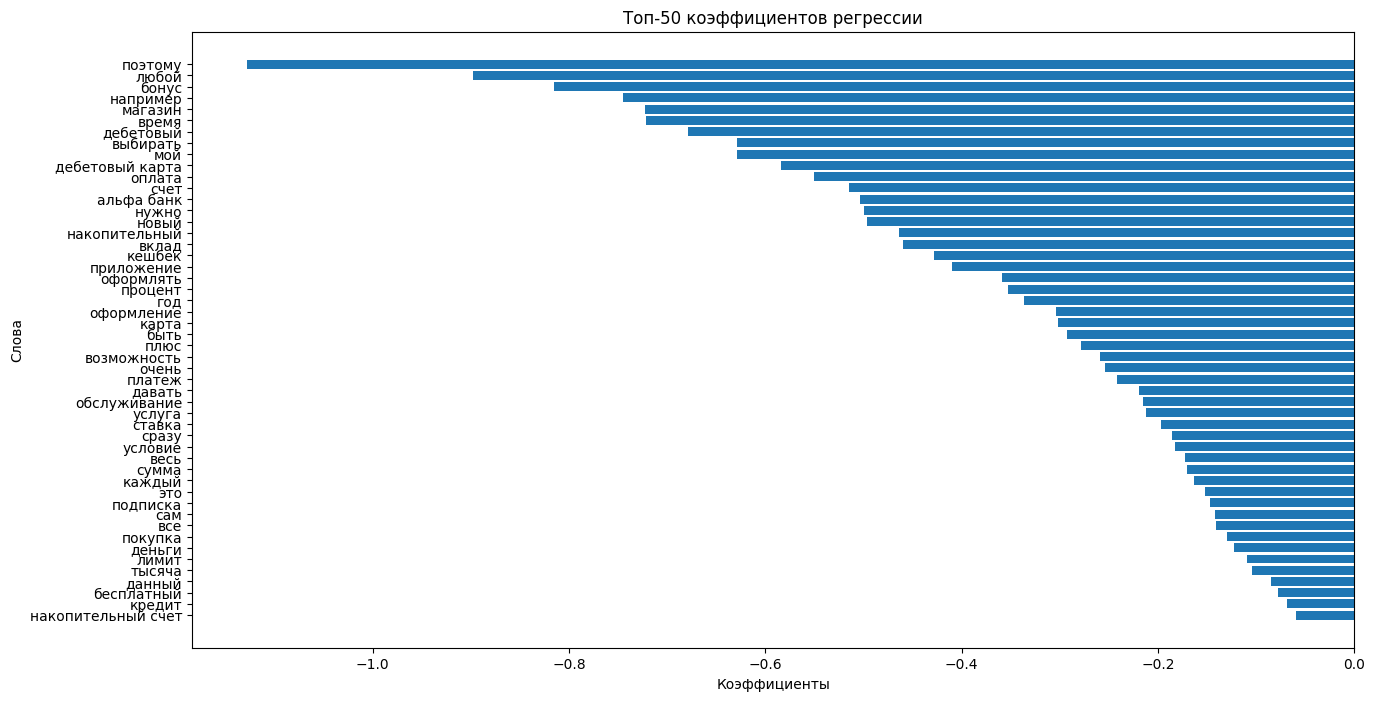

In [150]:
# Получаем индексы слов из словаря CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Получаем коэффициенты регрессии
coefficients = log_reg.coef_[0]

# Сортируем коэффициенты по их значению (весу)
sorted_coefficients = sorted(zip(coefficients, feature_names))

# Разделяем коэффициенты и слова
coefficients, words = zip(*sorted_coefficients)

# Визуализируем топ-50 коэффициентов
top_coefficients = list(zip(coefficients[:50], words[:50]))

# Рисуем столбчатую диаграмму для топ-50 коэффициентов
plt.figure(figsize=(15, 8))
plt.barh(range(len(top_coefficients)), [coef for coef, word in top_coefficients], align='center')
plt.yticks(range(len(top_coefficients)), [word for coef, word in top_coefficients])
plt.xlabel('Коэффициенты')
plt.ylabel('Слова')
plt.title('Топ-50 коэффициентов регрессии')
plt.gca().invert_yaxis()  # Переворачиваем ось y, чтобы слова шли в порядке убывания значений коэффициентов
plt.show()

<b>Вывод:</b> В целом мы видим, что модель учится, но показатели не очень хорошие, из-за малого объёма информации в датасете.